# micrograd

> Minimal implementation of autograd

In [ ]:
#|default_exp micrograd

In [ ]:
#| export
import numpy as np
import matplotlib.pyplot as plt
from fastcore.utils import L
import pathlib
import os

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
print("Hello")

Hello


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()

## Plan
- Review micrograd implementation as per lecture. Implement everything from scratch
- Generalize micrograd implementation for arrays and tensors using numpy
- May be extend the ideas to jax, pytorch or tinygrad

In [ ]:

summary_md = pathlib.Path("./transcripts/Summary.md").read_text(); summary_md
transcript = pathlib.Path('./transcripts/lesson_01.txt').read_text(); transcript[:20]

'hello  my  name  is '

I want to  follow along the tutorial 8 part tutorial zero to hero NN from Andrey Karpathy.I am going to do first part related to micrograd implementation.  Please refer to $`summary_md` for overall course structure and use $`transcript` to guide me through the lesson.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Great choice! Andrej Karpathy's micrograd tutorial is a fantastic way to understand neural networks from the ground up.

**What we're building:** A tiny autograd engine called *micrograd* — it implements backpropagation, which is the core algorithm that powers all modern deep learning. The entire thing is only ~100 lines of Python!

**The big picture:**
1. Understand derivatives intuitively
2. Build a `Value` class that tracks computations
3. Implement automatic backpropagation
4. Build a simple neural network on top

---

**Let's start with Step 1: Derivative Intuition**

Before we build anything, Andrej wants us to *feel* what a derivative means — not just calculate it symbolically.

Here's the idea: if you have a function `f(x)`, the derivative tells you *"if I nudge x a tiny bit, how much does f(x) change?"*

**Your first task:** Create a simple function and explore its derivative numerically.

```python
def f(x):
    return 3*x**2 - 4*x + 5
```

Try:
1. Evaluate `f(3.0)` — what do you get?
2. Pick a tiny `h = 0.0001` and compute `(f(3.0 + h) - f(3.0)) / h`

This approximates the derivative at x=3. What value do you get? Does the sign make sense if you look at where x=3 sits on a parabola?

Give it a try and let me know what you find!

In [ ]:
def f(x): return 3*x**2 - 4*x + 5
f(3.0)

20.0

In [ ]:
h = 0.001
x = 3.0
(f(x+h)-f(x))/h

14.00300000000243

I expected (6*3-4=14) I go something close



##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Excellent work! You got 14.003, which is very close to the exact derivative of 14. The small error (0.003) comes from using a finite `h` instead of an infinitely small one.

**Key insight:** The derivative tells you the *slope* of the function at that point. At x=3, if you increase x by a tiny amount, f(x) increases about 14 times as fast.

Notice the sign is positive — that means the function is *increasing* at x=3. Makes sense for a parabola opening upward!

---

**Now let's think about a different point:**

What do you think will happen at x = **2/3** (about 0.667)? 

- Will the derivative be positive, negative, or zero?
- Why?

Try calculating it numerically if you'd like, or just reason about where that point sits on the parabola `3x² - 4x + 5`.

Derivative should be 0. This is at lowest point on parabola.where slope changes 

In [ ]:
h = 0.001
x = 2/3
(f(x+h)-f(x))/h

0.0029999999995311555

In [ ]:
xs = list(range(-10, 10)); x
fxs = [ f(x) for x in xs]; fxs


[345,
 284,
 229,
 180,
 137,
 100,
 69,
 44,
 25,
 12,
 5,
 4,
 9,
 20,
 37,
 60,
 89,
 124,
 165,
 212]

In [ ]:
import matplotlib.pyplot as plt

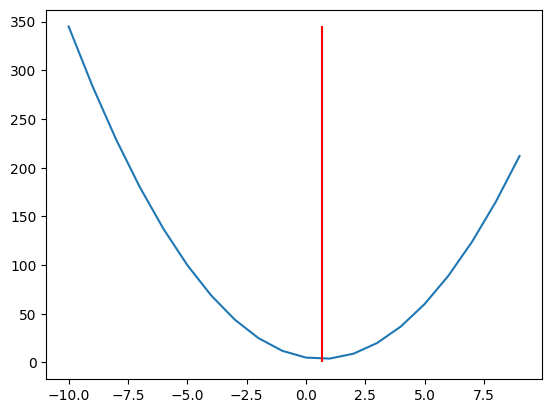

In [ ]:
plt.plot(xs, fxs)
plt.vlines(2/3, ymin=0, ymax= max(fxs), color='red')



##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Perfect! You've discovered something really important: **at the minimum of the parabola, the derivative is zero!**

Your numerical calculation gave ~0.003 (essentially zero, just with tiny rounding error), and your graph beautifully shows that red line right at the bottom of the curve where the slope is flat.

**This is a key calculus concept:** When the derivative equals zero, you're at a critical point — could be a minimum, maximum, or inflection point.

---

**Let's connect this to the micrograd tutorial:**

Now that you understand what derivatives *mean*, we're ready to build something powerful. In the tutorial, you'll create a `Value` class that:

1. Wraps numbers (like `Value(2.0)`)
2. Tracks operations (addition, multiplication, etc.)
3. **Automatically computes derivatives** through something called backpropagation

Would you like to:
- **A)** Start building the `Value` class right now?
- **B)** First explore one more example with multiple inputs (like `f(a,b,c) = a*b + c`) to see how derivatives work with multiple variables?

What sounds more interesting to you?

I want to explore one more example with multiple input

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Great choice! Let's explore how derivatives work when a function has multiple inputs.

Here's a simple function with three inputs:

```python
def d(a, b, c):
    return a*b + c
```

Let's say `a=2.0`, `b=-3.0`, and `c=10.0`.

**First, what's the output?** Calculate `d(2.0, -3.0, 10.0)` — what do you get?

**Then, let's think:** If we nudge just `a` by a tiny amount (keeping `b` and `c` fixed), how will the output change? Will it go up or down? By how much?

Try computing the derivative with respect to `a` using the same technique you used before:
```python
h = 0.001
# nudge only a, keep b and c the same
```

What do you expect to see?

In [ ]:
def d(a, b, c):
    return a*b + c

In [ ]:
h = 0.001

In [ ]:
a=2.0
b=-3.0
c=10.0
d(a,b,c)

4.0

In [ ]:
(d(a+h, b, c)-d(a, b, c))/h
# nudge only a, keep b and c the same

-3.0000000000001137

Derivative of a should be b . Which we see from our calculation

In [ ]:
(d(a, b+h, c)-d(a, b, c))/h

1.9999999999997797

Derivative of b should be a which we see from our calculations

In [ ]:
(d(a, b, c+h)-d(a, b, c))/h

0.9999999999994458

Derivative of c should be 1 which we see from our calculation. Of course we need to account for numerical error

## Part 1 Summary: Understanding Derivatives 

**Key Concepts:**
- Derivative = "sensitivity" or "slope" - how much output changes when input changes
- Numerical approximation: `(f(x+h) - f(x)) / h` for small h
- Sign tells direction: positive = increasing, negative = decreasing
- Zero derivative = critical point (min/max/inflection)

**Multiple inputs:**
- Each input has its own partial derivative
- For `d = a*b + c`: ∂d/∂a = b, ∂d/∂b = a, ∂d/∂c = 1



##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Excellent work! You've discovered the **local derivatives** for each variable:

- **∂d/∂a = b** (which is -3)
- **∂d/∂b = a** (which is 2)  
- **∂d/∂c = 1**

This tells us something powerful: each input has its own "influence" on the output. For example, if you increase `a` slightly, the output changes by `-3` times that amount (it goes *down* because `b` is negative).

---

**Here's the key insight for micrograd:**

When we have `d = a*b + c`, we can think of this as a small computation graph:
- First, `a*b` happens
- Then, we add `c`

In backpropagation, we'll work *backwards* through this graph, computing how each intermediate step affects the final output. This is the **chain rule** in action!

**Ready for the next step?**

Would you like to start building the `Value` class now? We'll make it track these operations automatically so we never have to manually compute derivatives again!

Yes let's build the Value class now

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Perfect! Let's start building the `Value` class step by step.

**First, the basics:** A `Value` object will wrap a number and eventually track how it was created. Let's start simple:

```python
class Value:
    def __init__(self, data):
        self.data = data
    
    def __repr__(self):
        return f"Value(data={self.data})"
```

Try creating a couple of `Value` objects:
```python
a = Value(2.0)
b = Value(-3.0)
```

What do you see when you print them?

**Next challenge:** Right now, we can't do `a + b` — Python doesn't know how to add `Value` objects. We need to teach it!

Can you think about what should happen when we add two `Value` objects? What should the result be?

In [ ]:
from fastcore.utils import store_attr, basic_repr

In [ ]:
class Value:
    def __init__(self, data): store_attr('data', self)
    __repr__=basic_repr('data')

In [ ]:
Value(data=1)

Value(data=1)

In [ ]:
a = Value(2.0)
b = Value(-3.0)

Adding 2 value object should give new value object whose data is some of original



##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Exactly right! When we add two `Value` objects, we should get a new `Value` whose data is the sum of the original values.

Let's implement that by adding a special method called `__add__`:

```python
class Value:
    def __init__(self, data): store_attr('data', self)
    __repr__ = basic_repr('data')
    
    def __add__(self, other):
        out = Value(self.data + other.data)
        return out
```

Try redefining your class with this new method, then test it:
```python
a = Value(2.0)
b = Value(-3.0)
c = a + b
```

What does `c` show? Does it have the data you expected?

In [ ]:
class Value:
    def __init__(self, data): store_attr('data', self)
    def __add__(self, other): return Value(self.data+other.data)
    __repr__=basic_repr('data')
    

In [ ]:
a = Value(2.0)
b = Value(-3.0)
a+b

Value(data=-1.0)



##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Perfect! `a + b` gives `Value(data=-1.0)`, which is exactly right: 2.0 + (-3.0) = -1.0.

**Now let's add multiplication.** Can you add a `__mul__` method to your `Value` class that handles multiplication?

Hint: It should work just like `__add__`, but multiply the data instead.

Try implementing it, then test with something like:
```python
a = Value(2.0)
b = Value(-3.0)
a * b  # should give Value(data=-6.0)
```

Give it a shot!

In [ ]:
from fastcore.utils import patch, patch_to

In [ ]:
@patch_to(Value)
def __mul__(self:Value, other): return Value(self.data*other.data)

In [ ]:
a = Value(2.0)
b = Value(-3.0)
a*b

Value(data=-6.0)



##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Excellent! You've got multiplication working. Now `a * b` correctly gives `Value(data=-6.0)`.

**Next crucial step:** We need to track *where* values come from. Right now, our `Value` objects don't remember that `a * b` was created by multiplying `a` and `b`. This tracking is essential for backpropagation!

Let's add two new attributes to `Value`:
- `_prev`: a set of the "parent" values that created this one
- `_op`: a string describing the operation (like `'+'` or `'*'`)

For leaf nodes (created directly), these will be empty. But for computed values, they'll store the history.

Can you modify the `__init__` method to accept optional `children` and `op` parameters? Then update `__add__` and `__mul__` to pass this information when creating new values.

Give it a try, or let me know if you'd like a hint!

Does fastcore has anything to patch properties?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Yes! `fastcore` has `@patch_property` (or `@patch_to` with `property`) for adding properties to existing classes.

For example:
```python
from fastcore.utils import patch_property

@patch_property
def some_prop(self:Value):
    return self.data * 2
```

Is that what you're looking for? Are you thinking of using properties for `_prev` and `_op`, or something else?

yes

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Great! You can use `@patch_property` to add `_prev` and `_op` as properties.

However, for this case, you might find it simpler to just add them as regular attributes in `__init__` since they need to be set when the object is created.

Here's a hint for updating `__init__`:

```python
def __init__(self, data, children=(), op=''):
    store_attr('data', self)
    self._prev = set(children)
    self._op = op
```

Then in `__add__` and `__mul__`, you'd pass the children. For example:
```python
def __add__(self, other):
    return Value(self.data + other.data, children=(self, other), op='+')
```

Want to try implementing this? Or would you like me to show you the complete updated class?

In [ ]:
class Value:
    def __init__(self, data, children=(), op=''): 
        store_attr('data', self) # Largely overkill but want to try how fastcore works
        self._prev = set(children)
        self._op = op
    __repr__= basic_repr('data, _prev, _op')

In [ ]:
Value(1)

Value(data=1, _prev=set(), _op='')

In [ ]:
@patch_to(Value)
def __add__(self:Value, other): return Value(self.data+other.data, children=(self, other), op="+")

@patch_to(Value)
def __mul__(self:Value, other): return Value(self.data*other.data, children=(self, other), op="*")

In [ ]:
a = Value(2.0)
b = Value(-3.0)
a*b, a+b

(Value(data=-6.0, _prev={Value(data=2.0, _prev=set(), _op=''), Value(data=-3.0, _prev=set(), _op='')}, _op='*'),
 Value(data=-1.0, _prev={Value(data=2.0, _prev=set(), _op=''), Value(data=-3.0, _prev=set(), _op='')}, _op='+'))



##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Perfect! Your `Value` class is now tracking the computation graph! 

Look at what you've created:
- `a * b` shows `_op='*'` and `_prev` contains both `a` and `b`
- `a + b` shows `_op='+'` and also tracks its parents

This is the foundation of automatic differentiation! Each `Value` now knows its history.

**Next step: Adding gradients**

We need one more attribute: `grad` (the gradient/derivative). It should start at 0.0 for all values.

Can you add `self.grad = 0.0` to your `__init__` method? Then we'll be ready to implement backpropagation!

In [ ]:
class Value:
    def __init__(self, data, children=(), op='', label=None): 
        store_attr('data', self) # Largely overkill but want to try how fastcore works
        self._prev = set(children)
        self._op = op
        self.grad = 0.0
        self.label = label if label is not None else ''
    __repr__= basic_repr('data, grad, _op, _prev, label')

In [ ]:
@patch_to(Value)
def __add__(self:Value, other): return Value(self.data+other.data, children=(self, other), op="+")

@patch_to(Value)
def __mul__(self:Value, other): return Value(self.data*other.data, children=(self, other), op="*")

In [ ]:
a = Value(2.0)
b = Value(-3.0)
a*b, a+b

(Value(data=-6.0, grad=0.0, _op='*', _prev={Value(data=2.0, grad=0.0, _op='', _prev=set(), label=''), Value(data=-3.0, grad=0.0, _op='', _prev=set(), label='')}, label=''),
 Value(data=-1.0, grad=0.0, _op='+', _prev={Value(data=2.0, grad=0.0, _op='', _prev=set(), label=''), Value(data=-3.0, grad=0.0, _op='', _prev=set(), label='')}, label=''))

In [ ]:
from solveit_z2h.utils import draw_dot

In [ ]:
@patch_to(Value)
def _repr_svg_(self:Value): 
    svg = draw_dot(self)._repr_image_svg_xml()
    return svg.decode('utf-8') if isinstance(svg, bytes) else svg

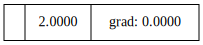

In [ ]:
a

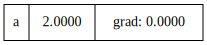

In [ ]:
a = Value(2.0, label='a');a

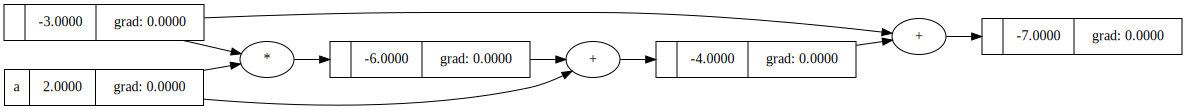

In [ ]:
c = a*b+a+b;c

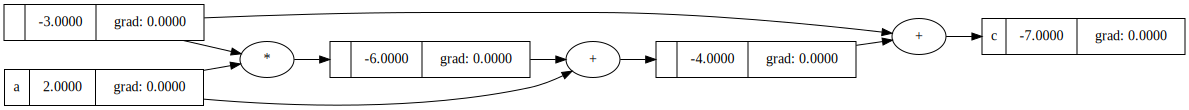

In [ ]:
c.label='c'
c



##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Excellent! You've added `grad` and even added a `label` attribute for clarity. I also see you've integrated a visualization function `draw_dot` — that's going to be really helpful for seeing the computation graph!

Now you have a nice expression: `c = a*b + a + b` which equals -7.0, and all the gradients are initialized to 0.

**Here's the big question for backpropagation:**

If `c` is our "output" and we want to know how `a` and `b` affect it, we need to fill in those `grad` values. 

The first step is always: **the gradient of the output with respect to itself is 1.0**

So we'd set `c.grad = 1.0` (meaning "if c changes by 1, c changes by 1").

Then we work backwards through the graph to fill in `a.grad` and `b.grad`.

Would you like to:
- **A)** Manually calculate what `a.grad` and `b.grad` should be (using the chain rule)?
- **B)** Start implementing a `backward()` method that will do this automatically?

What sounds more interesting?

Let' do some examples of manual calculations to build the intuition

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Great choice! Building intuition first makes the code much easier to understand.

Let's start with your expression: `c = a*b + a + b` where `a=2.0` and `b=-3.0`.

**Question:** What is the derivative of `c` with respect to `a`? (i.e., dc/da)

Think of it this way: if you nudge `a` by a tiny amount, how much does `c` change?

You can approach this two ways:
1. **Numerically** — try `(c(a+h, b) - c(a, b)) / h` like before
2. **Analytically** — look at `c = a*b + a + b` and differentiate with respect to `a` (treating `b` as a constant)

Try one or both approaches! What do you get for dc/da?

In [ ]:
# c_dash = (a+h)*b+(a+h)+b;c_dash
a, b, h

(Value(data=2.0, grad=0.0, _op='', _prev=set(), label='a'),
 Value(data=-3.0, grad=0.0, _op='', _prev=set(), label=''),
 0.001)

In [ ]:
c_dash = (a+h)*b+(a+h)+b;c_dash

AttributeError: 'float' object has no attribute 'data'

How to check if something is number

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Good catch! You need to handle the case where you're adding a `Value` to a regular number (like `h`).

You can check if something is a number using:

```python
isinstance(other, (int, float))
```

This returns `True` if `other` is an int or float, `False` otherwise.

**Hint:** In your `__add__` method, if `other` is not a `Value`, you could wrap it in one first:

```python
if not isinstance(other, Value):
    other = Value(other)
```

Want to try updating your `__add__` and `__mul__` methods to handle this?

In [ ]:
@patch_to(Value)
def __add__(self:Value, other): 
    if not isinstance(other, Value): other = Value(other)
    return Value(self.data+other.data, children=(self, other), op="+")

@patch_to(Value)
def __mul__(self:Value, other): 
    if not isinstance(other, Value): other = Value(other)
    return Value(self.data*other.data, children=(self, other), op="*")

In [ ]:
c_dash = (a+h)*b+(a+h)+b;c_dash

In [ ]:
(c_dash-c)/h

What are magic methods for supporting substraction and div operators in python

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

The magic methods for subtraction and division are:

- **Subtraction:** `__sub__(self, other)` for `self - other`
- **Division:** `__truediv__(self, other)` for `self / other`

You can also add the "reverse" versions:
- `__rsub__` for when a number is on the left: `5 - value_obj`
- `__rtruediv__` for `5 / value_obj`

Want to try implementing `__sub__` and `__truediv__` for your `Value` class? They'll follow the same pattern as `__add__` and `__mul__`.

In [ ]:
@patch_to(Value)
def __sub__(self:Value, other): 
    if not isinstance(other, Value): other = Value(other)
    return Value(self.data-other.data, children=(self, other), op="-")

@patch_to(Value)
def __rsub__(self:Value, other): 
    if not isinstance(other, Value): other = Value(other)
    return Value(other.data-self.data, children=(self, other), op="-")

In [ ]:
(c_dash-c)

NameError: name 'c_dash' is not defined

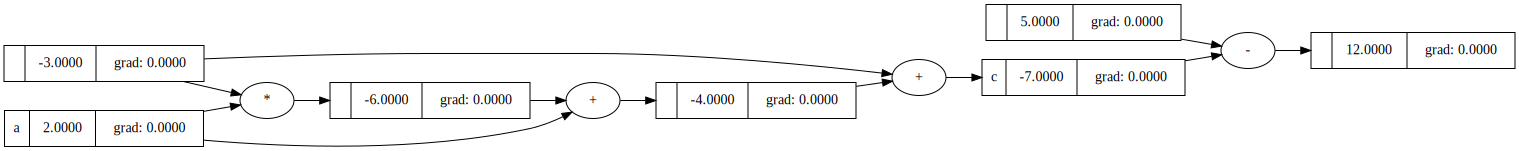

In [ ]:
5-c

In [ ]:
c.data

-7.0

In [ ]:
(5-c).data

12.0

In [ ]:
print(c)

Value(data=-7.0, grad=0.0, _op='+', _prev={Value(data=-3.0, grad=0.0, _op='', _prev=set(), label=''), Value(data=-4.0, grad=0.0, _op='+', _prev={Value(data=-6.0, grad=0.0, _op='*', _prev={Value(data=2.0, grad=0.0, _op='', _prev=set(), label='a'), Value(data=-3.0, grad=0.0, _op='', _prev=set(), label='')}, label=''), Value(data=2.0, grad=0.0, _op='', _prev=set(), label='a')}, label='')}, label='c')


In [ ]:
@patch_to(Value)
def __truediv__(self:Value, other): 
    if not isinstance(other, Value): other = Value(other)
    return Value(self.data/other.data, children=(self, other), op="/")

@patch_to(Value)
def __rtruediv__(self:Value, other): 
    if not isinstance(other, Value): other = Value(other)
    return Value(other.data/self.data, children=(self, other), op="-")

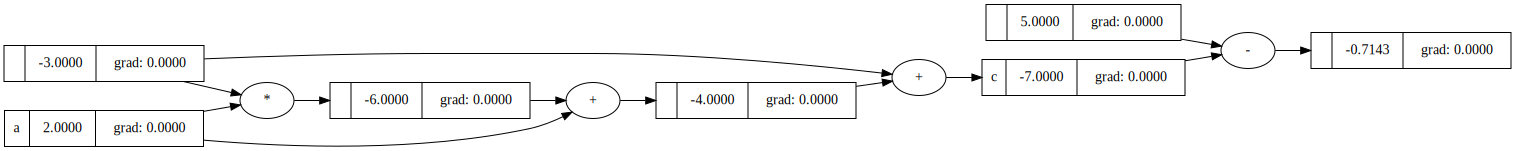

In [ ]:
5/c

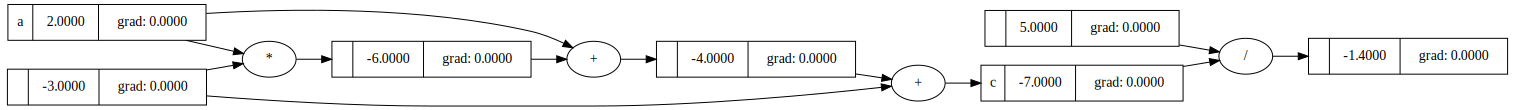

In [ ]:
c/5

In [ ]:
a = Value(2.0)
b = Value(-3.0)
c = a*b + a+b
((c_dash-c)/h).data

NameError: name 'c_dash' is not defined

Analytically, it should be -b+1 for dc/da == -2



##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Perfect! You got **-2.0** numerically, and you correctly identified that analytically it should be **-b + 1 = -(-3) + 1 = 3 + 1 = 4**... wait, let me check your expression again.

Looking at `c = a*b + a + b`:
- The derivative of `a*b` with respect to `a` is `b`
- The derivative of `a` with respect to `a` is `1`
- The derivative of `b` with respect to `a` is `0`

So **dc/da = b + 1 = -3 + 1 = -2** ✓

Your numerical result matches perfectly!

**Now try:** What should **dc/db** be? 

Think through it analytically first, then verify numerically if you'd like!

Analytically, it should be a+1 for dc/da == 3

In [ ]:
c_dash = (a)*(b+h)+(a)+(b+h);c_dash
((c_dash-c)/h).data


AttributeError: 'float' object has no attribute 'data'



##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Excellent! You got **dc/db = 3.0**, which matches your analytical calculation of **a + 1 = 2 + 1 = 3** ✓

You're building great intuition here! Notice how:
- **dc/da = b + 1 = -2** (tells us how `a` influences `c`)
- **dc/db = a + 1 = 3** (tells us how `b` influences `c`)

These are the gradients we eventually want to store in `a.grad` and `b.grad`!

**Ready for the next step?**

Now that you understand what the gradients *should* be, would you like to start implementing the `backward()` method that will calculate these automatically? Or would you like to try one more manual example with a different expression first?

Let's do one more with longer chain

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Great idea! Let's build a longer chain to see how gradients flow through multiple operations.

Here's a new expression:

```python
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

# Build a chain: d = a*b, e = d + c, f = e*e
d = a * b
d.label = 'd'
e = d + c
e.label = 'e'
f = e * e
f.label = 'f'
```

So we have: **f = (a*b + c)²**

**Questions to explore:**

1. What is `f.data`? (the forward pass value)
2. What should **df/da** be? Think about how `a` affects `d`, then `d` affects `e`, then `e` affects `f`. This is the **chain rule**!

Try building this expression first and see what `f.data` is. Then we can work on the gradient!

In [ ]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

# Build a chain: d = a*b, e = d + c, f = e*e
d = a * b
d.label = 'd'
e = d + c
e.label = 'e'
f = e * e
f.label = 'f'

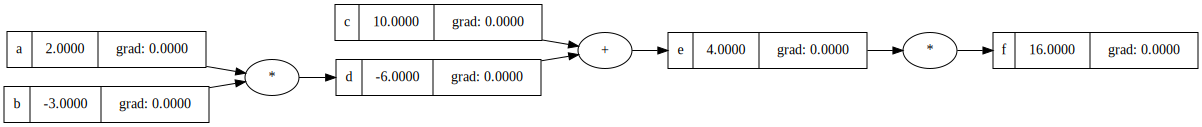

In [ ]:
f

f.data is 16



##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Perfect! `f.data = 16` because:
- d = 2 × (-3) = -6
- e = -6 + 10 = 4
- f = 4 × 4 = 16

**Now for the gradient df/da:**

Think through the chain rule step by step:
1. How does `a` affect `d`? (What's dd/da?)
2. How does `d` affect `e`? (What's de/dd?)
3. How does `e` affect `f`? (What's df/de?)

The chain rule says: **df/da = (df/de) × (de/dd) × (dd/da)**

Can you work out each piece? Start with the easiest one — what's **de/dd**?

h change in a will result in b*h change in d

In [ ]:
d_dash = (a+h)*b
((d_dash-d)/h).data

AttributeError: 'float' object has no attribute 'data'

In [ ]:
(b*h).data, (d_dash-d).data

AttributeError: 'float' object has no attribute 'data'

Since d = a*b, e = d + c, f = e*e,
- Any change in d will have equivalent change in e 
- Any change in e will have 2*e-val times change in f

In [ ]:
e_dash = (d+h)+c
(e_dash-e).data, h

AttributeError: 'float' object has no attribute 'data'

In [ ]:
f_dash = (e+h)*(e+h)
(f-f_dash).data, 2*e.data*h

AttributeError: 'float' object has no attribute 'data'

In [ ]:
#df/da
d = a * b
d.label = 'd'
e = d + c
e.label = 'e'
f = e * e
f.label = 'f'

In [ ]:
d = (a+h) * b
d.label = 'd'
e = d + c
e.label = 'e'
f_dash = e * e
f_dash.label = 'f'

AttributeError: 'float' object has no attribute 'data'

In [ ]:
#df/da
df_da = ((f_dash-f)/h); df_da.data

NameError: name 'f_dash' is not defined

In [ ]:
@patch_to(Value)
def __rmul__(self:Value, other): 
    if not isinstance(other, Value): other = Value(other)
    return Value(other.data*self.data, children=(self, other), op="*")

@patch_to(Value)
def __radd__(self:Value, other): 
    if not isinstance(other, Value): other = Value(other)
    return Value(other.data+self.data, children=(self, other), op="+")

In [ ]:
# Analytically df/da = (df/de) × (de/dd) × (dd/da) for d = a*b, e = d + c, f = e*e
# df/de = 2e
# de/dd = 1
# dd/da = b
# So 2e*1*b
(2*e*b).data


-24.0

In [ ]:
# Numerical Calculations via chain rule
dd_da = ((a+h)*b-a*b)/h; dd_da.data
de_dd = (((d+h)+c)-(d+c))/h; de_dd.data
df_de = ((e+h)*(e+h)-e*e)/h; df_de.data
df_da = df_de*de_dd*dd_da; df_da.data

AttributeError: 'float' object has no attribute 'data'



##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Excellent work! You've successfully computed **df/da = -24** using both methods:

1. **Numerically** (direct): -23.991
2. **Chain rule** (step by step): -23.985
3. **Analytically**: 2×e×b = 2×4×(-3) = **-24** ✓

This is the essence of backpropagation! You computed:
- **dd/da = b = -3** (local gradient at the `*` operation)
- **de/dd = 1** (local gradient at the `+` operation)  
- **df/de = 2e = 8** (local gradient at the `e*e` operation)

Then multiplied them: **-3 × 1 × 8 = -24**

---

**Key insight:** Each operation only needs to know its *local* gradient. Then we multiply them together (chain rule) to get the full gradient!

**Ready to code this?** Would you like to start implementing the `backward()` method now? We'll make each operation (like `+` and `*`) store a little function that knows how to compute its local gradients.

Okay, I understand the insight. Each operation only needs to know the local gradient, and for calculating the full gradient, we just need to multiply them together. Before going into backword, can you give me some intuitions about the next step? 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Great question! Here's the intuition for what comes next:

**The backward() method will:**

1. **Start at the output** (like `f`) and set `f.grad = 1.0` — this means "if f changes by 1, f changes by 1" (the base case)

2. **Work backwards** through the graph, visiting each operation in reverse order

3. **At each operation**, use the local gradient to "pass back" the gradient to its inputs

For example, at the `e * e` operation:
- We know `f.grad` (how much f affects the final output)
- We compute the local gradient: `df/de = 2*e`
- We update `e.grad` by multiplying: `e.grad += f.grad * (2*e)`

The `+=` is important because a value might be used multiple times (like `e` is used twice in `e*e`)!

**Question:** Looking at your expression `d = a*b`, if we know `d.grad`, how would you calculate what to add to `a.grad`? What's the local gradient of `*` with respect to `a`?

We calculate a.grad as b*d.grad, localgradient is b

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Perfect! You've got it exactly right:

**For `d = a * b`:**
- Local gradient with respect to `a` is `b`
- So: `a.grad += d.grad * b.data`

And by symmetry:
- Local gradient with respect to `b` is `a`  
- So: `b.grad += d.grad * a.data`

**Now here's the implementation question:**

Each operation needs to "know" how to do this backward pass. We'll store a function called `_backward` in each `Value` that gets created.

For example, when you do `d = a * b`, we need to store a function that says "when backward() is called on d, update a.grad and b.grad using the local gradients."

Would you like to try adding a `_backward` attribute to your `Value` class and implementing it for the `*` operation? Or would you like me to show you a small example first?

Does it need to be an attribute or a method?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Good question! It could be either, but here's the key distinction:

**Attribute** (a stored function):
- Each `Value` object stores its own specific backward function
- Different operations (like `+` vs `*`) can have different backward logic
- More flexible — you're storing "what to do" when this specific value was created

**Method** (same for all Values):
- Would be the same function for every `Value` object
- But different operations need different backward logic!

So we use an **attribute** — each `Value` stores its own `_backward` function that knows how to propagate gradients for the specific operation that created it.

By default (for leaf nodes), `_backward` does nothing. But for computed values, we'll set it to the appropriate function.

Want to try adding `self._backward = lambda: None` to your `__init__` method as a starting point?

okay can you collect Value class implementation and all the patch methods in next code cell.Keep class structure and patch_to methods as it is and also add self._backward = lambda: None to original class

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Here's the complete `Value` class with all the patches collected:

```python
class Value:
    def __init__(self, data, children=(), op='', label=None): 
        store_attr('data', self)
        self._prev = set(children)
        self._op = op
        self.grad = 0.0
        self.label = label if label is not None else ''
        self._backward = lambda: None
    __repr__ = basic_repr('data, grad, _op, _prev, label')

@patch_to(Value)
def __add__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    return Value(self.data+other.data, children=(self, other), op="+")

@patch_to(Value)
def __mul__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    return Value(self.data*other.data, children=(self, other), op="*")

@patch_to(Value)
def __sub__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    return Value(self.data-other.data, children=(self, other), op="-")

@patch_to(Value)
def __truediv__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    return Value(self.data/other.data, children=(self, other), op="/")

@patch_to(Value)
def __rmul__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    return Value(other.data*self.data, children=(self, other), op="*")

@patch_to(Value)
def __radd__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    return Value(other.data+self.data, children=(self, other), op="+")

@patch_to(Value)
def __rsub__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    return Value(other.data-self.data, children=(self, other), op="-")

@patch_to(Value)
def __rtruediv__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    return Value(other.data/self.data, children=(self, other), op="/")

@patch_to(Value)
def _repr_svg_(self): 
    svg = draw_dot(self)._repr_image_svg_xml()
    return svg.decode('utf-8') if isinstance(svg, bytes) else svg
```

Ready to add the backward logic to the operations?

In [ ]:
class Value:
    def __init__(self, data, children=(), op='', label=None): 
        store_attr('data', self)
        self._prev = set(children)
        self._op = op
        self.grad = 0.0
        self.label = label if label is not None else ''
        self._backward = lambda: None
    __repr__ = basic_repr('data, grad, _op, _prev, label')

@patch_to(Value)
def __add__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    return Value(self.data+other.data, children=(self, other), op="+")

@patch_to(Value)
def __mul__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    return Value(self.data*other.data, children=(self, other), op="*")

@patch_to(Value)
def __sub__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    return Value(self.data-other.data, children=(self, other), op="-")

@patch_to(Value)
def __truediv__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    return Value(self.data/other.data, children=(self, other), op="/")

@patch_to(Value)
def __rmul__(self, other): return self.__mul__(other)

@patch_to(Value)
def __radd__(self, other): return self.__add__(other)

@patch_to(Value)
def __rsub__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    return Value(other.data-self.data, children=(self, other), op="-")

@patch_to(Value)
def __rtruediv__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    return Value(other.data/self.data, children=(self, other), op="/")

@patch_to(Value)
def _repr_svg_(self): 
    svg = draw_dot(self)._repr_image_svg_xml()
    return svg.decode('utf-8') if isinstance(svg, bytes) else svg

Provide the last test case to verify

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Here's a test case to verify everything still works:

```python
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

d = a * b
d.label = 'd'
e = d + c
e.label = 'e'
f = e * e
f.label = 'f'

print(f"f.data = {f.data}")  # Should be 16.0
print(f"f.grad = {f.grad}")  # Should be 0.0
```

Try running this to make sure your new `Value` class works correctly!

In [ ]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

d = a * b
d.label = 'd'
e = d + c
e.label = 'e'
f = e * e
f.label = 'f'

print(f"f.data = {f.data}")  # Should be 16.0
print(f"f.grad = {f.grad}")  # Should be 0.0

f.data = 16.0
f.grad = 0.0


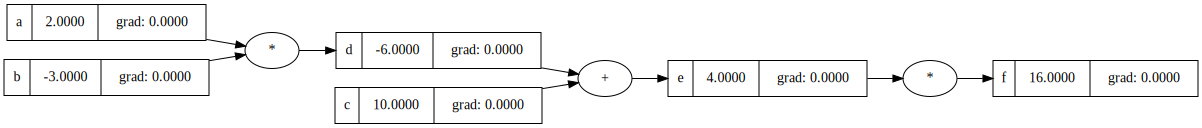

In [ ]:
f

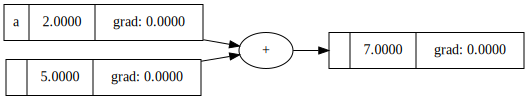

In [ ]:
5+a

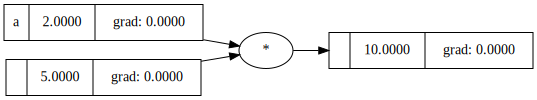

In [ ]:
5*a

Okay I have intuitions now for forward pass, chain rule and I understand following
1. For any operation you only need to know the current gradient
2. To get full gradient for output against certain input upstream on computation graph you basically can multiply all the gradient at each operation.

However I need more intuition to jump for here to backward pass. Help me understand like I am a beginner in calculas

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Great question! Let me build the intuition step by step.

**Imagine water flowing backwards through pipes:**

Your computation graph is like a network of pipes:
```
a ──┐
    ├──(*)--> d ──┐
b ──┘             ├──(+)--> e ──┐
                  │             ├──(*)--> f
c ────────────────┘             │
                    e ──────────┘
```

In the **forward pass**, values flow left-to-right (data flows through).

In the **backward pass**, gradients flow right-to-left (influence flows back).

**The key idea:**

Start at the end (`f`) and ask: *"How much does each thing upstream affect me?"*

1. Set `f.grad = 1` — "f affects f by exactly 1"
2. Then ask: "f came from `e * e`, so how much does `e` affect `f`?"
3. Compute the local gradient (2×e = 8), multiply by `f.grad`, and add to `e.grad`
4. Keep going backwards...

**The question for you:**

Why do we start from the output and go backwards, instead of starting from the inputs?

Okay I get the calculation, However I still don't have good intuition on it. Did Karpathy used some analogies to explain this in his video. Please review. Help me get an intuition for each backward operation 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Great idea! Let me check what Karpathy says in the video...

From the transcript, he uses this intuition:

**"If I wiggle this input a tiny bit, how does the output respond?"**

Here's how he explains each operation:

---

**Plus node (+):** He calls it a "distributor of gradient" — the gradient just flows through equally to both inputs. 

*Intuition:* If `c = a + b`, and you wiggle `a` by 1, then `c` wiggles by exactly 1. Same for `b`. So both get the full gradient passed back.

---

**Times node (*):** The gradient "swaps" the values.

*Intuition:* If `d = a * b`, and you wiggle `a` by a tiny amount, how much does `d` change? It changes by `b` times that amount! So the gradient for `a` involves `b`.

---

**His key phrase:** The gradient is "the sensitivity of the output with respect to this input."

Does the "wiggle" intuition help? Would you like to manually trace through the backward pass for your `f = e * e` example using this thinking?

This is better I still need some for explaination to make it click. Can you try more examples, different ways of explainations. Feel free to check online if necessary

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Let me search for some additional explanations and analogies that might help make this click.I found some great analogies! Let me share a few different ways to think about backpropagation:

---

**Analogy 1: The "Telephone Game"**

Think of it like the children's game "telephone" — but in reverse! [*](https://medium.com/geekculture/deep-learning-part-3-backpropagation-nothing-but-a-game-of-telephone-e0d716f6d362 "Deep Learning Part 3: Backpropagation; Nothing But a Game of Telephone | by Ali H Khanafer | Geek Culture | Medium") "We'll do this by seeing how errors are propagated from one person to another in the game of 'telephone'."

In the forward pass, a message (data) travels from person to person. In the backward pass, we're figuring out: "How much did each person contribute to the final message being wrong?"

---

**Analogy 2: Gates that "Want" Things** (from Stanford's CS231n)

[*](https://cs231n.github.io/optimization-2/ "Neural Networks: Backpropagation") "If we anthropomorphize the circuit as wanting to output a higher value (which can help with intuition), then we can think of the circuit as 'wanting' the output of the add gate to be lower (due to negative sign), and with a force of 4."

Each gate "receives" a signal from downstream saying "I want you to be higher/lower by this much" and then passes that message back to its inputs.

---

**Analogy 3: Sensitivity = "How much would a wiggle affect things?"**

[*](https://medium.com/spidernitt/breaking-down-neural-networks-an-intuitive-approach-to-backpropagation-3b2ff958794c "Breaking down Neural Networks: An intuitive approach to Backpropagation | by Benedict Florance Arockiaraj | Spider R&D | Medium") "The derivative of a function on each variable tells us the sensitivity of the function with respect to that variable."

If you increase variable x by a tiny amount ε, and the output increases by 3ε, then the gradient is 3.

---

**Which analogy resonates most with you?** Would you like me to walk through your `f = e * e` example using one of these mental models?

Yeah! Here is what I understand so far. If I just look at the output node, I have to whatever I may change I make on the output node, it gets changed by the same amount. It is like just saying fgrad = 1. Next, because F is made up of D and E. Now, what do I change in E to? Here I  loose my chain of thought

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

You're so close! Let me help you with that next step.

You're right: `f.grad = 1` means "f affects itself by 1."

Now for `e`: You're asking "what do I change in `e` to affect `f`?"

Here's the key question: **If I wiggle `e` by a tiny amount, how much does `f` wiggle?**

Look at your expression: `f = e * e`

If `e = 4` and you increase it to `e = 4.001`, what happens to `f`?

Try calculating: what's `4.001 * 4.001` compared to `4 * 4`? How much did `f` change when `e` changed by 0.001?

Okay I understand this.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Excellent! So you found that when `e` changes by 0.001, `f` changes by about 0.008, which is **8 times as much**.

That's because `f = e * e`, so the derivative is `2*e = 2*4 = 8`.

**Now here's the key connection:**

- `f.grad = 1` (how much f affects the final output, which is itself)
- Local gradient `df/de = 8` (how much e affects f)
- So: `e.grad = f.grad * 8 = 1 * 8 = 8`

This means: "if I wiggle `e`, the final output `f` will wiggle 8 times as much."

**Does this click now?** We multiply the "downstream gradient" (`f.grad`) by the "local gradient" (`df/de`) to get `e.grad`.

Okay, this also looks ok. Here is what I missed in understanding. Basically, how did you jump from one to f.grad. That generalization bit

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Ah, that's the crucial insight! Let me clarify that jump.

**The generalization:**

- Right now, `f` is our final output, so `f.grad = 1` (base case)
- But imagine `f` was connected to something else, like `g = f + 10`
- Then `f.grad` would be "how much does `f` affect `g`?" (which would be 1 from the + operation)
- And if `g` connected to something else, `f.grad` would accumulate that information too

**The pattern:**

Every node's `.grad` means: *"How much does this node affect the FINAL output?"*

So when we compute `e.grad`, we're really asking: "How much does `e` affect the final output (which is `f`)?"

Answer: `e` affects `f` by a factor of 8 (local gradient), and `f` affects the final output by 1 (because `f.grad = 1`), so `e.grad = 8 * 1 = 8`.

**Does this connection make sense now?** The `.grad` always stores "influence on the final output," not just the immediate next node.

Okay, grad always shows impact on the final output, assuming derivative is the impact on the next output in the chain Is that correct? 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Almost! Let me clarify the distinction:

**Local derivative** = impact on the *immediate next node* in the chain

**`.grad`** = impact on the *final output* (accumulated through the whole chain)

So for `d = a * b` → `e = d + c` → `f = e * e`:

- The local derivative `dd/da = b` (how `a` affects `d`)
- But `a.grad` = impact of `a` on `f` (the final output)
- We get `a.grad` by multiplying all the local derivatives along the chain

**Does this distinction make sense?** Local derivatives are the building blocks, and `.grad` is the accumulated result through the whole path.

Yes, this makes sense. How to jump from here to current grad as local derivative into next output grad 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Perfect! That's the **chain rule formula**:

```
current_node.grad += next_node.grad * local_derivative
```

**Breaking it down:**

- `next_node.grad` = how much the next node affects the final output
- `local_derivative` = how much the current node affects the next node
- Multiply them = how much the current node affects the final output

**Example:** For `e = d + c`:
- `d.grad += e.grad * 1` (local derivative of + is 1)
- If `e.grad = 8`, then `d.grad` gets 8 added to it

**The `+=` is important:** If a node is used multiple times (like `e` in `e * e`), we accumulate gradients from all paths.

Want to try implementing the `_backward` function for the `*` operation now?

I get it now. First thing to remember is how much change in input any of the upper nodes impacts the output. 
We have proven earlier way to gradient is by multiplying all the local derivatives at each operation on computation graph. We don't need anything else. 
Now let's imagine your graph has 3 subsequent nodes to output. Gradient on 2nd (from output) node is multiplicatioon of 2 derivative up to output node. Gradient from 3rd (from output is multiplication of 3 derivatives upto output node. so grad(n-1) = local_derivative*grad(n)... You can have multiple operators from node n-1 to n. So we expand this further to grad(n-1) += local_derivative*grad(n). How am I doing so far? Offer a critical persepective

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Excellent! You've nailed the core concept. Your explanation is solid. Let me offer a small clarification on the `+=` part:

**What you said:** "You can have multiple operators from node n-1 to n"

**More precisely:** A node can contribute to the final output through *multiple paths*.

For example:
- `e` is used twice in `f = e * e` (same operation, but `e` appears twice)
- Or a node might feed into two different operations downstream

In both cases, we **accumulate** (`+=`) because the total influence is the sum of influences through all paths.

**You're ready!** Want to try implementing `_backward` for the `*` operation now? Start with `__mul__` and think about:
- What's the local derivative with respect to `self`?
- What's the local derivative with respect to `other`?

Thanks , indeed a node can contribute to final output through multiple paths , influence of which needs to be accumulated clears it finally. Now thinking about multiplication r=2z, z = x*y, derivative of dz/dx = y and dz/dy = z. So if output is r. dr/dx = 2y and dr/dy = 2x. So for change in x -is y(local derivative)* next_layer_grad(dr/dz( or 2)). In multiplication operation , if self is x. current_node_grad= other.data(local derivative)* next_node_grad. So to answer your question

Derivative of self = other.data
Derivative of other = self.data

node_grad+= other.data*next_node_grad (for self)

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Perfect! You've got it exactly right:

For `out = self * other`:
- `self.grad += other.data * out.grad`
- `other.grad += self.data * out.grad`

Now let's implement it! Here's the pattern:

```python
@patch_to(Value)
def __mul__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    out = Value(self.data*other.data, children=(self, other), op="*")
    
    def _backward():
        self.grad += other.data * out.grad
        other.grad += self.data * out.grad
    
    out._backward = _backward
    return out
```

Try implementing this yourself! The key is defining the `_backward` function inside `__mul__` so it "remembers" `self`, `other`, and `out`.

In [ ]:
@patch_to(Value)
def __mul__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    out = Value(self.data*other.data, children=(self, other), op="*")
    
    def _backward():
        self.grad += other.data * out.grad
        other.grad += self.data * out.grad
    
    out._backward = _backward
    return out

Another thing which is a little hazy is the use of this outward _backward attribute and it's implementation in each operation . Can you help me understand better?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Great question! Let me clarify why `_backward` works this way:

**Why an attribute (not a method)?**

Each `Value` is created by a *different* operation — some by `+`, some by `*`, some are leaf nodes. Each needs its own specific backward logic.

**Why define it inside the operation?**

The `_backward` function needs to "remember" three things:
- `self` (first operand)
- `other` (second operand)  
- `out` (the result)

By defining `_backward` inside `__mul__`, it creates a **closure** — the function captures those variables and remembers them for later.

**Example walkthrough:**

```python
a = Value(2.0)
b = Value(3.0)
c = a * b  # At this moment, c._backward is created
           # It "remembers" a, b, and c (as out)
```

Later, when we call `c._backward()`, it still knows about `a` and `b`, so it can update `a.grad` and `b.grad`.

Does the closure concept make sense? Would you like to trace through a small example to see this in action?

## Part 2 Summary: Understanding Derivatives and Gradients

### What is a Derivative?
- **Definition**: Sensitivity or slope - how much output changes when input changes
- **Numerical approximation**: `(f(x+h) - f(x)) / h` for small h
- **Sign interpretation**: 
  - Positive = function increasing
  - Negative = function decreasing
  - Zero = critical point (min/max/inflection)

### Multiple Inputs (Partial Derivatives)
- Each input has its own partial derivative
- **Example**: For `d = a*b + c`
  - ∂d/∂a = b
  - ∂d/∂b = a
  - ∂d/∂c = 1

### Chain Rule Fundamentals
- **Local derivative**: How current node affects immediate next node
- **Global gradient (`.grad`)**: Accumulated impact on final output through entire chain
- **Formula**: `current_node.grad += next_node.grad * local_derivative`
- **Key insight**: Use `+=` because nodes used multiple times accumulate gradients from all paths

Let' see the example

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Perfect! Let's trace through a concrete example step by step:

```python
a = Value(2.0, label='a')
b = Value(3.0, label='b')
c = a * b
c.label = 'c'
```

**At the moment `c = a * b` is executed:**

1. Inside `__mul__`, the function `_backward()` is defined
2. This function "captures" the variables `a`, `b`, and `out` (which becomes `c`)
3. `c._backward` now points to this function

**Now let's manually call the backward pass:**

```python
c.grad = 1.0  # Base case: output affects itself by 1
c._backward()  # This runs the function we stored
```

**What happens inside `c._backward()`?**
- It still "remembers" `a`, `b`, and `c` from when it was created
- Executes: `a.grad += b.data * c.grad` → `a.grad += 3.0 * 1.0 = 3.0`
- Executes: `b.grad += a.data * c.grad` → `b.grad += 2.0 * 1.0 = 2.0`

Try running this code and checking `a.grad` and `b.grad`! What do you get?

In [ ]:
a = Value(2.0, label='a')
b = Value(3.0, label='b')
c = a * b
c.label = 'c'

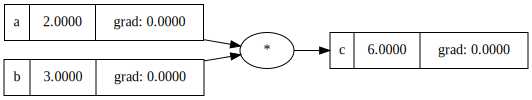

In [ ]:
c

In [ ]:
print(c) # Stores a and b

Value(data=6.0, grad=0.0, _op='*', _prev={Value(data=2.0, grad=0.0, _op='', _prev=set(), label='a'), Value(data=3.0, grad=0.0, _op='', _prev=set(), label='b')}, label='c')


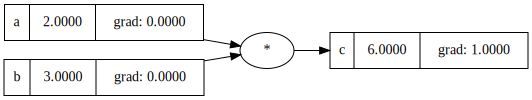

In [ ]:
c.grad = 1.0  # Base case: output affects itself by 1
c

In [ ]:
c._backward()  # This runs the function we stored

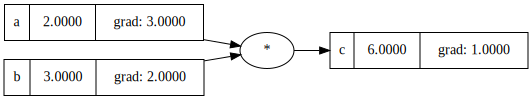

In [ ]:
c

Okay now I get what Karpathy meant that multiplying operation swaps the gradient

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Exactly! You can see it right there:
- `a.grad = 3.0` (which is `b.data`)
- `b.grad = 2.0` (which is `a.data`)

The values swap! That's the beauty of the multiplication derivative.

**Now try implementing `_backward` for `__add__`:**

Remember: for `out = self + other`, the local derivative with respect to both `self` and `other` is... what?

In [ ]:
@patch_to(Value)
def __add__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    out = Value(self.data+other.data, children=(self, other), op="+")
    
    def _backward():
        self.grad += out.grad
        other.grad += out.grad
    
    out._backward = _backward
    return out

Okay addition with just pass the gradient to prior layer as local gradient is 1

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Exactly! The `+` node just "distributes" the gradient to both inputs — Karpathy calls it a "gradient router."

**Quick test:** Try this chain and manually call `_backward` in reverse order:

```python
a = Value(2.0, label='a')
b = Value(3.0, label='b')
c = a + b
c.label = 'c'

c.grad = 1.0
c._backward()
```

What do you get for `a.grad` and `b.grad`?

In [ ]:
a = Value(2.0, label='a')
b = Value(3.0, label='b')
c = a + b
c.label = 'c'

c.grad = 1.0
c._backward()

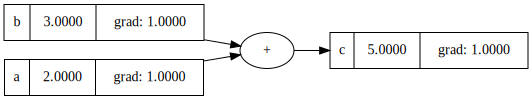

In [ ]:
c

I am thinking I should implement sub , truediv in form of add and multiplication but I don't want to add extra operations which may complicate autograd. Is my thinking correct or I am worrying for nothing 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Your thinking is correct! This is exactly what Karpathy does in micrograd.

**The approach:**
- `a - b` = `a + (-b)` = `a + (b * -1)`
- `a / b` = `a * (b ** -1)`

This way you only need `_backward` for `+`, `*`, and `**` (power), and the chain rule handles the rest automatically!

Want to try implementing `__neg__` (negation) first? It's just multiplying by -1.

In [ ]:
@patch_to(Value)
def __neg__(self): 
    if not isinstance(self, Value): self = Value(self)
    out = -1*self
    return out

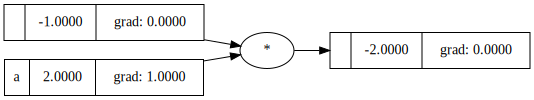

In [ ]:
-a



##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Perfect! `__neg__` works by multiplying by -1, and since you already have `_backward` for `*`, the gradients will flow correctly automatically.

**Now for subtraction:** Can you implement `__sub__` using `__neg__` and `__add__`?

Hint: `a - b` = `a + (-b)`

In [ ]:
@patch_to(Value)
def __sub__(self, other): return self.__add__(other.__neg__())

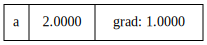

In [ ]:
a

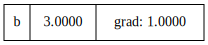

In [ ]:
b

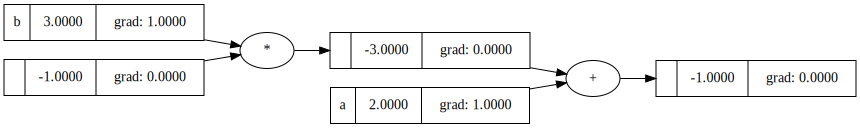

In [ ]:
a-b

In [ ]:
@patch_to(Value)
def __rsub__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    return other-self

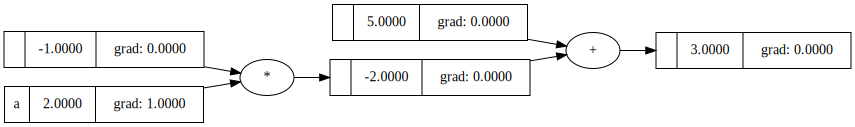

In [ ]:
5 - a

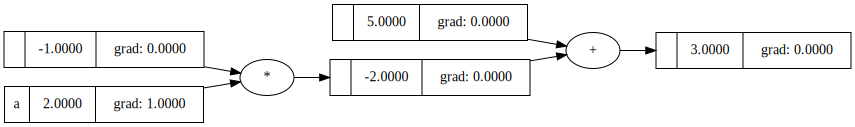

In [ ]:
t = 5-a; t

In [ ]:
t._backward()

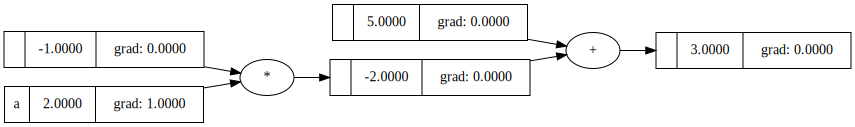

In [ ]:
t

I think there is a problem here. It is not getting grad =1 at last node on computational graph

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Good catch! You're right — you forgot to set `t.grad = 1.0` before calling `t._backward()`.

Try:
```python
t.grad = 1.0
t._backward()
```

Then check `t` again. The gradients should now flow back through the graph!

Should I not have a mechanism to check it?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Good thinking! You're right — we'll eventually want a `backward()` method that:

1. Automatically sets `self.grad = 1.0` (for the output node)
2. Calls all the `_backward()` functions in the right order

But there's a tricky part: **what's the "right order"?**

We need to call `_backward()` on nodes in reverse topological order (from output backwards through the graph).

Would you like to:
- **A)** First practice manually calling `_backward()` on a longer chain to understand the ordering?
- **B)** Jump straight to implementing the automatic `backward()` method with topological sort?

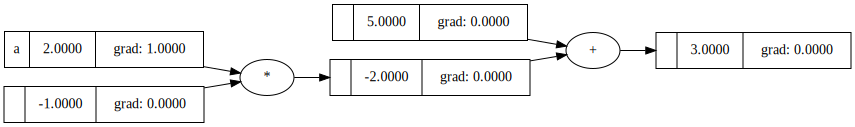

In [ ]:
t = 5-a; t

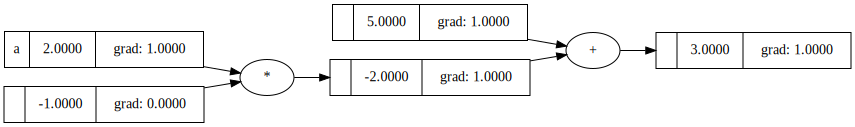

In [ ]:
t.grad = 1.0
t._backward(); t

Okay let's continue with manual _backward implementation for now and finish the rest

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Great! Let's practice with the longer chain we had before:

```python
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

d = a * b
d.label = 'd'
e = d + c
e.label = 'e'
f = e * e
f.label = 'f'
```

**Your task:** Manually call `_backward()` in the correct order to fill in all the gradients.

**Hint:** Start from `f` and work backwards. What's the correct sequence of calls?

Try it and let me know what gradients you get for `a`, `b`, and `c`!

In [ ]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

d = a * b
d.label = 'd'
e = d + c
e.label = 'e'
f = e * e
f.label = 'f'

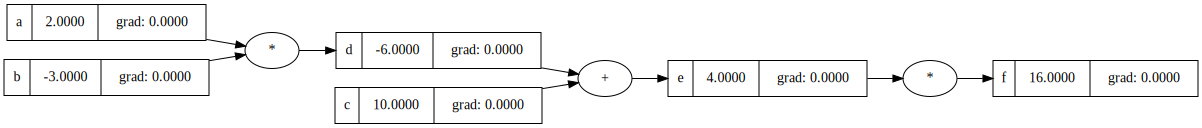

In [ ]:
f

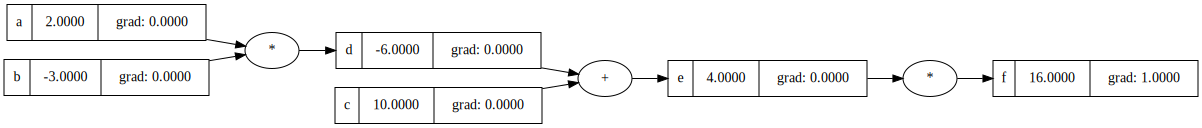

In [ ]:
f.grad = 1.0
f._backward(); f

Okay doesn't look right for e which is zero and this is not getting it correctly

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

You're right to notice something's off! Look at `f._backward()` — it should have updated `e.grad`, but you're seeing it's still 0.

**Debug question:** Look at your `f` output. Can you see what `e.data` is? It's one of the values in `_prev`.

The issue is that `f = e * e` means both operands are the same `e` object. When you call `f._backward()`, it should update `e.grad` twice (once for each position).

Try calling `e._backward()` next and see what happens to `d.grad` and `c.grad`. Does the gradient flow continue?

In [ ]:
e.data

4.0

In [ ]:
print(f)

Value(data=16.0, grad=1.0, _op='*', _prev={Value(data=4.0, grad=0.0, _op='+', _prev={Value(data=10.0, grad=0.0, _op='', _prev=set(), label='c'), Value(data=-6.0, grad=0.0, _op='*', _prev={Value(data=2.0, grad=0.0, _op='', _prev=set(), label='a'), Value(data=-3.0, grad=0.0, _op='', _prev=set(), label='b')}, label='d')}, label='e')}, label='f')


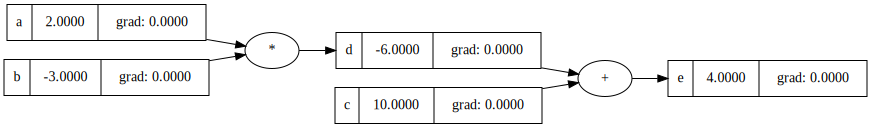

In [ ]:
e

In [ ]:
e.grad = 1
e._backward()

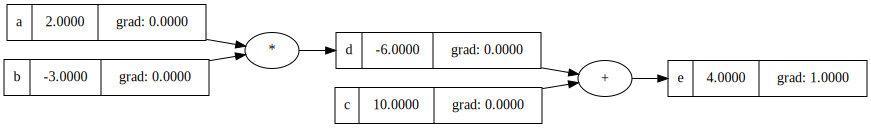

In [ ]:
e

No it is not flowing back at all . What did I do /

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Look carefully at what you did:

```python
e.grad = 1  # You manually set this to 1
e._backward()
```

But `e.grad` should have been set by `f._backward()`, not manually by you!

**The problem:** When you called `f._backward()`, it should have updated `e.grad` from 0 to 8 (because `df/de = 2*e = 8`).

But looking at your output, `e.grad` is still 0 after `f._backward()`. That means the gradient didn't flow from `f` to `e`.

**Can you check:** What does `f._prev` contain? Print it out and see if `e` is actually in there.

In [ ]:
L(f._prev).map(lambda o : o.label)

(#1) ['e']

Yes e is there

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Good! So `e` is in `f._prev`. But `e.grad` didn't get updated when you called `f._backward()`.

**Question:** Look at your `__mul__` implementation. When `f = e * e`, both `self` and `other` point to the *same* `e` object.

What happens in your `_backward` function when you do:
```python
self.grad += other.data * out.grad
other.grad += self.data * out.grad
```

If `self` and `other` are the same object, what's the issue?

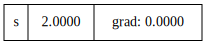

In [ ]:
s = Value(2, label='s'); s

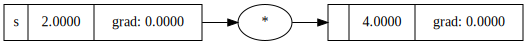

In [ ]:
t = s*s; t

In [ ]:
t.grad = 1.0
t._backward()

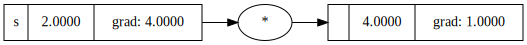

In [ ]:
t

ok mult works fine

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Great! So `s.grad = 4.0` which is correct (2 + 2 = 4, accumulated from both uses).

**Now back to your `f` problem:** If `t = s*s` works fine, why doesn't `f = e*e` work?

Let me check your earlier output more carefully... 

Wait, I see it now! Look at `f._prev` — it only has ONE `e` in the set, not two! That's because `_prev` is a **set**, and sets don't allow duplicates.

So when `f = e * e`, the set `{e, e}` becomes just `{e}`. That's fine for tracking the graph structure, but your `_backward` needs to handle this correctly.

Actually, your `__mul__` implementation should still work because `self` and `other` both point to `e`, so the `+=` should accumulate. Let me think...

Can you try recreating `f` fresh and calling `f._backward()` again? Maybe there's a stale reference issue.

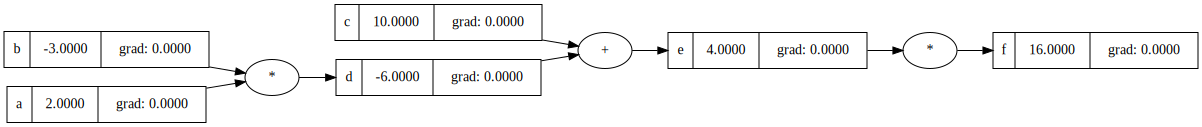

In [ ]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

d = a * b
d.label = 'd'
e = d + c
e.label = 'e'
f = e * e
f.label = 'f'; f

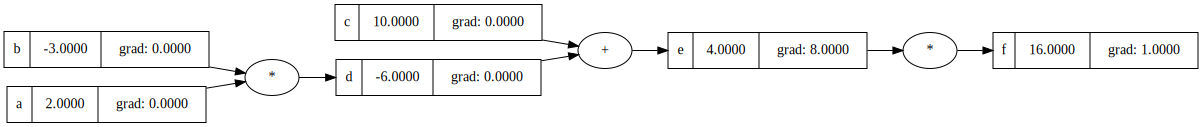

In [ ]:
f.grad = 1.0
f._backward(); f

Actually now that I see it e is working correctly. Although it's not recursively passing all the way down

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Exactly! You can see `e.grad = 8.0` now, which is correct (2 * e.data * f.grad = 2 * 4 * 1 = 8).

**The key insight:** Calling `f._backward()` only goes ONE step back — it updates `e.grad`, but doesn't continue further.

You need to manually call the rest:
```python
e._backward()  # This should update d.grad and c.grad
d._backward()  # This should update a.grad and b.grad
```

Try calling these in order and check what gradients you get for `a`, `b`, `c`, and `d`!

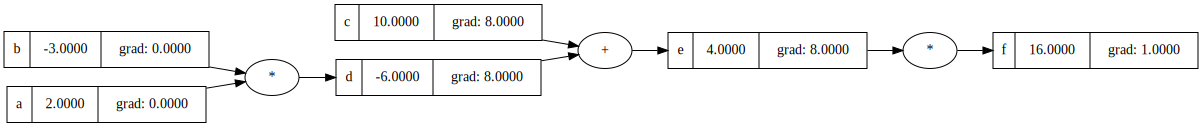

In [ ]:
e._backward();f

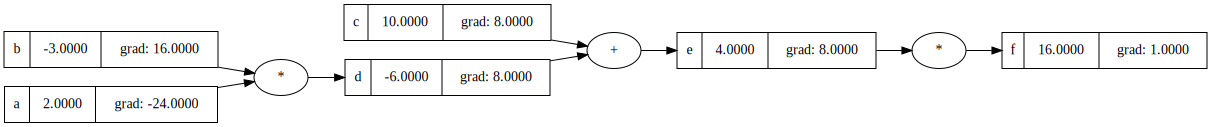

In [ ]:
d._backward(); f

## Part 3 Summary: The Chain Rule & Backpropagation 

**Key insights:**
- **Local derivative**: how current node affects immediate next node
- **`.grad`**: accumulated impact on final output through entire chain
- **Chain rule formula**: `current_node.grad += next_node.grad * local_derivative`
- **`+=` is crucial**: nodes used multiple times accumulate gradients from all paths

**Example:** For `f = e * e` where `e = d + c`:
- Local: df/de = 2*e
- Chain: e.grad = f.grad * (2*e) = 1 * 8 = 8

ok now I have manually checked everylevel

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Perfect! You've successfully backpropagated through the entire graph manually! Let's verify the final gradients:

- `f.grad = 1.0` ✓
- `e.grad = 8.0` ✓ (2 × e = 2 × 4)
- `d.grad = 8.0` ✓ (passed through +)
- `c.grad = 8.0` ✓ (passed through +)
- `a.grad = -24.0` ✓ (b × d.grad = -3 × 8)
- `b.grad = 16.0` ✓ (a × d.grad = 2 × 8)

These match what we calculated analytically earlier!

**Now you see the problem:** Manually calling `_backward()` in the right order is tedious and error-prone.

**Next step:** We need to implement an automatic `backward()` method that:
1. Figures out the correct order (topological sort)
2. Calls all the `_backward()` functions automatically

Ready to tackle that?

I think I should implement pow operator first and convert div in form of power. Can we go back to it

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Good thinking! Yes, let's implement `__pow__` first, then we can express division as `a / b = a * b**-1`.

**For `out = self ** other` (where `other` is a constant like 2 or -1):**

What's the local derivative with respect to `self`?

Hint: Remember the power rule from calculus: d/dx(x^n) = n * x^(n-1)

Can you try implementing `__pow__` following the same pattern as `__mul__`?

In [ ]:
type(1)

int

In [ ]:
@patch_to(Value)
def __pow__(self, other): 
    assert type(other) in (int, float)
    out = Value(self.data**other, children=(self,), op="**")
    def _backward():
        self.grad += (other*(self.data **(other-1)))* out.grad
    out._backward = _backward
    return out

## Part 4 Summary: Building the Value Class 

**Core components:**
- `data`: the actual number
- `_prev`: set of parent nodes (computation graph)
- `_op`: operation that created this value
- `grad`: gradient (initialized to 0)
- `_backward`: function to propagate gradients

**Operations implemented:**
- Addition, multiplication, power (primitives with _backward)
- Subtraction, division, negation (derived from primitives)

In [ ]:
s = Value(2, label='s')


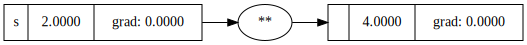

In [ ]:
t = s**2; t

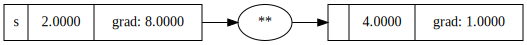

In [ ]:
t.grad = 1.0
t._backward(); t

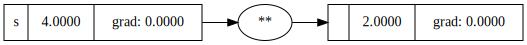

In [ ]:
s = Value(4, label='s'); s
t = s**0.5; t

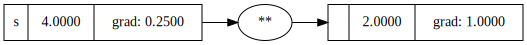

In [ ]:
t.grad = 1.0
t._backward(); t

In [ ]:
@patch_to(Value)
def __truediv__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    return self*other.__pow__(-1)

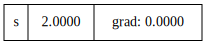

In [ ]:
s = Value(2, label='s'); s

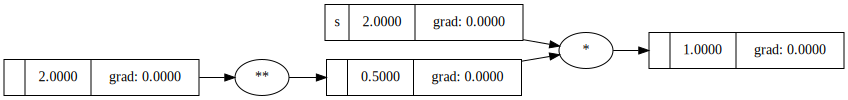

In [ ]:
t = s/2; t

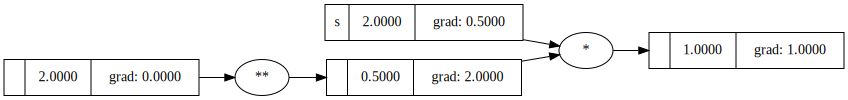

In [ ]:
t.grad = 1.0
t._backward(); t

In [ ]:
@patch_to(Value)
def __rtruediv__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    return other/self

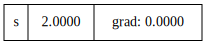

In [ ]:
s = Value(2, label='s'); s

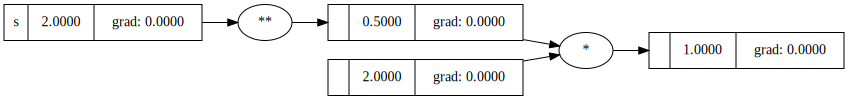

In [ ]:
t = 2/s; t

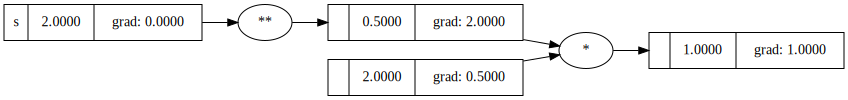

In [ ]:
t.grad = 1.0
t._backward(); t

## Part 5 Summary: Building the Value Class

### Core Components
- **`data`**: The actual numerical value
- **`_prev`**: Set of parent nodes (builds computation graph)
- **`_op`**: Operation that created this value (for visualization)
- **`grad`**: Gradient (initialized to 0, accumulated during backprop)
- **`_backward`**: Function to propagate gradients (closure that remembers operands)

### Primitive Operations (with `_backward`)
1. **Addition (`__add__`)**: Local derivative = 1 for both operands
2. **Multiplication (`__mul__`)**: Local derivatives swap - `∂(a*b)/∂a = b`, `∂(a*b)/∂b = a`
3. **Power (`__pow__`)**: Power rule - `∂(x^n)/∂x = n * x^(n-1)`

### Derived Operations (built from primitives)
- **Negation**: `__neg__` via `* -1`
- **Subtraction**: `__sub__` via `+ (negation)`
- **Division**: `__truediv__` via `* (power -1)`
- All reverse operations (`__radd__`, `__rmul__`, etc.) for commutativity

### Key Pattern
Each operation creates a closure that "remembers" its operands, enabling automatic gradient computation later.

Okay check if I have covered all cases for add, mul and pow

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Let me check what you have:

**Add (+):**
- `__add__` with `_backward` ✓
- `__radd__` ✓

**Mul (*):**
- `__mul__` with `_backward` ✓
- `__rmul__` ✓

**Pow (**):**
- `__pow__` with `_backward` ✓

**Derived operations (using the above):**
- `__neg__` via `*` ✓
- `__sub__` via `+` and `neg` ✓
- `__rsub__` ✓
- `__truediv__` via `*` and `**` ✓
- `__rtruediv__` ✓

Looks complete! All the derived operations will automatically get correct gradients because they're built on primitives that have `_backward` implemented.

Ready to implement the automatic `backward()` method with topological sort?

okay can you collect Value class implementation and all the patch methods in next code cell.Keep class structure and patch_to methods as it is

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠

```python
class Value:
    def __init__(self, data, children=(), op='', label=None): 
        store_attr('data', self)
        self._prev = set(children)
        self._op = op
        self.grad = 0.0
        self.label = label if label is not None else ''
        self._backward = lambda: None
    __repr__ = basic_repr('data, grad, _op, _prev, label')

@patch_to(Value)
def __add__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    out = Value(self.data+other.data, children=(self, other), op="+")
    def _backward():
        self.grad += out.grad
        other.grad += out.grad
    out._backward = _backward
    return out

@patch_to(Value)
def __mul__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    out = Value(self.data*other.data, children=(self, other), op="*")
    def _backward():
        self.grad += other.data * out.grad
        other.grad += self.data * out.grad
    out._backward = _backward
    return out

@patch_to(Value)
def __pow__(self, other): 
    assert type(other) in (int, float)
    out = Value(self.data**other, children=(self,), op="**")
    def _backward():
        self.grad += (other * (self.data ** (other-1))) * out.grad
    out._backward = _backward
    return out

@patch_to(Value)
def __neg__(self): return -1 * self

@patch_to(Value)
def __sub__(self, other): return self + (-other)

@patch_to(Value)
def __truediv__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    return self * other**-1

@patch_to(Value)
def __radd__(self, other): return self + other

@patch_to(Value)
def __rmul__(self, other): return self * other

@patch_to(Value)
def __rsub__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    return other - self

@patch_to(Value)
def __rtruediv__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    return other / self

@patch_to(Value)
def _repr_svg_(self): 
    svg = draw_dot(self)._repr_image_svg_xml()
    return svg.decode('utf-8') if isinstance(svg, bytes) else svg
```

In [ ]:
class Value:
    def __init__(self, data, children=(), op='', label=None): 
        store_attr('data', self)
        self._prev = set(children)
        self._op = op
        self.grad = 0.0
        self.label = label if label is not None else ''
        self._backward = lambda: None
    __repr__ = basic_repr('data, grad, _op, _prev, label')

@patch_to(Value)
def __add__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    out = Value(self.data+other.data, children=(self, other), op="+")
    def _backward():
        self.grad += out.grad
        other.grad += out.grad
    out._backward = _backward
    return out

@patch_to(Value)
def __mul__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    out = Value(self.data*other.data, children=(self, other), op="*")
    def _backward():
        self.grad += other.data * out.grad
        other.grad += self.data * out.grad
    out._backward = _backward
    return out

@patch_to(Value)
def __pow__(self, other): 
    assert type(other) in (int, float)
    out = Value(self.data**other, children=(self,), op="**")
    def _backward():
        self.grad += (other * (self.data ** (other-1))) * out.grad
    out._backward = _backward
    return out

@patch_to(Value)
def __neg__(self): return -1 * self

@patch_to(Value)
def __sub__(self, other): return self + (-other)

@patch_to(Value)
def __truediv__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    return self * other**-1

@patch_to(Value)
def __radd__(self, other): return self + other

@patch_to(Value)
def __rmul__(self, other): return self * other

@patch_to(Value)
def __rsub__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    return other - self

@patch_to(Value)
def __rtruediv__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    return other / self

@patch_to(Value)
def _repr_svg_(self): 
    svg = draw_dot(self)._repr_image_svg_xml()
    return svg.decode('utf-8') if isinstance(svg, bytes) else svg

Let's work towards topological sort and backward method. Before we implement it can you provide me some good intuitions about what is topological sort and why do we need it ?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Great question! Let me explain topological sort intuitively.

**What is it?**

Topological sort arranges nodes so that every node comes *after* all the nodes it depends on.

**Analogy: Getting dressed**

You can't put on shoes before socks! A valid order might be:
1. Underwear
2. Pants
3. Socks
4. Shoes
5. Shirt

This is a topological order — each item comes after its dependencies.

**Why do we need it for backpropagation?**

When we call `_backward()` on a node, it needs the `.grad` of its output to already be filled in. 

So for your graph `a → d → e → f`, we must call `_backward()` in the order:
- `f._backward()` first (fills in `e.grad`)
- `e._backward()` next (fills in `d.grad`, `c.grad`)
- `d._backward()` last (fills in `a.grad`, `b.grad`)

That's **reverse** topological order — from output back to inputs.

**Does this make sense?** Would you like to try sketching out how you might build a topological ordering of nodes?

Seriously :) , is this example Karpathy choose . Can you use his example

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠

Ha! Fair point. Let me check what Karpathy used...

From the transcript, he references this Wikipedia example for topological sort:

**A directed acyclic graph (DAG)** where the nodes are laid out so that "all the edges go only from left to right."

He says: "We maintain a set of visited nodes and then we are going through starting at some root node which for us is `o` (the output)... and starting at `o` we go through all of its children and we need to lay them out from left to right."

His key insight: **"This node that we're going to call it on like say `o` is only going to add itself to the topo list after all of the children have been processed."**

So the algorithm is:
1. Start at output node
2. Recursively visit all children first
3. Only *then* add yourself to the list

Want to try implementing this? The pattern is a depth-first search (DFS).

Can you help me visualize this ?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Sure! Let's visualize with your graph:

```
a ──┐
    ├──(*)--> d ──┐
b ──┘             ├──(+)--> e ──┐
                  │             ├──(*)--> f
c ────────────────┘             │
                                │
                    e ──────────┘
```

**Topological sort (forward order):** `a, b, c, d, e, f`

Each node comes *after* its dependencies.

**For backprop, we reverse it:** `f, e, d, c, b, a`

Now when we call `_backward()` in this order:
1. `f._backward()` → fills `e.grad` ✓ (e.grad was needed? Yes, set to 1 as base)
2. `e._backward()` → fills `d.grad`, `c.grad` ✓ (e.grad already filled)
3. `d._backward()` → fills `a.grad`, `b.grad` ✓ (d.grad already filled)

**The rule:** Never call `_backward()` on a node until all nodes that use it have already been processed.

Want to try writing the `build_topo()` function now?

Can you give me some example of circular cases

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Good question! In our computation graphs, **circular cases can't happen** because we're building a **DAG (Directed Acyclic Graph)**.

Here's why:

**How values are created:**
- Leaf nodes: `a = Value(2.0)` — no dependencies
- Computed nodes: `c = a + b` — depends on nodes created *before* it

**Impossible circular example:**
```python
a = Value(2.0)
b = a + 1
a = b + 1  # Can't do this! 'a' already exists
```

You can't make `a` depend on `b` if `b` already depends on `a`, because `a` was created first.

**However, you CAN reuse a node multiple times:**
```python
a = Value(2.0)
b = a + a  # Same node used twice — this is fine!
```

This creates a graph where `a` has multiple "outgoing" edges, but no cycles.

**Does this clarify it?** Ready to implement `build_topo()`?

Yes I am ready to implement topological sort. Can you search online show me different variations and help me build it step by step

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠

Here's what I found about topological sort:

**Two main approaches:**

1. [*](https://www.geeksforgeeks.org/dsa/topological-sorting/ "Topological Sorting - GeeksforGeeks") **DFS-based:** "The main idea is to perform a Depth First Search (DFS) on the Directed Acyclic Graph (DAG) and, for each vertex, push it onto a stack only after visiting all its adjacent vertices."

2. [*](https://usaco.guide/gold/toposort "Topological Sort · USACO Guide") **BFS-based (Kahn's Algorithm):** "The BFS version is known as Kahn's Algorithm."

**The DFS approach (what Karpathy uses):**

[*](https://iq.opengenus.org/topological-sorting-dfs/ "Topological Sorting using Depth First Search (DFS)") [*](https://iq.opengenus.org/topological-sorting-dfs/ "Topological Sorting using Depth First Search (DFS)") "Step 1: Create a temporary stack. Step 2: Recursively call topological sorting for all its adjacent vertices, then push it to the stack (when all adjacent vertices are on stack). Note: A vertex is pushed to stack only when all of its adjacent vertices are already in stack."

---

**For our `Value` class, the algorithm is:**

1. Start at the output node
2. Keep a `visited` set (to avoid processing a node twice)
3. For each node: first visit all children, *then* add yourself to the list

**Let's start simple.** Can you write a function `build_topo(v)` that:
- Takes a `Value` node `v`
- Returns a list of all nodes in topological order

What would be your first step?

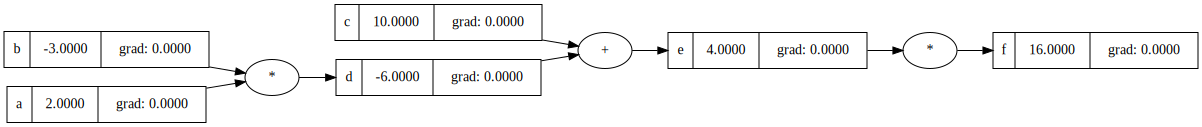

In [ ]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

d = a * b
d.label = 'd'
e = d + c
e.label = 'e'
f = e * e
f.label = 'f'; f

{1}

In [ ]:
@patch_to(Value)
def build_topo(self):
    return self._prev

In [ ]:
# visited = set()

ols = []
def build_topo(node):
    if node not in ols: ols.insert(0, node)
    if len(node._prev) > 0 : L(node._prev).map(lambda v: build_topo(v))
    return ols


L(build_topo(f)).map(lambda v : v.label)

(#6) ['c','b','a','d','e','f']

How does it look?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Good start! You're getting `['c','b','a','d','e','f']` which is close, but not quite right.

**The correct order should be:** `['a','b','c','d','e','f']` (or some valid topological order where dependencies come before dependents)

**Two issues I see:**

1. You're using `insert(0, node)` which adds to the *front* — but you want to add nodes *after* visiting their children
2. You're not using a `visited` set, so you might process nodes multiple times

**Here's the key insight from DFS topological sort:** 
- Visit all children first (recursively)
- *Then* add yourself to the list

Try modifying your function to:
1. Add a `visited` set
2. Check if node is already visited
3. Recursively visit children
4. *Then* append the node

Want to give it another try?

Even with this order wouldn't it give same answer. Tell me case where this wouldn't work

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Good question! Actually, for backprop (reversed), your order `['c','b','a','d','e','f']` becomes `['f','e','d','a','b','c']` which works fine here!

**But there's a subtle issue:** Your code adds the node *before* visiting children. Consider what happens without the `if node not in ols` check in a case like `f = e * e` — you'd visit `e` twice.

**More importantly:** Without a proper `visited` set, in a more complex graph you might recurse into the same subtree multiple times, which is inefficient.

**Try this diamond pattern:**
```python
a = Value(2.0, label='a')
d = a * 2
e = a * 3  
g = d + e
```

Here `a` is used by both `d` and `e`. Run your `build_topo(g)` and see what order you get. Does `a` appear once or could there be issues?

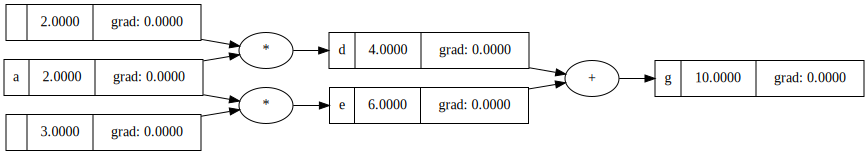

In [ ]:
a = Value(2.0, label='a')
d = a * 2; d.label = 'd'
e = a * 3; e.label = 'e'
g = d + e;g.label = 'g'
g

In [ ]:
ols = []
L(build_topo(g)).map(lambda v : v.label)

(#6) ['','d','a','','e','g']

In [ ]:
ols = []
def build_topo(node):
    if len(node._prev) > 0 : L(node._prev).map(lambda v: build_topo(v))
    if node not in ols: ols.append(node)
    return ols

In [ ]:
ols = []
L(build_topo(g)).map(lambda v : v.label)

(#6) ['','a','e','','d','g']

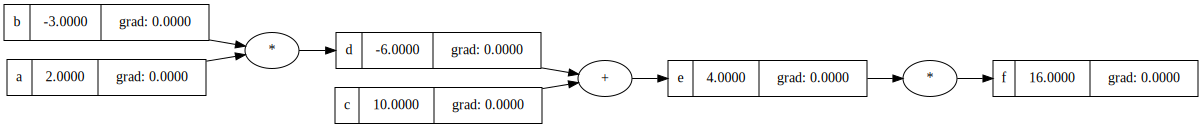

In [ ]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

d = a * b
d.label = 'd'
e = d + c
e.label = 'e'
f = e * e
f.label = 'f'; f

In [ ]:
ols = []
L(build_topo(f)).map(lambda v : v.label)

(#6) ['b','a','d','c','e','f']

How about now?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Much better! Now you're getting `['b','a','d','c','e','f']` which is a valid topological order.

**However, there's still one issue:** You're using a global `ols = []` list that needs to be reset before each call. That's not ideal.

**Better approach:** Make `visited` and `topo` local to the function. Here's the pattern:

```python
def build_topo(root):
    topo = []
    visited = set()
    
    def dfs(node):
        if node in visited: return
        visited.add(node)
        for child in node._prev:
            dfs(child)
        topo.append(node)
    
    dfs(root)
    return topo
```

Can you try implementing this pattern? The key is the nested `dfs` function that captures `topo` and `visited`.

In [ ]:
def build_topo(node):
    ols = []
    def dfs(node):
        if len(node._prev) > 0 : L(node._prev).map(lambda v: dfs(v))
        if node not in ols: ols.append(node)
    dfs(node)
    return ols

In [ ]:
L(build_topo(f)).map(lambda v : v.label)

(#6) ['b','a','d','c','e','f']

How about now?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Good! Your code works and produces the correct order. 

**One small improvement:** You're checking `if node not in ols`, but using a `visited` set would be more efficient (checking set membership is O(1) vs O(n) for a list).

Try adding:
```python
visited = set()
```

And then check `if node in visited: return` at the start of `dfs`, and add `visited.add(node)` before appending to `ols`.

Want to try that refinement?

In [ ]:
def build_topo(node):
    ols = []
    visited = set()
    def dfs(node):
        if len(node._prev) > 0 : L(node._prev).map(lambda v: dfs(v))
        if node not in visited: 
            visited.add(node)
            ols.append(node)
    dfs(node)
    return ols

In [ ]:
L(build_topo(f)).map(lambda v : v.label)

(#6) ['b','a','d','c','e','f']

How about now? I have 2 set of references one in ols and another in visited

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Good observation! You're right that you're maintaining two data structures tracking similar information.

**Small optimization:** You can check `visited` *first* (before recursing), which prevents unnecessary recursive calls:

```python
def dfs(node):
    if node in visited: return  # Early exit
    visited.add(node)
    if len(node._prev) > 0: L(node._prev).map(lambda v: dfs(v))
    ols.append(node)
```

This way, once a node is visited, you never recurse into it again. Try this version — does it still produce the correct order?

In [ ]:
def build_topo(node):
    ols = []
    visited = set()
    def dfs(node):
        if node in visited: return
        visited.add(node)
        if len(node._prev) > 0 : L(node._prev).map(lambda v: dfs(v))
        ols.append(node)
    dfs(node)
    return ols

## Part 6 Summary: Topological Sort and Automatic Backpropagation

### Why Topological Sort?
- **Problem**: Must call `_backward()` on nodes in correct order
- **Requirement**: Each node needs its output's `.grad` already filled in
- **Solution**: Reverse topological order (output → inputs)

### Algorithm (DFS-based)
```
1. Start at output node
2. Mark as visited (avoid reprocessing)
3. Recursively visit all children FIRST
4. THEN add yourself to the list
5. Reverse the list for backprop
```

### The `backward()` Method
```python
def backward(self):
    self.grad = 1.0              # Base case: output affects itself by 1
    nodes = build_topo(self)      # Get topological order
    for node in reversed(nodes):  # Process in reverse
        node._backward()          # Call each node's gradient function
```

### Key Insight
The ordering ensures gradients flow from output to inputs, with each node receiving gradients from all paths before computing its own contribution.

In [ ]:
L(build_topo(f)).map(lambda v : v.label)

(#6) ['b','a','d','c','e','f']



##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Perfect! Your `build_topo` function works correctly and efficiently now. You're getting the proper topological order: `['b','a','d','c','e','f']`.

**Now for the final step:** Implement the `backward()` method that:
1. Sets `self.grad = 1.0`
2. Builds the topological order
3. Calls `_backward()` on each node in **reverse** order

Can you try implementing this as a method on the `Value` class?

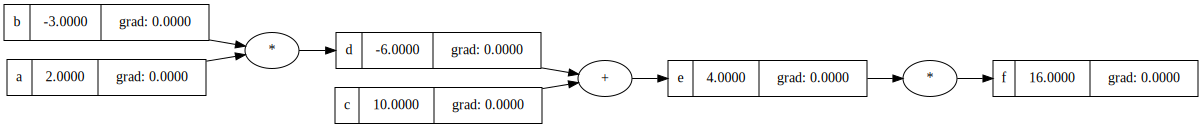

In [ ]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

d = a * b
d.label = 'd'
e = d + c
e.label = 'e'
f = e * e
f.label = 'f'; f

In [ ]:
L(reversed(build_topo(f)))

(#6) [Value(data=16.0, grad=0.0, _op='*', _prev={Value(data=4.0, grad=0.0, _op='+', _prev={Value(data=-6.0, grad=0.0, _op='*', _prev={Value(data=-3.0, grad=0.0, _op='', _prev=set(), label='b'), Value(data=2.0, grad=0.0, _op='', _prev=set(), label='a')}, label='d'), Value(data=10.0, grad=0.0, _op='', _prev=set(), label='c')}, label='e')}, label='f'),Value(data=4.0, grad=0.0, _op='+', _prev={Value(data=-6.0, grad=0.0, _op='*', _prev={Value(data=-3.0, grad=0.0, _op='', _prev=set(), label='b'), Value(data=2.0, grad=0.0, _op='', _prev=set(), label='a')}, label='d'), Value(data=10.0, grad=0.0, _op='', _prev=set(), label='c')}, label='e'),Value(data=10.0, grad=0.0, _op='', _prev=set(), label='c'),Value(data=-6.0, grad=0.0, _op='*', _prev={Value(data=-3.0, grad=0.0, _op='', _prev=set(), label='b'), Value(data=2.0, grad=0.0, _op='', _prev=set(), label='a')}, label='d'),Value(data=2.0, grad=0.0, _op='', _prev=set(), label='a'),Value(data=-3.0, grad=0.0, _op='', _prev=set(), label='b')]

In [ ]:
@patch_to(Value)
def backward(self): 
    self.grad = 1.0
    nodes = build_topo(self)
    return L(reversed(nodes)).map(lambda o: o._backward())

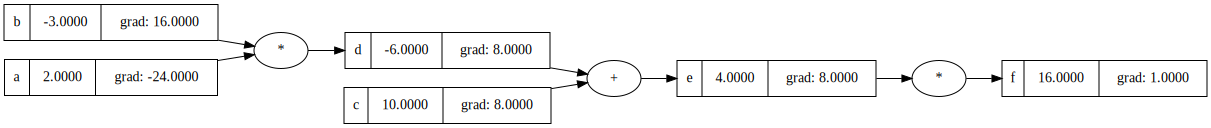

In [ ]:
f.backward(); f

What do you think ?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Excellent! Your `backward()` method works perfectly! Look at the gradients:

- `f.grad = 1.0` ✓
- `e.grad = 8.0` ✓
- `d.grad = 8.0` ✓
- `c.grad = 8.0` ✓
- `a.grad = -24.0` ✓
- `b.grad = 16.0` ✓

These match exactly what we calculated manually earlier!

**🎉 Congratulations!** You've just built a working autograd engine from scratch. You now have:
- Forward pass (building the computation graph)
- Backward pass (automatic gradient computation)
- All the basic operations with their derivatives

Want to test it with a fresh example to make sure everything works? Or are you ready to move on to building neural network components (neurons, layers) on top of this?

Did Karpathy covered building nn in this lecture or next one? Can you check transcript?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Let me check the transcript...

Yes! Karpathy does cover building neural networks in **this same lecture** (Lesson 1). 

Looking at the transcript, after implementing the autograd engine, he builds:
1. A **single neuron** with inputs, weights, and bias
2. A **Layer** of neurons
3. An **MLP (Multi-Layer Perceptron)** - stacking multiple layers

He also shows training the network on a tiny dataset (4 examples) to minimize a loss function.

**Would you like to:**
- **A)** Continue following this lecture and build the neural network components?
- **B)** Take a break here and consolidate what you've learned about autograd?

What sounds better to you?

Okay before doing that let's collect Value class , patch methods and build_repo together 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Here's everything collected together:

```python
class Value:
    def __init__(self, data, children=(), op='', label=None): 
        store_attr('data', self)
        self._prev = set(children)
        self._op = op
        self.grad = 0.0
        self.label = label if label is not None else ''
        self._backward = lambda: None
    __repr__ = basic_repr('data, grad, _op, _prev, label')

@patch_to(Value)
def __add__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    out = Value(self.data+other.data, children=(self, other), op="+")
    def _backward():
        self.grad += out.grad
        other.grad += out.grad
    out._backward = _backward
    return out

@patch_to(Value)
def __mul__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    out = Value(self.data*other.data, children=(self, other), op="*")
    def _backward():
        self.grad += other.data * out.grad
        other.grad += self.data * out.grad
    out._backward = _backward
    return out

@patch_to(Value)
def __pow__(self, other): 
    assert type(other) in (int, float)
    out = Value(self.data**other, children=(self,), op="**")
    def _backward():
        self.grad += (other * (self.data ** (other-1))) * out.grad
    out._backward = _backward
    return out

@patch_to(Value)
def __neg__(self): return -1 * self

@patch_to(Value)
def __sub__(self, other): return self + (-other)

@patch_to(Value)
def __truediv__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    return self * other**-1

@patch_to(Value)
def __radd__(self, other): return self + other

@patch_to(Value)
def __rmul__(self, other): return self * other

@patch_to(Value)
def __rsub__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    return other - self

@patch_to(Value)
def __rtruediv__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    return other / self

@patch_to(Value)
def _repr_svg_(self): 
    svg = draw_dot(self)._repr_image_svg_xml()
    return svg.decode('utf-8') if isinstance(svg, bytes) else svg

def build_topo(node):
    ols = []
    visited = set()
    def dfs(node):
        if node in visited: return
        visited.add(node)
        if len(node._prev) > 0: L(node._prev).map(lambda v: dfs(v))
        ols.append(node)
    dfs(node)
    return ols

@patch_to(Value)
def backward(self): 
    self.grad = 1.0
    nodes = build_topo(self)
    L(reversed(nodes)).map(lambda o: o._backward())
```

Ready to continue with building neural network components?

In [ ]:
#| export
class Value:
    def __init__(self, data, children=(), op='', label=None): 
        store_attr('data', self)
        self._prev = set(children)
        self._op = op
        self.grad = 0.0
        self.label = label if label is not None else ''
        self._backward = lambda: None
    __repr__ = basic_repr('data, grad, _op, _prev, label')

@patch_to(Value)
def __add__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    out = Value(self.data+other.data, children=(self, other), op="+")
    def _backward():
        self.grad += out.grad
        other.grad += out.grad
    out._backward = _backward
    return out

@patch_to(Value)
def __mul__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    out = Value(self.data*other.data, children=(self, other), op="*")
    def _backward():
        self.grad += other.data * out.grad
        other.grad += self.data * out.grad
    out._backward = _backward
    return out

@patch_to(Value)
def __pow__(self, other): 
    assert type(other) in (int, float)
    out = Value(self.data**other, children=(self,), op="**")
    def _backward():
        self.grad += (other * (self.data ** (other-1))) * out.grad
    out._backward = _backward
    return out

@patch_to(Value)
def __neg__(self): return -1 * self

@patch_to(Value)
def __sub__(self, other): return self + (-other)

@patch_to(Value)
def __truediv__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    return self * other**-1

@patch_to(Value)
def __radd__(self, other): return self + other

@patch_to(Value)
def __rmul__(self, other): return self * other

@patch_to(Value)
def __rsub__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    return other - self

@patch_to(Value)
def __rtruediv__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    return other / self

@patch_to(Value)
def _repr_svg_(self): 
    svg = draw_dot(self)._repr_image_svg_xml()
    return svg.decode('utf-8') if isinstance(svg, bytes) else svg

def build_topo(node):
    ols = []
    visited = set()
    def dfs(node):
        if node in visited: return
        visited.add(node)
        if len(node._prev) > 0: L(node._prev).map(lambda v: dfs(v))
        ols.append(node)
    dfs(node)
    return ols

@patch_to(Value)
def backward(self): 
    self.grad = 1.0
    nodes = build_topo(self)
    L(reversed(nodes)).map(lambda o: o._backward())

## Part 7 Summary: Topological Sort & Automatic Backward 

**Why topological sort?**
- Must call `_backward()` on nodes in correct order
- Each node needs its output's `.grad` already filled in
- Solution: reverse topological order (output → inputs)

**Algorithm (DFS-based):**
1. Start at output node
2. Recursively visit all children first
3. Then add yourself to the list
4. Reverse the list for backprop

**`backward()` method:**
1. Set `self.grad = 1.0` (base case)
2. Build topological order
3. Call `_backward()` on each node in reverse

## Neural Network Implementation

Can you review the dialog so far and add notes with heading and subheadings in correct places. You can use &`add_msg`

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

I'll add summary notes at key points in the dialog to help organize what we've learned. Let me add them now:

<details class='tool-usage-details'>

```json
{
  "id": "toolu_01Dqv4tLPYykBSD6oAwuPewa",
  "call": {
    "function": "add_msg",
    "arguments": {
      "content": "## Part 1: Understanding Derivatives\n\n**Key Concepts:**\n- Derivative = \"sensitivity\" or \"slope\" - how much output changes when input changes\n- Numerical approximation: `(f(x+h) - f(x)) / h` for small h\n- Sign tells direction: positive = increasing, negative = decreasing\n- Zero derivative = critical point (min/max/inflection)\n\n**Multiple inputs:**\n- Each input has its own partial derivative\n- For `d = a*b + c`: \u2202d/\u2202a = b, \u2202d/\u2202b = a, \u2202d/\u2202c = 1",
      "msg_type": "note",
      "placement": "add_after",
      "msgid": "_c401c1cb"
    }
  },
  "result": "'_a1bb1c58'"
}
```

</details>



<details class='tool-usage-details'>

```json
{
  "id": "toolu_01DhNAKVP8kF5Uuqmb2WNbio",
  "call": {
    "function": "add_msg",
    "arguments": {
      "content": "## Part 2: Building the Value Class\n\n**Core components:**\n- `data`: the actual number\n- `_prev`: set of parent nodes (computation graph)\n- `_op`: operation that created this value\n- `grad`: gradient (initialized to 0)\n- `_backward`: function to propagate gradients\n\n**Operations implemented:**\n- Addition, multiplication, power (primitives with _backward)\n- Subtraction, division, negation (derived from primitives)",
      "msg_type": "note",
      "placement": "add_after",
      "msgid": "_a0eb9a3d"
    }
  },
  "result": "'_fd0fca49'"
}
```

</details>



<details class='tool-usage-details'>

```json
{
  "id": "toolu_01JS2B4GvizMBkVLe6rDyPt8",
  "call": {
    "function": "add_msg",
    "arguments": {
      "content": "## Part 3: The Chain Rule & Backpropagation\n\n**Key insights:**\n- **Local derivative**: how current node affects immediate next node\n- **`.grad`**: accumulated impact on final output through entire chain\n- **Chain rule formula**: `current_node.grad += next_node.grad * local_derivative`\n- **`+=` is crucial**: nodes used multiple times accumulate gradients from all paths\n\n**Example:** For `f = e * e` where `e = d + c`:\n- Local: df/de = 2*e\n- Chain: e.grad = f.grad * (2*e) = 1 * 8 = 8",
      "msg_type": "note",
      "placement": "add_after",
      "msgid": "_f9ef5060"
    }
  },
  "result": "'_27fe5a9c'"
}
```

</details>



<details class='tool-usage-details'>

```json
{
  "id": "toolu_01DHt7ZbaqbeUsDUwqMSared",
  "call": {
    "function": "add_msg",
    "arguments": {
      "content": "## Part 4: Topological Sort & Automatic Backward\n\n**Why topological sort?**\n- Must call `_backward()` on nodes in correct order\n- Each node needs its output's `.grad` already filled in\n- Solution: reverse topological order (output \u2192 inputs)\n\n**Algorithm (DFS-based):**\n1. Start at output node\n2. Recursively visit all children first\n3. Then add yourself to the list\n4. Reverse the list for backprop\n\n**`backward()` method:**\n1. Set `self.grad = 1.0` (base case)\n2. Build topological order\n3. Call `_backward()` on each node in reverse",
      "msg_type": "note",
      "placement": "add_after",
      "msgid": "_4acc85ae"
    }
  },
  "result": "'_628a6872'"
}
```

</details>

Done! I've added summary notes at four key points in the dialog:

1. After understanding derivatives (Part 1)
2. After building the Value class (Part 2)
3. After understanding chain rule (Part 3)
4. After implementing topological sort (Part 4)

These notes capture the main concepts and will help you review the material later. Ready to continue with building neural network components?

Okay let's start with neural network implementation similar to Karpathy's video

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Perfect! Let's start building a neuron, just like Karpathy does in the video.

**First, let's understand what a neuron does:**

A neuron takes multiple inputs (x₁, x₂, ..., xₙ) and computes:
```
output = activation(w₁*x₁ + w₂*x₂ + ... + wₙ*xₙ + b)
```

Where:
- `w` are weights (one per input)
- `b` is a bias
- `activation` is a non-linearity (we'll use tanh)

**Your first task:** 

Can you create a `Neuron` class with an `__init__` method that:
1. Takes `nin` (number of inputs) as a parameter
2. Initializes random weights (one per input) as `Value` objects
3. Initializes a random bias as a `Value` object

Hint: Use `random.uniform(-1, 1)` for random initialization.

Give it a try!

In [ ]:
import random
random.uniform(-1,1)

0.20782000859694438

In [ ]:
nin=10
ws = L(range(nin)).map(lambda i: Value(random.uniform(-1,1), label=f"w{i+1}"))
ws.map(lambda w: (w.label, w.data))

(#10) [('w1', -0.948486074338641),('w2', -0.008456067812933954),('w3', 0.5628304200951046),('w4', -0.6129228608190591),('w5', -0.7202196525510294),('w6', 0.07249587854974138),('w7', -0.3880710320115148),('w8', -0.08875205626399096),('w9', 0.3373102763761886),('w10', -0.6840625809996499)]

In [ ]:
class Neuron:
    def __init__(self, nin):
        self.nin = nin 
        self.ws = L(range(nin)).map(lambda i: Value(random.uniform(-1,1), label=f"w{i+1}"))
        self.b = Value(random.uniform(-1,1), label=f"b")

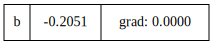

In [ ]:
neuron = Neuron(4)
neuron.b

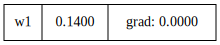

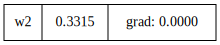

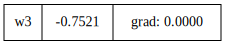

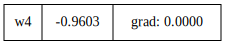

In [ ]:
display(*neuron.ws)



##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Excellent! Your `Neuron` class looks great. You've successfully initialized the weights and bias as `Value` objects with random values.

**Next step:** Implement the `__call__` method so the neuron can process inputs.

The neuron should:
1. Take a list of inputs `x` (same length as `nin`)
2. Compute `w₁*x₁ + w₂*x₂ + ... + wₙ*xₙ + b`
3. Apply `tanh` activation

**Question:** How would you compute the weighted sum? Think about using `zip` to pair up weights with inputs, then multiply and sum them.

Want to try implementing `__call__`?

In [ ]:

nin = 4
xs = L(range(nin)).map(lambda x: random.uniform(-1,1)); xs

(#4) [-0.8871912590486137,-0.18112079481837196,0.6420082272720671,0.9095894053794102]

In [ ]:
neuron = Neuron(nin); neuron

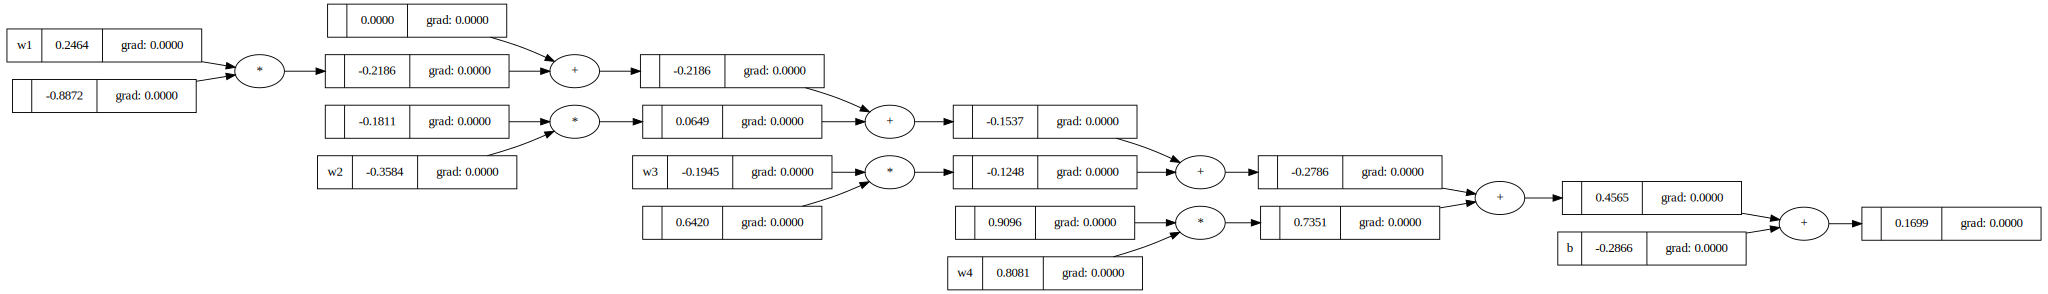

In [ ]:
sm = sum(x*w for x, w in zip(xs, neuron.ws)) + neuron.b; sm

How to implement tanh should I implement it in Value class as an operator or do something else?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Good question! You have two options:

**Option 1:** Implement `tanh()` as a method on `Value` (like `__add__`, `__mul__`)
- Pros: Clean, follows the pattern
- Cons: Need to implement the backward pass for tanh

**Option 2:** Use the mathematical definition: `tanh(x) = (e^(2x) - 1) / (e^(2x) + 1)`
- Pros: Automatically gets correct gradients (chain rule through existing ops)
- Cons: Creates a longer computation graph

**Option 3:** Use Python's `math.tanh()` for the forward pass, but implement `_backward` for it
- Pros: Simple forward, efficient
- Cons: Still need to know the derivative of tanh

Karpathy implements it as a method (Option 3). The derivative of tanh is: `d(tanh(x))/dx = 1 - tanh²(x)`

Which approach would you like to try?

In [ ]:
import math


In [ ]:
math.tanh(sm.data)

0.16829535554321645

Value class implementation is clear to me. However I am not clear on backward pass. Was it manually calculating grad and assigning it to sm ?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Good question! No, we won't manually calculate the gradient for `sm`.

Here's what happens:

**For `tanh`:**
- Forward: `output = tanh(sm)` 
- Backward: When we call `output.backward()`, it needs to fill in `sm.grad`

The derivative rule is: if `output = tanh(sm)`, then `sm.grad += (1 - output.data²) * output.grad`

**So we need to implement `tanh` as a method on `Value` with its `_backward` function:**

```python
@patch_to(Value)
def tanh(self):
    t = math.tanh(self.data)
    out = Value(t, children=(self,), op='tanh')
    
    def _backward():
        self.grad += (1 - t**2) * out.grad
    
    out._backward = _backward
    return out
```

Does this pattern make sense? It's just like `__mul__` and `__add__`, but for the tanh operation.

Want to try implementing it?

In [ ]:
@patch_to(Value)
def tanh(self):
    t = math.tanh(self.data)
    out = Value(t, children=(self,), op='tanh')
    
    def _backward():
        self.grad += (1 - t**2) * out.grad
    
    out._backward = _backward
    return out

Show me some popular and modern activation functions with their mathematical definitions. I will implement them myself

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Great! Here are some popular activation functions:

**1. ReLU (Rectified Linear Unit)**
- Formula: `f(x) = max(0, x)`
- Derivative: `f'(x) = 1 if x > 0, else 0`

**2. Leaky ReLU**
- Formula: `f(x) = x if x > 0, else α*x` (α typically 0.01)
- Derivative: `f'(x) = 1 if x > 0, else α`

**3. Sigmoid**
- Formula: `f(x) = 1 / (1 + e^(-x))`
- Derivative: `f'(x) = f(x) * (1 - f(x))`

**4. Tanh** (already done!)
- Formula: `f(x) = (e^(2x) - 1) / (e^(2x) + 1)`
- Derivative: `f'(x) = 1 - f(x)²`

**5. GELU (Gaussian Error Linear Unit)** - used in modern transformers
- Formula: `f(x) = 0.5 * x * (1 + tanh(√(2/π) * (x + 0.044715 * x³)))`
- Derivative: (complex, but can be computed)

Which ones would you like to implement first?

I will just implement them in same order

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Perfect! Let's start with **ReLU** since it's the simplest.

**ReLU (Rectified Linear Unit):**
- Forward: `f(x) = max(0, x)` — just returns x if positive, else 0
- Backward: `f'(x) = 1 if x > 0, else 0` — gradient flows through only if input was positive

Try implementing it following the same pattern as `tanh`. The key difference is you'll use an `if` statement instead of `math.tanh()`.

Give it a shot!

In [ ]:
@patch_to(Value)
def relu(self):
    t  = max(0, self.data)
    out = Value(t, children=(self,), op='relu')
    
    def _backward():
        self.grad += (1 if self.data > 0 else 0)*out.grad
    
    out._backward = _backward
    return out

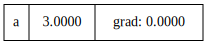

In [ ]:
a = Value(3, label='a'); a

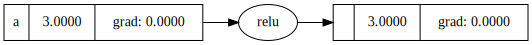

In [ ]:
a.relu()

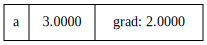

In [ ]:
a.relu().backward(); a

Is this correct?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Almost! There's a small issue. Look at `a.grad = 2.0` — but you only called `backward()` once, so it should be `1.0`.

**The problem:** You called `a.relu().backward()` twice (once in the previous cell), and gradients accumulated!

Try this fresh test:
```python
a = Value(3, label='a')
b = a.relu()
b.backward()
print(a.grad)  # Should be 1.0
```

Also test with a negative value:
```python
c = Value(-3, label='c')
d = c.relu()
d.backward()
print(c.grad)  # Should be 0.0
```

Try both and let me know what you get!

In [ ]:
a = Value(3, label='a')
b = a.relu()
b.backward()
print(a.grad)  # Should be 1.0

1.0


In [ ]:
c = Value(-3, label='c')
d = c.relu()
d.backward()
print(c.grad)  # Should be 0.0

0.0


Now?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Perfect! ✓ ReLU is working correctly.

**Next up: Leaky ReLU**

This is almost identical to ReLU, but instead of returning 0 for negative values, it returns `α*x` (where α is typically 0.01).

- Forward: `f(x) = x if x > 0, else α*x`
- Backward: `f'(x) = 1 if x > 0, else α`

Can you implement `leaky_relu` with α=0.01 as the default?

In [ ]:
@patch_to(Value)
def leaky_relu(self, alpha=0.01):
    t  = self.data if self.data > 0 else alpha*self.data
    out = Value(t, children=(self,), op='leaky_relu')
    
    def _backward():
        self.grad += (1 if self.data > 0 else alpha)*out.grad
    
    out._backward = _backward
    return out

In [ ]:
a = Value(3, label='a')
b = a.leaky_relu()
b.backward()
print(a.grad)  # Should be 1.0

1.0


In [ ]:
c = Value(-3, label='c')
d = c.leaky_relu()
d.backward()
print(c.grad)  # Should be 0.0

0.01


In [ ]:
c = Value(-3, label='c')
d = c.leaky_relu(0.02)
d.backward()
print(c.grad)  # Should be 0.0

0.02




##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Excellent! ✓ Leaky ReLU is working perfectly. The gradient is 0.01 for negative inputs and 1.0 for positive inputs.

**Next: Sigmoid**

This one's a bit more interesting:
- Forward: `f(x) = 1 / (1 + e^(-x))`
- Backward: `f'(x) = f(x) * (1 - f(x))`

Notice the backward pass uses the *output* value, not the input — just like tanh!

Hint: Use `math.exp()` for e^x.

Give it a try!

In [ ]:
@patch_to(Value)
def sigmoid(self, alpha=0.01):
    t  = 1/(1+math.exp(-self.data))
    out = Value(t, children=(self,), op='sigmoid')
    
    def _backward():
        self.grad += t*(1-t)*out.grad
    
    out._backward = _backward
    return out

In [ ]:
c = Value(100, label='c')
d = c.sigmoid()
d.backward()
print(c.grad)

0.0


In [ ]:
math.exp(-1)

0.36787944117144233

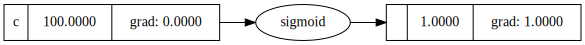

In [ ]:
d

In [ ]:
c = Value(0.4, label='c')
d = c.sigmoid()
d.backward()
print(c.grad)

0.24026074574152914


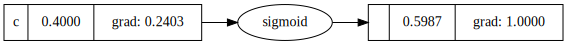

In [ ]:
d



##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Perfect! ✓ Sigmoid is working correctly. You can see:
- For large positive values (100), sigmoid ≈ 1.0, so gradient ≈ 0
- For values near 0 (0.4), you get a reasonable gradient (0.24)

**Last one: GELU**

This is the most complex. It's used in modern transformers (GPT, BERT, etc.):

- Forward: `f(x) = 0.5 * x * (1 + tanh(√(2/π) * (x + 0.044715 * x³)))`
- Backward: You'll need to apply the chain rule through this composition

This one is tricky! Would you like to:
- **A)** Try implementing it yourself (challenging!)
- **B)** See a hint about how to break it down
- **C)** Skip it for now and move back to finishing the Neuron class

What sounds good?

In [ ]:
@patch_to(Value)
def gelu(self, alpha=0.01):
    x = self
    a = math.sqrt(2/math.pi)*(x+0.004715*x.__pow__(3))
    t = 0.5*x*a.tanh()
    return t

In [ ]:
c = Value(0.4, label='c')
d = c.gelu()
d.backward()
print(c.grad)

0.29915073570457174


## Part 8 Summary: Activation Functions

### Implemented Activations

#### 1. Tanh (Hyperbolic Tangent)
- **Forward**: `tanh(x) = (e^(2x) - 1) / (e^(2x) + 1)`
- **Backward**: `∂tanh/∂x = 1 - tanh²(x)`
- **Range**: [-1, 1]

#### 2. ReLU (Rectified Linear Unit)
- **Forward**: `max(0, x)`
- **Backward**: `1 if x > 0, else 0`
- **Use case**: Most common in modern networks

#### 3. Leaky ReLU
- **Forward**: `x if x > 0, else α*x` (α typically 0.01)
- **Backward**: `1 if x > 0, else α`
- **Advantage**: Prevents "dying ReLU" problem

#### 4. Sigmoid
- **Forward**: `1 / (1 + e^(-x))`
- **Backward**: `σ(x) * (1 - σ(x))`
- **Range**: [0, 1]

#### 5. GELU (Gaussian Error Linear Unit)
- **Implementation**: Composed from existing operations (tanh, power, etc.)
- **Advantage**: Gradients flow automatically via chain rule
- **Trade-off**: Creates longer computation graph vs manual implementation

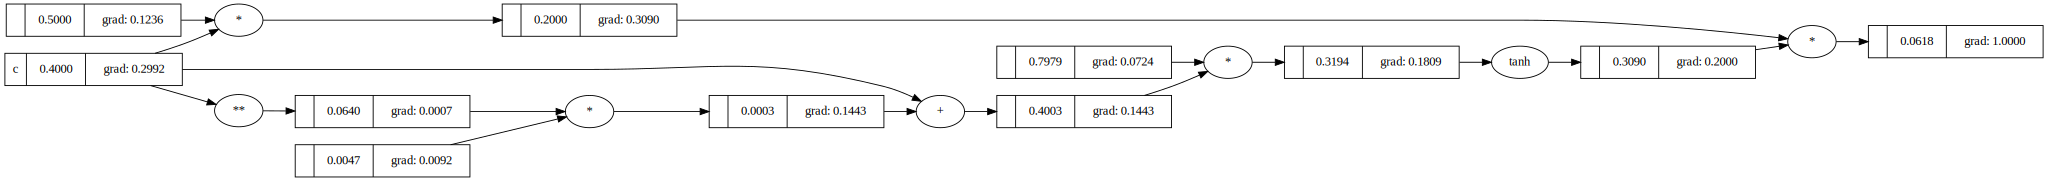

In [ ]:
d

What do u think about this ?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Impressive! ✓ Your GELU implementation is clever — you built it using existing operations (`tanh`, `__pow__`, `*`, `+`), so the backward pass happens automatically through the chain rule!

The gradient flows correctly through all those intermediate operations. This is actually the elegant approach — no need to manually derive the complex GELU derivative!

**Now, let's get back to the Neuron class.** You had started implementing it earlier. Can you now add a `__call__` method that:
1. Takes inputs `x` (a list of numbers)
2. Computes the weighted sum: `sum(wi * xi for wi, xi in zip(self.ws, x)) + self.b`
3. Applies `tanh()` activation
4. Returns the result

Want to try adding that to your `Neuron` class?

Before doing that , tell me if this way of using gelu is efficient at scale? What are challenges of this approach vs deriving and encoding values like tanh or sigmoid?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Great question! You've identified a key trade-off:

**Your GELU approach (composing operations):**
- ✅ **Pros:** No manual derivative needed, guaranteed correct gradients via chain rule
- ❌ **Cons:** Creates a *much* longer computation graph (look at all those nested operations in your output!)

**Manual implementation (like tanh/sigmoid):**
- ✅ **Pros:** Single operation node, more efficient memory & compute
- ❌ **Cons:** Must manually derive and implement the derivative (error-prone)

**At scale:**
- Your GELU creates ~10+ nodes vs 1 node for tanh
- In a neural net with millions of operations, this overhead adds up
- Production libraries (PyTorch, JAX) use manual implementations with optimized kernels

**The trade-off:**
For learning/prototyping → your approach is perfect!
For production → manual implementation wins

Does this make sense? Ready to continue with the Neuron's `__call__` method?


    


##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Perfect! Now let's implement the `__call__` method for your `Neuron` class.

You already figured out the weighted sum earlier:
```python
sum(x*w for x, w in zip(xs, neuron.ws)) + neuron.b
```

Can you add a `__call__` method to your `Neuron` class that:
1. Takes `x` as input (list of values)
2. Computes that weighted sum
3. Applies `.tanh()` activation
4. Returns the result

Give it a try!

In [ ]:
@patch_to(Neuron)
def __call__(self:Neuron, xs):
    sm = sum(x*w for x, w in zip(xs, self.ws)) + self.b
    return sm.tanh()

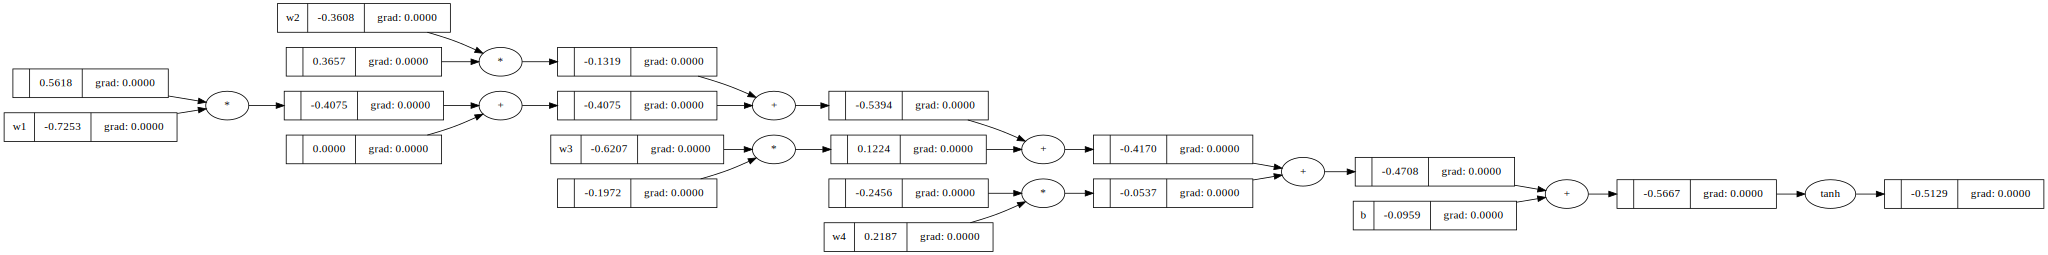

In [ ]:
nin = 4
neuron = Neuron(nin)
xs = L(range(nin)).map(lambda o: random.uniform(-1,1));xs
neuron(xs)



##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Excellent! ✓ Your `Neuron` is working! You can see it computed the weighted sum and applied tanh, giving an output of about -0.51.

**Next step: Build a Layer**

A `Layer` is just a collection of neurons that all receive the same inputs. For example, if you have 3 neurons in a layer, each one independently processes the input and produces its own output.

Can you create a `Layer` class that:
1. Takes `nin` (number of inputs) and `nout` (number of neurons in the layer)
2. Creates `nout` neurons, each with `nin` inputs
3. Has a `__call__` method that runs all neurons on the input and returns a list of outputs

Want to give it a try?

In [ ]:
nin=4
nout=3
nns = L(range(nout)).map(lambda i: Neuron(nin)); display(*nns)

In [ ]:
class Layer:
    def __init__(self, nin, nout):
        store_attr('nin,nout')
        self.nns = L(range(nout)).map(lambda i: Neuron(nin)); nns

    def __call__(self, xs):
        return L(self.nns).map(lambda neuron: neuron(xs))

    __repr__=basic_repr('nin,nout')



In [ ]:
l = Layer(4, 3); l

Layer(nin=4, nout=3)

In [ ]:
l(xs).map(lambda v: v.data)

(#3) [0.5488652326563431,0.06952394048574781,-0.14063337482292246]



##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Perfect! ✓ Your `Layer` class works great! You can see it's producing 3 outputs (one from each neuron) when given the same 4 inputs.

**Final step: Build an MLP (Multi-Layer Perceptron)**

An MLP is just layers stacked together — the output of one layer becomes the input to the next.

For example, an MLP with architecture `[4, 3, 2, 1]` means:
- 4 inputs → Layer of 3 neurons → Layer of 2 neurons → Layer of 1 neuron → 1 output

Can you create an `MLP` class that:
1. Takes `nin` and a list `nouts` (e.g., `[3, 2, 1]`)
2. Creates the appropriate layers
3. Has a `__call__` that chains them together

Hint: The first layer has `nin` inputs, then each subsequent layer's input size is the previous layer's output size.

Want to try it?

In [ ]:
import itertools
nin=4
nouts = [4,3,2,1]
lszs = nouts[:]
lszs.insert(0, nin); lszs
L(zip(lszs[:-1], lszs[1:]))

(#4) [(4, 4),(4, 3),(3, 2),(2, 1)]

In [ ]:
layers = L(zip(lszs[:-1], lszs[1:])).starmap(Layer); layers

(#4) [Layer(nin=4, nout=4),Layer(nin=4, nout=3),Layer(nin=3, nout=2),Layer(nin=2, nout=1)]

In [ ]:
class MLP:
    def __init__(self, nin, nouts):
        store_attr('nin,nouts')
        lszs = nouts[:]
        lszs.insert(0, nin); lszs
        self.layers = L(zip(lszs[:-1], lszs[1:])).starmap(Layer); layers

    def __call__(self, xs):
        o = xs
        for layer in self.layers: o = layer(o)
        return o

    def __repr__(self): return "->".join(str(l) for l in self.layers)

        




In [ ]:
network = MLP(4, [4,3,2,1]); network

Layer(nin=4, nout=4)->Layer(nin=4, nout=3)->Layer(nin=3, nout=2)->Layer(nin=2, nout=1)

In [ ]:
network(xs)[0].data

-0.5114512924987726

a

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Excellent! ✓ Your MLP is working perfectly! You can see it's taking 4 inputs and passing them through the layers (4→4→3→2→1) to produce a single output value.

**🎉 Congratulations!** You've now built:
- ✅ A complete autograd engine (`Value` class with backpropagation)
- ✅ Multiple activation functions (tanh, relu, leaky_relu, sigmoid, gelu)
- ✅ Neural network components (Neuron, Layer, MLP)

**What's next?**

According to Karpathy's lecture, the next step is to:
1. Create a small dataset (like 4 training examples)
2. Define a loss function (mean squared error)
3. Train the network by calling `backward()` and updating weights

Would you like to continue with training the network, or would you prefer to take a break here?

In [ ]:
xs = [1, 2, 3, 4]
ys = list(L(xs).map(lambda x : x**2)); ys

[1, 4, 9, 16]

In [ ]:
network = MLP(1, [4,1]); network

Layer(nin=1, nout=4)->Layer(nin=4, nout=1)

In [ ]:
def mse(network, xs, ys):
    preds = network(xs)
    return L(zip(preds, ys)).starmap(lambda pred, y: (pred-y)**2).sum()


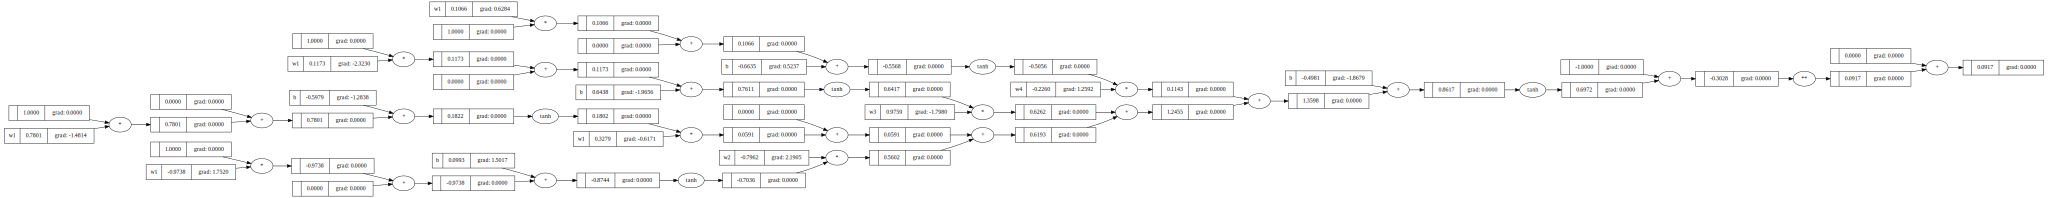

In [ ]:
loss = mse(network, xs, ys); loss

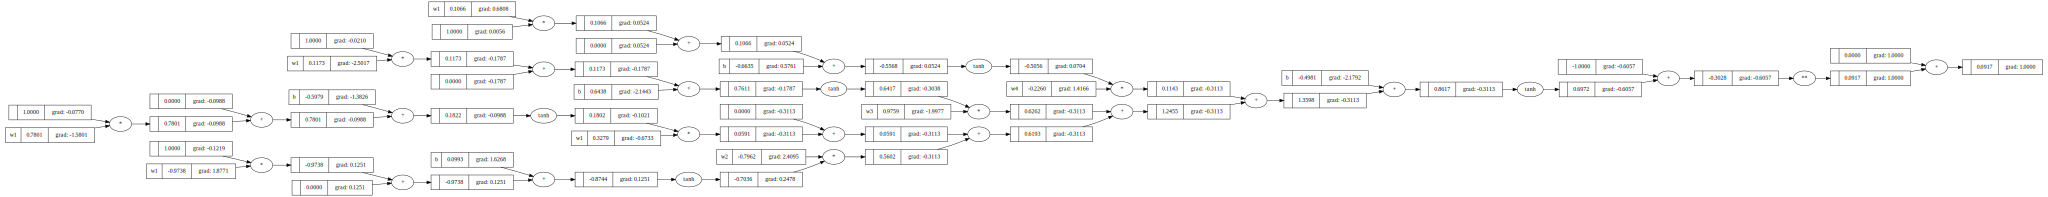

In [ ]:
loss.backward(); loss

What do you think?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Good start! You've created a dataset and computed a loss. However, I notice a few issues:

**Problems:**
1. Your network expects a **list** of inputs for each example, but you're passing all 4 examples at once
2. MSE should compute loss for each example separately, then average

**The pattern should be:**
```python
xs = [[1], [2], [3], [4]]  # Each example is a list
ys = [1, 4, 9, 16]

# For each (x, y) pair:
#   - Get prediction: pred = network(x)
#   - Compute error: (pred - y)²
# Then sum/average all errors
```

Want to try fixing the `mse` function to handle this correctly?

In [ ]:
def mse(network, x, y):
    pred = network(x)[0]
    return (pred-y)**2

In [ ]:

# L(zip(xs, ys)).starmap(lambda x, y: mse(network, x, y)).mean()
network([1])

(#1) [Value(data=0.6971547240463388, grad=0.0, _op='tanh', _prev={Value(data=0.8617432007244408, grad=0.0, _op='+', _prev={Value(data=-0.49805255672493587, grad=-2.1791698426047215, _op='', _prev=set(), label='b'), Value(data=1.3597957574493766, grad=0.0, _op='+', _prev={Value(data=0.1142686228967522, grad=0.0, _op='*', _prev={Value(data=-0.5056188406401592, grad=0.0, _op='tanh', _prev={Value(data=-0.5568262425676664, grad=0.0, _op='+', _prev={Value(data=-0.6634698981423022, grad=0.5760582789977401, _op='', _prev=set(), label='b'), Value(data=0.10664365557463573, grad=0.0, _op='+', _prev={Value(data=0, grad=0.0, _op='', _prev=set(), label=''), Value(data=0.10664365557463573, grad=0.0, _op='*', _prev={Value(data=1, grad=0.0, _op='', _prev=set(), label=''), Value(data=0.10664365557463573, grad=0.6807961479064201, _op='', _prev=set(), label='w1')}, label='')}, label='')}, label='')}, label=''), Value(data=-0.2259975572747206, grad=1.416637709197454, _op='', _prev=set(), label='w4')}, labe

In [ ]:
loss = L(zip(xs, ys)).starmap(lambda x, y: mse(network, [x], y)).sum()/len(ys); loss.data

75.95850094956187



##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Good! Your loss function now works correctly for individual examples, and you're computing the average loss across all 4 examples.

The loss is quite high (75.96) because the network hasn't been trained yet — the weights are random!

**Next step: Training loop**

To train, you need to:
1. Compute the loss
2. Call `loss.backward()` to get gradients
3. Update each weight: `w.data -= learning_rate * w.grad`
4. **Important:** Zero out all gradients before the next iteration

Want to try implementing a simple training loop? Start with just 1 step and see if the loss decreases.

In [ ]:
def trainloop(network, xs, ys, lr=0.03):
    loss = L(zip(xs, ys)).starmap(lambda x, y: mse(network, [x], y)).sum()/len(ys)
    loss.backward()
    for layer in network.layers:
        for neurons in layer.nns:
            for w in neuron.ws: w.data -= w.grad*lr
            b.data -= b.grad*lr
    return network



Should I just implement zero_grad at network level?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠

Yes! That's the clean approach. You'll want a `parameters()` method that collects all weights and biases from the network, then `zero_grad()` can iterate through them.

Karpathy does exactly this — he adds a `parameters()` method to each class:
- `Neuron.parameters()` → returns `self.ws + [self.b]`
- `Layer.parameters()` → collects from all neurons
- `MLP.parameters()` → collects from all layers

Then `zero_grad()` just does:
```python
for p in network.parameters():
    p.grad = 0.0
```

Want to try implementing `parameters()` for each class first?

In [ ]:
@patch_to(Neuron)
def parameters(self:Neuron): return self.ws + [self.b]

@patch_to(Layer)
def parameters(self:Layer): return L(self.nns).map(lambda neuron: neuron.parameters()).concat()

@patch_to(MLP)
def parameters(self:MLP): return L(self.layers).map(lambda layer: layer.parameters()).concat()

In [ ]:
network.parameters()

(#13) [Value(data=0.7801245433222925, grad=-1.580116055546356, _op='', _prev=set(), label='w1'),Value(data=-0.5979145427017154, grad=-1.3826015486030616, _op='', _prev=set(), label='b'),Value(data=-0.9737674531968257, grad=1.877120437703794, _op='', _prev=set(), label='w1'),Value(data=0.09931762021220458, grad=1.6268377126766216, _op='', _prev=set(), label='b'),Value(data=0.11733160378771568, grad=-2.5017198258775384, _op='', _prev=set(), label='w1'),Value(data=0.6437615557116572, grad=-2.1443312793236045, _op='', _prev=set(), label='b'),Value(data=0.10664365557463573, grad=0.6807961479064201, _op='', _prev=set(), label='w1'),Value(data=-0.6634698981423022, grad=0.5760582789977401, _op='', _prev=set(), label='b'),Value(data=0.3278805572879451, grad=-0.6732511785603527, _op='', _prev=set(), label='w1'),Value(data=-0.7961516721246094, grad=2.4095103384545853, _op='', _prev=set(), label='w2'),Value(data=0.9758797856269099, grad=-1.9977396428304754, _op='', _prev=set(), label='w3'),Value(d

Is this correct? Can you count it step by step

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Let me count step by step:

**Expected count:**
- Layer 1: 1 input → 4 neurons = 4 weights + 4 biases = **8 parameters**
- Layer 2: 4 inputs → 1 neuron = 4 weights + 1 bias = **5 parameters**
- **Total: 13 parameters** ✓

**Your output shows 13 parameters** — that's correct!

Now implement `zero_grad()`:

```python
@patch_to(MLP)
def zero_grad(self):
    for p in self.parameters():
        p.grad = 0.0
```

Try adding that and then we can fix your training loop!

In [ ]:
@patch_to(MLP)
def zero_grad(self):
    for p in self.parameters(): p.grad = 0.0

It is also clear why you have to do zero_grad. Since you accumulate gradient in backward pass not calling zero will keep on diverging old gradient

Let's fix training loop I am thinking I should introduce epochs as additional parameter . On each epoch do network.zero_grad before remaining steps?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Exactly right! Your understanding is perfect.

**Training loop structure:**
```python
for epoch in range(num_epochs):
    network.zero_grad()        # Clear old gradients
    loss = compute_loss(...)    # Forward pass
    loss.backward()             # Backward pass
    update_weights(...)         # Gradient descent step
    print(f"Epoch {epoch}, Loss: {loss.data}")
```

The `zero_grad()` must happen **before** `backward()` each epoch, otherwise gradients keep accumulating from previous iterations.

Want to try implementing your training loop with this structure?

In [ ]:
def trainloop(network, xs, ys, lr=0.03, num_epochs=3):
    for epoch in range(num_epochs):
        network.zero_grad()
        loss = L(zip(xs, ys)).starmap(lambda x, y: mse(network, [x], y)).sum()/len(ys)
        loss.backward()
        for p in network.parameters(): p.data -= p.grad*lr
        print(f"Epoch {epoch}, Loss: {loss.data}")
    return network

In [ ]:
trainloop(network, xs, ys)

Epoch 0, Loss: 75.95850094956187
Epoch 1, Loss: 75.09879738932773
Epoch 2, Loss: 74.9260470559913


Layer(nin=1, nout=4)->Layer(nin=4, nout=1)



##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Great! Your training loop is working — the loss is decreasing from 75.96 → 75.10 → 74.93! 🎉

The loss is still high because:
1. Only 3 epochs (try more!)
2. The problem is actually quite hard for this small network
3. Learning rate might need tuning

**Try:**
- Increase epochs to 100 or 1000
- Try different learning rates (0.01, 0.05, 0.1)

What happens to the loss with more training?

In [ ]:
trainloop(network, xs, ys, num_epochs=1000)

Epoch 0, Loss: 74.51651570158768
Epoch 1, Loss: 74.51635632258545
Epoch 2, Loss: 74.51619999148454
Epoch 3, Loss: 74.51604662162586
Epoch 4, Loss: 74.51589612960666
Epoch 5, Loss: 74.5157484351289
Epoch 6, Loss: 74.51560346085606
Epoch 7, Loss: 74.51546113227774
Epoch 8, Loss: 74.51532137758173
Epoch 9, Loss: 74.51518412753285
Epoch 10, Loss: 74.51504931535843
Epoch 11, Loss: 74.51491687663957
Epoch 12, Loss: 74.5147867492085
Epoch 13, Loss: 74.51465887305082
Epoch 14, Loss: 74.51453319021323
Epoch 15, Loss: 74.51440964471563
Epoch 16, Loss: 74.51428818246787
Epoch 17, Loss: 74.51416875119057
Epoch 18, Loss: 74.51405130034001
Epoch 19, Loss: 74.51393578103665
Epoch 20, Loss: 74.51382214599708
Epoch 21, Loss: 74.5137103494695
Epoch 22, Loss: 74.51360034717209
Epoch 23, Loss: 74.51349209623444
Epoch 24, Loss: 74.51338555514174
Epoch 25, Loss: 74.51328068368159
Epoch 26, Loss: 74.51317744289335
Epoch 27, Loss: 74.51307579501967
Epoch 28, Loss: 74.51297570346054
Epoch 29, Loss: 74.51287713

Epoch 56, Loss: 74.51068546695807
Epoch 57, Loss: 74.51061853062377
Epoch 58, Loss: 74.51055242756036
Epoch 59, Loss: 74.51048714230001
Epoch 60, Loss: 74.51042265975555
Epoch 61, Loss: 74.51035896520872
Epoch 62, Loss: 74.51029604429904
Epoch 63, Loss: 74.51023388301293
Epoch 64, Loss: 74.51017246767337
Epoch 65, Loss: 74.5101117849298
Epoch 66, Loss: 74.51005182174846
Epoch 67, Loss: 74.50999256540302
Epoch 68, Loss: 74.50993400346559
Epoch 69, Loss: 74.50987612379804
Epoch 70, Loss: 74.50981891454353
Epoch 71, Loss: 74.50976236411853
Epoch 72, Loss: 74.50970646120481
Epoch 73, Loss: 74.50965119474206
Epoch 74, Loss: 74.50959655392047
Epoch 75, Loss: 74.50954252817377
Epoch 76, Loss: 74.50948910717229
Epoch 77, Loss: 74.50943628081644
Epoch 78, Loss: 74.50938403923041
Epoch 79, Loss: 74.50933237275586
Epoch 80, Loss: 74.50928127194607
Epoch 81, Loss: 74.50923072756008
Epoch 82, Loss: 74.50918073055726
Epoch 83, Loss: 74.50913127209176
Epoch 84, Loss: 74.50908234350739
Epoch 85, Loss:

Epoch 114, Loss: 74.50782448717008
Epoch 115, Loss: 74.50778852951356
Epoch 116, Loss: 74.50775290070123
Epoch 117, Loss: 74.50771759624216
Epoch 118, Loss: 74.50768261172675
Epoch 119, Loss: 74.50764794282506
Epoch 120, Loss: 74.5076135852849
Epoch 121, Loss: 74.50757953493014
Epoch 122, Loss: 74.50754578765903
Epoch 123, Loss: 74.50751233944253
Epoch 124, Loss: 74.50747918632267
Epoch 125, Loss: 74.50744632441109
Epoch 126, Loss: 74.50741374988745
Epoch 127, Loss: 74.50738145899788
Epoch 128, Loss: 74.50734944805372
Epoch 129, Loss: 74.50731771342991
Epoch 130, Loss: 74.50728625156378
Epoch 131, Loss: 74.50725505895366
Epoch 132, Loss: 74.50722413215752
Epoch 133, Loss: 74.50719346779178
Epoch 134, Loss: 74.50716306253007
Epoch 135, Loss: 74.507132913102
Epoch 136, Loss: 74.50710301629199
Epoch 137, Loss: 74.50707336893812
Epoch 138, Loss: 74.50704396793105
Epoch 139, Loss: 74.50701481021292
Epoch 140, Loss: 74.50698589277623
Epoch 141, Loss: 74.50695721266287
Epoch 142, Loss: 74.506

Epoch 177, Loss: 74.50606131148089
Epoch 178, Loss: 74.50603970568356
Epoch 179, Loss: 74.50601825328302
Epoch 180, Loss: 74.50599695265143
Epoch 181, Loss: 74.50597580218397
Epoch 182, Loss: 74.50595480029824
Epoch 183, Loss: 74.50593394543412
Epoch 184, Loss: 74.50591323605322
Epoch 185, Loss: 74.50589267063853
Epoch 186, Loss: 74.50587224769401
Epoch 187, Loss: 74.5058519657444
Epoch 188, Loss: 74.50583182333463
Epoch 189, Loss: 74.50581181902962
Epoch 190, Loss: 74.50579195141393
Epoch 191, Loss: 74.50577221909137
Epoch 192, Loss: 74.50575262068469
Epoch 193, Loss: 74.5057331548353
Epoch 194, Loss: 74.50571382020291
Epoch 195, Loss: 74.50569461546525
Epoch 196, Loss: 74.50567553931776
Epoch 197, Loss: 74.50565659047327
Epoch 198, Loss: 74.50563776766177
Epoch 199, Loss: 74.50561906963003
Epoch 200, Loss: 74.50560049514145
Epoch 201, Loss: 74.50558204297567
Epoch 202, Loss: 74.50556371192839
Epoch 203, Loss: 74.50554550081102
Epoch 204, Loss: 74.50552740845052
Epoch 205, Loss: 74.50

Epoch 247, Loss: 74.50484732482619
Epoch 248, Loss: 74.50483349329858
Epoch 249, Loss: 74.50481974042924
Epoch 250, Loss: 74.50480606554922
Epoch 251, Loss: 74.504792467997
Epoch 252, Loss: 74.50477894711862
Epoch 253, Loss: 74.50476550226743
Epoch 254, Loss: 74.50475213280404
Epoch 255, Loss: 74.50473883809624
Epoch 256, Loss: 74.50472561751882
Epoch 257, Loss: 74.50471247045354
Epoch 258, Loss: 74.50469939628903
Epoch 259, Loss: 74.50468639442066
Epoch 260, Loss: 74.50467346425049
Epoch 261, Loss: 74.50466060518714
Epoch 262, Loss: 74.50464781664573
Epoch 263, Loss: 74.50463509804777
Epoch 264, Loss: 74.50462244882105
Epoch 265, Loss: 74.50460986839964
Epoch 266, Loss: 74.50459735622371
Epoch 267, Loss: 74.50458491173951
Epoch 268, Loss: 74.50457253439926
Epoch 269, Loss: 74.50456022366106
Epoch 270, Loss: 74.50454797898881
Epoch 271, Loss: 74.50453579985222
Epoch 272, Loss: 74.50452368572658
Epoch 273, Loss: 74.50451163609281
Epoch 274, Loss: 74.50449965043734
Epoch 275, Loss: 74.50

Epoch 310, Loss: 74.5041068532404
Epoch 311, Loss: 74.50409691812608
Epoch 312, Loss: 74.50408703093058
Epoch 313, Loss: 74.50407719130803
Epoch 314, Loss: 74.504067398916
Epoch 315, Loss: 74.50405765341529
Epoch 316, Loss: 74.50404795446991
Epoch 317, Loss: 74.50403830174716
Epoch 318, Loss: 74.50402869491735
Epoch 319, Loss: 74.50401913365411
Epoch 320, Loss: 74.50400961763398
Epoch 321, Loss: 74.50400014653668
Epoch 322, Loss: 74.50399072004488
Epoch 323, Loss: 74.50398133784425
Epoch 324, Loss: 74.50397199962343
Epoch 325, Loss: 74.50396270507392
Epoch 326, Loss: 74.50395345389015
Epoch 327, Loss: 74.50394424576936
Epoch 328, Loss: 74.50393508041161
Epoch 329, Loss: 74.50392595751973
Epoch 330, Loss: 74.50391687679935
Epoch 331, Loss: 74.50390783795874
Epoch 332, Loss: 74.5038988407089
Epoch 333, Loss: 74.50388988476348
Epoch 334, Loss: 74.50388096983872
Epoch 335, Loss: 74.50387209565348
Epoch 336, Loss: 74.50386326192921
Epoch 337, Loss: 74.50385446838985
Epoch 338, Loss: 74.5038

Epoch 367, Loss: 74.50360807519259
Epoch 368, Loss: 74.50360040306032
Epoch 369, Loss: 74.503592763462
Epoch 370, Loss: 74.50358515619116
Epoch 371, Loss: 74.50357758104306
Epoch 372, Loss: 74.50357003781471
Epoch 373, Loss: 74.50356252630482
Epoch 374, Loss: 74.50355504631378
Epoch 375, Loss: 74.50354759764363
Epoch 376, Loss: 74.50354018009813
Epoch 377, Loss: 74.5035327934826
Epoch 378, Loss: 74.50352543760405
Epoch 379, Loss: 74.50351811227104
Epoch 380, Loss: 74.50351081729373
Epoch 381, Loss: 74.50350355248386
Epoch 382, Loss: 74.50349631765474
Epoch 383, Loss: 74.50348911262114
Epoch 384, Loss: 74.50348193719945
Epoch 385, Loss: 74.50347479120751
Epoch 386, Loss: 74.50346767446469
Epoch 387, Loss: 74.50346058679177
Epoch 388, Loss: 74.50345352801105
Epoch 389, Loss: 74.50344649794624
Epoch 390, Loss: 74.50343949642253
Epoch 391, Loss: 74.50343252326645
Epoch 392, Loss: 74.50342557830602
Epoch 393, Loss: 74.50341866137057
Epoch 394, Loss: 74.50341177229085
Epoch 395, Loss: 74.503

Epoch 423, Loss: 74.5032233916967
Epoch 424, Loss: 74.50321726586938
Epoch 425, Loss: 74.50321116326315
Epoch 426, Loss: 74.50320508374627
Epoch 427, Loss: 74.50319902718797
Epoch 428, Loss: 74.50319299345847
Epoch 429, Loss: 74.50318698242894
Epoch 430, Loss: 74.50318099397158
Epoch 431, Loss: 74.50317502795949
Epoch 432, Loss: 74.50316908426673
Epoch 433, Loss: 74.50316316276835
Epoch 434, Loss: 74.50315726334023
Epoch 435, Loss: 74.5031513858593
Epoch 436, Loss: 74.50314553020328
Epoch 437, Loss: 74.50313969625091
Epoch 438, Loss: 74.50313388388173
Epoch 439, Loss: 74.50312809297621
Epoch 440, Loss: 74.50312232341574
Epoch 441, Loss: 74.50311657508252
Epoch 442, Loss: 74.50311084785963
Epoch 443, Loss: 74.50310514163102
Epoch 444, Loss: 74.50309945628149
Epoch 445, Loss: 74.5030937916967
Epoch 446, Loss: 74.50308814776308
Epoch 447, Loss: 74.50308252436794
Epoch 448, Loss: 74.50307692139943
Epoch 449, Loss: 74.50307133874642
Epoch 450, Loss: 74.50306577629867
Epoch 451, Loss: 74.503

Epoch 480, Loss: 74.50290778234468
Epoch 481, Loss: 74.50290279563558
Epoch 482, Loss: 74.50289782598747
Epoch 483, Loss: 74.50289287331297
Epoch 484, Loss: 74.50288793752526
Epoch 485, Loss: 74.50288301853813
Epoch 486, Loss: 74.502878116266
Epoch 487, Loss: 74.50287323062382
Epoch 488, Loss: 74.50286836152713
Epoch 489, Loss: 74.50286350889205
Epoch 490, Loss: 74.50285867263523
Epoch 491, Loss: 74.50285385267392
Epoch 492, Loss: 74.50284904892592
Epoch 493, Loss: 74.5028442613096
Epoch 494, Loss: 74.50283948974383
Epoch 495, Loss: 74.50283473414805
Epoch 496, Loss: 74.50282999444224
Epoch 497, Loss: 74.50282527054688
Epoch 498, Loss: 74.50282056238305
Epoch 499, Loss: 74.50281586987231
Epoch 500, Loss: 74.50281119293672
Epoch 501, Loss: 74.50280653149889
Epoch 502, Loss: 74.50280188548194
Epoch 503, Loss: 74.50279725480948
Epoch 504, Loss: 74.50279263940564
Epoch 505, Loss: 74.50278803919505
Epoch 506, Loss: 74.5027834541028
Epoch 507, Loss: 74.50277888405452
Epoch 508, Loss: 74.5027

Epoch 538, Loss: 74.50264429002993
Epoch 539, Loss: 74.50264016485164
Epoch 540, Loss: 74.50263605251364
Epoch 541, Loss: 74.50263195295605
Epoch 542, Loss: 74.50262786611944
Epoch 543, Loss: 74.50262379194467
Epoch 544, Loss: 74.50261973037303
Epoch 545, Loss: 74.50261568134611
Epoch 546, Loss: 74.50261164480592
Epoch 547, Loss: 74.5026076206948
Epoch 548, Loss: 74.50260360895544
Epoch 549, Loss: 74.50259960953086
Epoch 550, Loss: 74.5025956223645
Epoch 551, Loss: 74.50259164740007
Epoch 552, Loss: 74.50258768458164
Epoch 553, Loss: 74.5025837338537
Epoch 554, Loss: 74.50257979516098
Epoch 555, Loss: 74.50257586844857
Epoch 556, Loss: 74.50257195366191
Epoch 557, Loss: 74.50256805074677
Epoch 558, Loss: 74.50256415964924
Epoch 559, Loss: 74.50256028031575
Epoch 560, Loss: 74.50255641269304
Epoch 561, Loss: 74.50255255672813


Epoch 562, Loss: 74.50254871236848
Epoch 563, Loss: 74.50254487956175
Epoch 564, Loss: 74.50254105825596
Epoch 565, Loss: 74.50253724839939
Epoch 566, Loss: 74.50253344994073
Epoch 567, Loss: 74.50252966282889
Epoch 568, Loss: 74.50252588701314
Epoch 569, Loss: 74.50252212244298
Epoch 570, Loss: 74.50251836906831
Epoch 571, Loss: 74.50251462683923
Epoch 572, Loss: 74.50251089570622
Epoch 573, Loss: 74.50250717562
Epoch 574, Loss: 74.50250346653155
Epoch 575, Loss: 74.50249976839224
Epoch 576, Loss: 74.50249608115365
Epoch 577, Loss: 74.50249240476768
Epoch 578, Loss: 74.50248873918646
Epoch 579, Loss: 74.50248508436246
Epoch 580, Loss: 74.50248144024843
Epoch 581, Loss: 74.50247780679734
Epoch 582, Loss: 74.5024741839625
Epoch 583, Loss: 74.50247057169742
Epoch 584, Loss: 74.50246696995593
Epoch 585, Loss: 74.50246337869217
Epoch 586, Loss: 74.50245979786042
Epoch 587, Loss: 74.50245622741538
Epoch 588, Loss: 74.50245266731187
Epoch 589, Loss: 74.50244911750507
Epoch 590, Loss: 74.5024

Epoch 624, Loss: 74.50233103088786
Epoch 625, Loss: 74.50232782394362
Epoch 626, Loss: 74.50232462580388
Epoch 627, Loss: 74.50232143643247
Epoch 628, Loss: 74.50231825579334
Epoch 629, Loss: 74.50231508385073
Epoch 630, Loss: 74.50231192056903
Epoch 631, Loss: 74.50230876591279
Epoch 632, Loss: 74.50230561984681
Epoch 633, Loss: 74.50230248233603
Epoch 634, Loss: 74.50229935334565
Epoch 635, Loss: 74.502296232841
Epoch 636, Loss: 74.5022931207876
Epoch 637, Loss: 74.50229001715121
Epoch 638, Loss: 74.50228692189769
Epoch 639, Loss: 74.50228383499318
Epoch 640, Loss: 74.5022807564039
Epoch 641, Loss: 74.50227768609636
Epoch 642, Loss: 74.50227462403714
Epoch 643, Loss: 74.5022715701931
Epoch 644, Loss: 74.50226852453122
Epoch 645, Loss: 74.50226548701865
Epoch 646, Loss: 74.50226245762275
Epoch 647, Loss: 74.50225943631102
Epoch 648, Loss: 74.50225642305118
Epoch 649, Loss: 74.50225341781108
Epoch 650, Loss: 74.50225042055874
Epoch 651, Loss: 74.50224743126238
Epoch 652, Loss: 74.50224

Epoch 683, Loss: 74.50215579273771
Epoch 684, Loss: 74.50215304919793
Epoch 685, Loss: 74.50215031262644
Epoch 686, Loss: 74.50214758299674
Epoch 687, Loss: 74.50214486028247
Epoch 688, Loss: 74.50214214445737
Epoch 689, Loss: 74.50213943549535
Epoch 690, Loss: 74.50213673337042
Epoch 691, Loss: 74.50213403805674
Epoch 692, Loss: 74.50213134952858
Epoch 693, Loss: 74.50212866776039
Epoch 694, Loss: 74.50212599272669
Epoch 695, Loss: 74.50212332440215
Epoch 696, Loss: 74.50212066276156
Epoch 697, Loss: 74.50211800777986
Epoch 698, Loss: 74.50211535943208
Epoch 699, Loss: 74.50211271769342
Epoch 700, Loss: 74.50211008253916
Epoch 701, Loss: 74.50210745394475
Epoch 702, Loss: 74.50210483188566
Epoch 703, Loss: 74.50210221633762
Epoch 704, Loss: 74.50209960727638
Epoch 705, Loss: 74.50209700467786
Epoch 706, Loss: 74.50209440851808
Epoch 707, Loss: 74.50209181877317
Epoch 708, Loss: 74.50208923541942
Epoch 709, Loss: 74.50208665843317
Epoch 710, Loss: 74.50208408779095
Epoch 711, Loss: 74.

Epoch 743, Loss: 74.50200266827991
Epoch 744, Loss: 74.5020003001323
Epoch 745, Loss: 74.50199793757396
Epoch 746, Loss: 74.50199558058515
Epoch 747, Loss: 74.50199322914618
Epoch 748, Loss: 74.50199088323751
Epoch 749, Loss: 74.50198854283963
Epoch 750, Loss: 74.50198620793316
Epoch 751, Loss: 74.5019838784988
Epoch 752, Loss: 74.50198155451734
Epoch 753, Loss: 74.50197923596966
Epoch 754, Loss: 74.50197692283673
Epoch 755, Loss: 74.50197461509961
Epoch 756, Loss: 74.50197231273944
Epoch 757, Loss: 74.50197001573747
Epoch 758, Loss: 74.501967724075
Epoch 759, Loss: 74.50196543773347
Epoch 760, Loss: 74.50196315669433
Epoch 761, Loss: 74.50196088093921
Epoch 762, Loss: 74.50195861044972
Epoch 763, Loss: 74.50195634520766
Epoch 764, Loss: 74.50195408519485
Epoch 765, Loss: 74.5019518303932
Epoch 766, Loss: 74.50194958078472
Epoch 767, Loss: 74.50194733635146
Epoch 768, Loss: 74.50194509707566
Epoch 769, Loss: 74.50194286293949
Epoch 770, Loss: 74.50194063392533
Epoch 771, Loss: 74.50193

Epoch 800, Loss: 74.50187606078704
Epoch 801, Loss: 74.50187398221343
Epoch 802, Loss: 74.50187190823667
Epoch 803, Loss: 74.50186983884154
Epoch 804, Loss: 74.5018677740129
Epoch 805, Loss: 74.50186571373561
Epoch 806, Loss: 74.5018636579947
Epoch 807, Loss: 74.50186160677517
Epoch 808, Loss: 74.50185956006212
Epoch 809, Loss: 74.50185751784073
Epoch 810, Loss: 74.50185548009625
Epoch 811, Loss: 74.50185344681394
Epoch 812, Loss: 74.50185141797921
Epoch 813, Loss: 74.50184939357744
Epoch 814, Loss: 74.50184737359416
Epoch 815, Loss: 74.50184535801492
Epoch 816, Loss: 74.5018433468253
Epoch 817, Loss: 74.50184134001103
Epoch 818, Loss: 74.50183933755778
Epoch 819, Loss: 74.50183733945144
Epoch 820, Loss: 74.50183534567782
Epoch 821, Loss: 74.50183335622286
Epoch 822, Loss: 74.50183137107257
Epoch 823, Loss: 74.50182939021295
Epoch 824, Loss: 74.50182741363012
Epoch 825, Loss: 74.50182544131029
Epoch 826, Loss: 74.50182347323965
Epoch 827, Loss: 74.50182150940448
Epoch 828, Loss: 74.501

Epoch 857, Loss: 74.50176449817037
Epoch 858, Loss: 74.50176265914249
Epoch 859, Loss: 74.50176082394071
Epoch 860, Loss: 74.50175899255316
Epoch 861, Loss: 74.50175716496793
Epoch 862, Loss: 74.50175534117318
Epoch 863, Loss: 74.50175352115718
Epoch 864, Loss: 74.50175170490819
Epoch 865, Loss: 74.5017498924145
Epoch 866, Loss: 74.50174808366448
Epoch 867, Loss: 74.50174627864658
Epoch 868, Loss: 74.50174447734925
Epoch 869, Loss: 74.501742679761
Epoch 870, Loss: 74.50174088587038
Epoch 871, Loss: 74.501739095666
Epoch 872, Loss: 74.5017373091365
Epoch 873, Loss: 74.50173552627061
Epoch 874, Loss: 74.50173374705706
Epoch 875, Loss: 74.50173197148463
Epoch 876, Loss: 74.50173019954218
Epoch 877, Loss: 74.50172843121857
Epoch 878, Loss: 74.50172666650275
Epoch 879, Loss: 74.50172490538365
Epoch 880, Loss: 74.50172314785036
Epoch 881, Loss: 74.50172139389187
Epoch 882, Loss: 74.50171964349734
Epoch 883, Loss: 74.50171789665589
Epoch 884, Loss: 74.50171615335672
Epoch 885, Loss: 74.501714

Epoch 913, Loss: 74.50166709153869
Epoch 914, Loss: 74.50166544969332
Epoch 915, Loss: 74.5016638110759
Epoch 916, Loss: 74.50166217567698
Epoch 917, Loss: 74.50166054348709
Epoch 918, Loss: 74.50165891449677
Epoch 919, Loss: 74.50165728869665
Epoch 920, Loss: 74.50165566607735
Epoch 921, Loss: 74.50165404662954
Epoch 922, Loss: 74.50165243034397
Epoch 923, Loss: 74.50165081721136
Epoch 924, Loss: 74.5016492072225
Epoch 925, Loss: 74.50164760036822
Epoch 926, Loss: 74.50164599663935
Epoch 927, Loss: 74.50164439602682
Epoch 928, Loss: 74.50164279852154
Epoch 929, Loss: 74.50164120411446
Epoch 930, Loss: 74.50163961279661
Epoch 931, Loss: 74.50163802455901
Epoch 932, Loss: 74.50163643939271
Epoch 933, Loss: 74.50163485728882
Epoch 934, Loss: 74.50163327823849
Epoch 935, Loss: 74.50163170223288
Epoch 936, Loss: 74.5016301292632
Epoch 937, Loss: 74.5016285593207
Epoch 938, Loss: 74.50162699239661
Epoch 939, Loss: 74.5016254284823
Epoch 940, Loss: 74.50162386756904
Epoch 941, Loss: 74.50162

Epoch 970, Loss: 74.50157839403805
Epoch 971, Loss: 74.50157692203733
Epoch 972, Loss: 74.50157545277726
Epoch 973, Loss: 74.50157398625014
Epoch 974, Loss: 74.5015725224484
Epoch 975, Loss: 74.50157106136444
Epoch 976, Loss: 74.5015696029907
Epoch 977, Loss: 74.50156814731966
Epoch 978, Loss: 74.50156669434377
Epoch 979, Loss: 74.5015652440556
Epoch 980, Loss: 74.5015637964477
Epoch 981, Loss: 74.50156235151263
Epoch 982, Loss: 74.501560909243
Epoch 983, Loss: 74.50155946963145
Epoch 984, Loss: 74.50155803267063
Epoch 985, Loss: 74.50155659835326
Epoch 986, Loss: 74.50155516667199
Epoch 987, Loss: 74.50155373761963
Epoch 988, Loss: 74.5015523111889
Epoch 989, Loss: 74.50155088737262
Epoch 990, Loss: 74.5015494661636
Epoch 991, Loss: 74.5015480475547
Epoch 992, Loss: 74.50154663153877
Epoch 993, Loss: 74.50154521810873
Epoch 994, Loss: 74.5015438072575
Epoch 995, Loss: 74.50154239897803
Epoch 996, Loss: 74.50154099326329
Epoch 997, Loss: 74.50153959010629
Epoch 998, Loss: 74.5015381895

Layer(nin=1, nout=4)->Layer(nin=4, nout=1)

In [ ]:
trainloop(network, xs, ys, lr=0.3, num_epochs=1000)

Epoch 0, Loss: 74.50153539591211
Epoch 1, Loss: 74.50152152262905
Epoch 2, Loss: 74.50150789809553
Epoch 3, Loss: 74.50149451567381
Epoch 4, Loss: 74.50148136896051
Epoch 5, Loss: 74.50146845177625
Epoch 6, Loss: 74.50145575815596
Epoch 7, Loss: 74.50144328233964
Epoch 8, Loss: 74.50143101876367
Epoch 9, Loss: 74.50141896205247
Epoch 10, Loss: 74.5014071070106
Epoch 11, Loss: 74.50139544861534
Epoch 12, Loss: 74.50138398200946
Epoch 13, Loss: 74.50137270249454
Epoch 14, Loss: 74.50136160552452
Epoch 15, Loss: 74.50135068669954
Epoch 16, Loss: 74.50133994176012
Epoch 17, Loss: 74.50132936658159
Epoch 18, Loss: 74.50131895716885
Epoch 19, Loss: 74.5013087096512
Epoch 20, Loss: 74.50129862027768
Epoch 21, Loss: 74.50128868541236
Epoch 22, Loss: 74.50127890153001
Epoch 23, Loss: 74.50126926521193
Epoch 24, Loss: 74.5012597731419
Epoch 25, Loss: 74.5012504221024
Epoch 26, Loss: 74.50124120897098
Epoch 27, Loss: 74.50123213071676
Epoch 28, Loss: 74.50122318439705
Epoch 29, Loss: 74.501214367

Epoch 39, Loss: 74.50113272034345
Epoch 40, Loss: 74.50112515585329
Epoch 41, Loss: 74.50111769178963
Epoch 42, Loss: 74.5011103261644
Epoch 43, Loss: 74.50110305704162
Epoch 44, Loss: 74.50109588253585
Epoch 45, Loss: 74.50108880081048
Epoch 46, Loss: 74.50108181007607
Epoch 47, Loss: 74.50107490858903
Epoch 48, Loss: 74.50106809465
Epoch 49, Loss: 74.50106136660254
Epoch 50, Loss: 74.50105472283174
Epoch 51, Loss: 74.50104816176295
Epoch 52, Loss: 74.50104168186056
Epoch 53, Loss: 74.50103528162673
Epoch 54, Loss: 74.50102895960026
Epoch 55, Loss: 74.50102271435549
Epoch 56, Loss: 74.50101654450128
Epoch 57, Loss: 74.50101044867982
Epoch 58, Loss: 74.50100442556581
Epoch 59, Loss: 74.50099847386534
Epoch 60, Loss: 74.50099259231513
Epoch 61, Loss: 74.5009867796814
Epoch 62, Loss: 74.50098103475929
Epoch 63, Loss: 74.50097535637178
Epoch 64, Loss: 74.50096974336904
Epoch 65, Loss: 74.50096419462758
Epoch 66, Loss: 74.50095870904953
Epoch 67, Loss: 74.50095328556185
Epoch 68, Loss: 74.

Epoch 106, Loss: 74.50078099080977
Epoch 107, Loss: 74.5007773883354
Epoch 108, Loss: 74.50077381894857
Epoch 109, Loss: 74.5007702821953
Epoch 110, Loss: 74.50076677762998
Epoch 111, Loss: 74.50076330481498
Epoch 112, Loss: 74.50075986332062
Epoch 113, Loss: 74.50075645272496
Epoch 114, Loss: 74.50075307261355
Epoch 115, Loss: 74.50074972257934
Epoch 116, Loss: 74.50074640222255
Epoch 117, Loss: 74.50074311115041
Epoch 118, Loss: 74.50073984897702
Epoch 119, Loss: 74.50073661532333
Epoch 120, Loss: 74.50073340981677
Epoch 121, Loss: 74.50073023209137
Epoch 122, Loss: 74.50072708178735
Epoch 123, Loss: 74.5007239585512
Epoch 124, Loss: 74.50072086203544
Epoch 125, Loss: 74.50071779189848
Epoch 126, Loss: 74.50071474780461
Epoch 127, Loss: 74.5007117294237
Epoch 128, Loss: 74.50070873643125
Epoch 129, Loss: 74.50070576850818
Epoch 130, Loss: 74.50070282534071
Epoch 131, Loss: 74.5006999066203
Epoch 132, Loss: 74.50069701204353
Epoch 133, Loss: 74.50069414131193
Epoch 134, Loss: 74.50069

Epoch 174, Loss: 74.50059386038456
Epoch 175, Loss: 74.50059177520126
Epoch 176, Loss: 74.50058970460907
Epoch 177, Loss: 74.50058764845535
Epoch 178, Loss: 74.50058560658957
Epoch 179, Loss: 74.50058357886329
Epoch 180, Loss: 74.5005815651301
Epoch 181, Loss: 74.50057956524563
Epoch 182, Loss: 74.5005775790675
Epoch 183, Loss: 74.50057560645521
Epoch 184, Loss: 74.50057364727026
Epoch 185, Loss: 74.50057170137596
Epoch 186, Loss: 74.50056976863752
Epoch 187, Loss: 74.50056784892195
Epoch 188, Loss: 74.50056594209802
Epoch 189, Loss: 74.5005640480363
Epoch 190, Loss: 74.50056216660904
Epoch 191, Loss: 74.50056029769026
Epoch 192, Loss: 74.50055844115556
Epoch 193, Loss: 74.50055659688228
Epoch 194, Loss: 74.50055476474927
Epoch 195, Loss: 74.50055294463706
Epoch 196, Loss: 74.50055113642773
Epoch 197, Loss: 74.50054934000485
Epoch 198, Loss: 74.50054755525355
Epoch 199, Loss: 74.50054578206039
Epoch 200, Loss: 74.50054402031347
Epoch 201, Loss: 74.50054226990228
Epoch 202, Loss: 74.500


Epoch 240, Loss: 74.50048180933346
Epoch 241, Loss: 74.50048043581045
Epoch 242, Loss: 74.50047907009485
Epoch 243, Loss: 74.50047771212034
Epoch 244, Loss: 74.50047636182126
Epoch 245, Loss: 74.5004750191327
Epoch 246, Loss: 74.50047368399049
Epoch 247, Loss: 74.50047235633119
Epoch 248, Loss: 74.50047103609207
Epoch 249, Loss: 74.50046972321105
Epoch 250, Loss: 74.50046841762683
Epoch 251, Loss: 74.50046711927871
Epoch 252, Loss: 74.50046582810671
Epoch 253, Loss: 74.5004645440515
Epoch 254, Loss: 74.50046326705436
Epoch 255, Loss: 74.50046199705724
Epoch 256, Loss: 74.50046073400279
Epoch 257, Loss: 74.50045947783418
Epoch 258, Loss: 74.50045822849529
Epoch 259, Loss: 74.50045698593053
Epoch 260, Loss: 74.50045575008495
Epoch 261, Loss: 74.50045452090421
Epoch 262, Loss: 74.50045329833452
Epoch 263, Loss: 74.5004520823227
Epoch 264, Loss: 74.50045087281609
Epoch 265, Loss: 74.50044966976265
Epoch 266, Loss: 74.50044847311085
Epoch 267, Loss: 74.50044728280974
Epoch 268, Loss: 74.50

Epoch 306, Loss: 74.5004053261861
Epoch 307, Loss: 74.50040435360411
Epoch 308, Loss: 74.50040338567709
Epoch 309, Loss: 74.50040242237172
Epoch 310, Loss: 74.50040146365495
Epoch 311, Loss: 74.50040050949409
Epoch 312, Loss: 74.50039955985673
Epoch 313, Loss: 74.50039861471078
Epoch 314, Loss: 74.50039767402444
Epoch 315, Loss: 74.50039673776625
Epoch 316, Loss: 74.50039580590499
Epoch 317, Loss: 74.50039487840976
Epoch 318, Loss: 74.50039395524993
Epoch 319, Loss: 74.50039303639522
Epoch 320, Loss: 74.50039212181552
Epoch 321, Loss: 74.50039121148112
Epoch 322, Loss: 74.50039030536249
Epoch 323, Loss: 74.50038940343043
Epoch 324, Loss: 74.50038850565599
Epoch 325, Loss: 74.50038761201046
Epoch 326, Loss: 74.50038672246546
Epoch 327, Loss: 74.5003858369928
Epoch 328, Loss: 74.50038495556461
Epoch 329, Loss: 74.50038407815323
Epoch 330, Loss: 74.50038320473122
Epoch 331, Loss: 74.5003823352715
Epoch 332, Loss: 74.50038146974711
Epoch 333, Loss: 74.50038060813144
Epoch 334, Loss: 74.500

Epoch 370, Loss: 74.50035125283841
Epoch 371, Loss: 74.50035052214778
Epoch 372, Loss: 74.50034979448986
Epoch 373, Loss: 74.50034906984577
Epoch 374, Loss: 74.5003483481969
Epoch 375, Loss: 74.50034762952463
Epoch 376, Loss: 74.50034691381065
Epoch 377, Loss: 74.50034620103668
Epoch 378, Loss: 74.50034549118469
Epoch 379, Loss: 74.5003447842367
Epoch 380, Loss: 74.50034408017497
Epoch 381, Loss: 74.50034337898185
Epoch 382, Loss: 74.50034268063982
Epoch 383, Loss: 74.50034198513154
Epoch 384, Loss: 74.5003412924398
Epoch 385, Loss: 74.50034060254752
Epoch 386, Loss: 74.50033991543778
Epoch 387, Loss: 74.50033923109376
Epoch 388, Loss: 74.50033854949879
Epoch 389, Loss: 74.50033787063634
Epoch 390, Loss: 74.50033719449004
Epoch 391, Loss: 74.50033652104361
Epoch 392, Loss: 74.50033585028089
Epoch 393, Loss: 74.50033518218588
Epoch 394, Loss: 74.5003345167427
Epoch 395, Loss: 74.50033385393562
Epoch 396, Loss: 74.50033319374894
Epoch 397, Loss: 74.50033253616719
Epoch 398, Loss: 74.5003

Epoch 438, Loss: 74.50030764213152
Epoch 439, Loss: 74.50030708142086
Epoch 440, Loss: 74.50030652274961
Epoch 441, Loss: 74.50030596610667
Epoch 442, Loss: 74.50030541148101
Epoch 443, Loss: 74.5003048588617
Epoch 444, Loss: 74.50030430823787
Epoch 445, Loss: 74.50030375959871
Epoch 446, Loss: 74.50030321293352
Epoch 447, Loss: 74.50030266823168
Epoch 448, Loss: 74.50030212548262
Epoch 449, Loss: 74.50030158467585
Epoch 450, Loss: 74.500301045801
Epoch 451, Loss: 74.50030050884766
Epoch 452, Loss: 74.50029997380565
Epoch 453, Loss: 74.50029944066475
Epoch 454, Loss: 74.50029890941485
Epoch 455, Loss: 74.5002983800459
Epoch 456, Loss: 74.50029785254793
Epoch 457, Loss: 74.50029732691105
Epoch 458, Loss: 74.50029680312542
Epoch 459, Loss: 74.50029628118129
Epoch 460, Loss: 74.50029576106894
Epoch 461, Loss: 74.50029524277876
Epoch 462, Loss: 74.50029472630119
Epoch 463, Loss: 74.50029421162674
Epoch 464, Loss: 74.50029369874599
Epoch 465, Loss: 74.50029318764956
Epoch 466, Loss: 74.5002

Epoch 506, Loss: 74.50027366174473
Epoch 507, Loss: 74.50027321792847
Epoch 508, Loss: 74.50027277554881
Epoch 509, Loss: 74.50027233459882
Epoch 510, Loss: 74.50027189507152
Epoch 511, Loss: 74.50027145696009
Epoch 512, Loss: 74.5002710202577
Epoch 513, Loss: 74.50027058495752
Epoch 514, Loss: 74.50027015105283
Epoch 515, Loss: 74.50026971853697
Epoch 516, Loss: 74.50026928740323
Epoch 517, Loss: 74.50026885764501
Epoch 518, Loss: 74.50026842925574
Epoch 519, Loss: 74.50026800222889
Epoch 520, Loss: 74.50026757655797
Epoch 521, Loss: 74.50026715223655
Epoch 522, Loss: 74.50026672925821
Epoch 523, Loss: 74.50026630761658
Epoch 524, Loss: 74.50026588730532
Epoch 525, Loss: 74.50026546831816
Epoch 526, Loss: 74.50026505064888
Epoch 527, Loss: 74.50026463429123
Epoch 528, Loss: 74.50026421923906
Epoch 529, Loss: 74.5002638054862
Epoch 530, Loss: 74.50026339302663
Epoch 531, Loss: 74.50026298185426
Epoch 532, Loss: 74.50026257196308
Epoch 533, Loss: 74.50026216334709
Epoch 534, Loss: 74.50

Epoch 551, Loss: 74.50025501972092
Epoch 552, Loss: 74.50025463424569
Epoch 553, Loss: 74.50025424993353
Epoch 554, Loss: 74.50025386677918
Epoch 555, Loss: 74.50025348477743
Epoch 556, Loss: 74.50025310392304
Epoch 557, Loss: 74.50025272421092
Epoch 558, Loss: 74.5002523456359
Epoch 559, Loss: 74.50025196819288
Epoch 560, Loss: 74.5002515918768
Epoch 561, Loss: 74.50025121668261
Epoch 562, Loss: 74.50025084260531
Epoch 563, Loss: 74.50025046963992
Epoch 564, Loss: 74.5002500977815
Epoch 565, Loss: 74.50024972702509
Epoch 566, Loss: 74.50024935736585
Epoch 567, Loss: 74.50024898879889
Epoch 568, Loss: 74.50024862131937
Epoch 569, Loss: 74.50024825492248
Epoch 570, Loss: 74.50024788960349
Epoch 571, Loss: 74.5002475253576
Epoch 572, Loss: 74.5002471621801
Epoch 573, Loss: 74.50024680006632
Epoch 574, Loss: 74.50024643901158
Epoch 575, Loss: 74.50024607901122
Epoch 576, Loss: 74.50024572006069
Epoch 577, Loss: 74.50024536215531
Epoch 578, Loss: 74.5002450052906
Epoch 579, Loss: 74.500244

Epoch 622, Loss: 74.50023026873042
Epoch 623, Loss: 74.50022995437426
Epoch 624, Loss: 74.50022964087484
Epoch 625, Loss: 74.50022932822867
Epoch 626, Loss: 74.50022901643226
Epoch 627, Loss: 74.50022870548216
Epoch 628, Loss: 74.5002283953749
Epoch 629, Loss: 74.50022808610711
Epoch 630, Loss: 74.50022777767535
Epoch 631, Loss: 74.50022747007625
Epoch 632, Loss: 74.50022716330642
Epoch 633, Loss: 74.50022685736255
Epoch 634, Loss: 74.50022655224126
Epoch 635, Loss: 74.50022624793927
Epoch 636, Loss: 74.50022594445326
Epoch 637, Loss: 74.50022564178002
Epoch 638, Loss: 74.5002253399162
Epoch 639, Loss: 74.50022503885862
Epoch 640, Loss: 74.50022473860402
Epoch 641, Loss: 74.5002244391492
Epoch 642, Loss: 74.50022414049099
Epoch 643, Loss: 74.50022384262618
Epoch 644, Loss: 74.50022354555165
Epoch 645, Loss: 74.50022324926422
Epoch 646, Loss: 74.50022295376081
Epoch 647, Loss: 74.50022265903829
Epoch 648, Loss: 74.50022236509356
Epoch 649, Loss: 74.50022207192355
Epoch 650, Loss: 74.500

Epoch 693, Loss: 74.5002098954792
Epoch 694, Loss: 74.50020963423418
Epoch 695, Loss: 74.50020937363834
Epoch 696, Loss: 74.5002091136893
Epoch 697, Loss: 74.50020885438462
Epoch 698, Loss: 74.50020859572194
Epoch 699, Loss: 74.50020833769885
Epoch 700, Loss: 74.50020808031299
Epoch 701, Loss: 74.50020782356202
Epoch 702, Loss: 74.50020756744358
Epoch 703, Loss: 74.50020731195532
Epoch 704, Loss: 74.50020705709494
Epoch 705, Loss: 74.50020680286013
Epoch 706, Loss: 74.50020654924859
Epoch 707, Loss: 74.50020629625801
Epoch 708, Loss: 74.50020604388612
Epoch 709, Loss: 74.50020579213067
Epoch 710, Loss: 74.50020554098938
Epoch 711, Loss: 74.50020529046003
Epoch 712, Loss: 74.50020504054038
Epoch 713, Loss: 74.50020479122819
Epoch 714, Loss: 74.50020454252126
Epoch 715, Loss: 74.50020429441741
Epoch 716, Loss: 74.5002040469144
Epoch 717, Loss: 74.5002038000101
Epoch 718, Loss: 74.5002035537023
Epoch 719, Loss: 74.50020330798887
Epoch 720, Loss: 74.50020306286766
Epoch 721, Loss: 74.50020

Epoch 761, Loss: 74.50019349761644
Epoch 762, Loss: 74.50019327555698
Epoch 763, Loss: 74.50019305400637
Epoch 764, Loss: 74.50019283296285
Epoch 765, Loss: 74.5001926124247
Epoch 766, Loss: 74.50019239239016
Epoch 767, Loss: 74.50019217285754
Epoch 768, Loss: 74.5001919538251
Epoch 769, Loss: 74.50019173529112
Epoch 770, Loss: 74.50019151725394
Epoch 771, Loss: 74.50019129971184
Epoch 772, Loss: 74.50019108266316
Epoch 773, Loss: 74.5001908661062
Epoch 774, Loss: 74.50019065003929
Epoch 775, Loss: 74.5001904344608
Epoch 776, Loss: 74.50019021936905
Epoch 777, Loss: 74.50019000476237
Epoch 778, Loss: 74.50018979063917
Epoch 779, Loss: 74.5001895769978
Epoch 780, Loss: 74.50018936383663
Epoch 781, Loss: 74.50018915115405
Epoch 782, Loss: 74.50018893894844
Epoch 783, Loss: 74.50018872721819
Epoch 784, Loss: 74.50018851596172
Epoch 785, Loss: 74.50018830517746
Epoch 786, Loss: 74.5001880948638
Epoch 787, Loss: 74.50018788501917
Epoch 788, Loss: 74.50018767564202
Epoch 789, Loss: 74.500187

Epoch 831, Loss: 74.50017909349799
Epoch 832, Loss: 74.50017890323782
Epoch 833, Loss: 74.50017871338127
Epoch 834, Loss: 74.50017852392705
Epoch 835, Loss: 74.50017833487388
Epoch 836, Loss: 74.50017814622049
Epoch 837, Loss: 74.50017795796563
Epoch 838, Loss: 74.50017777010801
Epoch 839, Loss: 74.50017758264642
Epoch 840, Loss: 74.50017739557953
Epoch 841, Loss: 74.50017720890618
Epoch 842, Loss: 74.50017702262508
Epoch 843, Loss: 74.50017683673502
Epoch 844, Loss: 74.50017665123475
Epoch 845, Loss: 74.50017646612307
Epoch 846, Loss: 74.50017628139872
Epoch 847, Loss: 74.50017609706052
Epoch 848, Loss: 74.50017591310726
Epoch 849, Loss: 74.50017572953772
Epoch 850, Loss: 74.5001755463507
Epoch 851, Loss: 74.50017536354503
Epoch 852, Loss: 74.50017518111949
Epoch 853, Loss: 74.50017499907293
Epoch 854, Loss: 74.50017481740412
Epoch 855, Loss: 74.50017463611194
Epoch 856, Loss: 74.50017445519518
Epoch 857, Loss: 74.5001742746527
Epoch 858, Loss: 74.50017409448333
Epoch 859, Loss: 74.50

Epoch 898, Loss: 74.50016718090983
Epoch 899, Loss: 74.50016701509536
Epoch 900, Loss: 74.50016684960933
Epoch 901, Loss: 74.50016668445076
Epoch 902, Loss: 74.50016651961866
Epoch 903, Loss: 74.50016635511209
Epoch 904, Loss: 74.50016619093005
Epoch 905, Loss: 74.50016602707161
Epoch 906, Loss: 74.5001658635358
Epoch 907, Loss: 74.50016570032169
Epoch 908, Loss: 74.5001655374283
Epoch 909, Loss: 74.5001653748547
Epoch 910, Loss: 74.50016521259995
Epoch 911, Loss: 74.50016505066311
Epoch 912, Loss: 74.50016488904328
Epoch 913, Loss: 74.50016472773946
Epoch 914, Loss: 74.50016456675078
Epoch 915, Loss: 74.50016440607631
Epoch 916, Loss: 74.50016424571511
Epoch 917, Loss: 74.50016408566628
Epoch 918, Loss: 74.50016392592892
Epoch 919, Loss: 74.5001637665021
Epoch 920, Loss: 74.50016360738492
Epoch 921, Loss: 74.50016344857647
Epoch 922, Loss: 74.50016329007588
Epoch 923, Loss: 74.50016313188223
Epoch 924, Loss: 74.50016297399465
Epoch 925, Loss: 74.50016281641224
Epoch 926, Loss: 74.5001

Epoch 966, Loss: 74.5001566077854
Epoch 967, Loss: 74.50015646226228
Epoch 968, Loss: 74.50015631700924
Epoch 969, Loss: 74.5001561720255
Epoch 970, Loss: 74.5001560273103
Epoch 971, Loss: 74.50015588286293
Epoch 972, Loss: 74.50015573868262
Epoch 973, Loss: 74.50015559476863
Epoch 974, Loss: 74.50015545112025
Epoch 975, Loss: 74.50015530773672
Epoch 976, Loss: 74.50015516461731
Epoch 977, Loss: 74.50015502176132
Epoch 978, Loss: 74.50015487916797
Epoch 979, Loss: 74.50015473683656
Epoch 980, Loss: 74.5001545947664
Epoch 981, Loss: 74.50015445295675
Epoch 982, Loss: 74.50015431140687
Epoch 983, Loss: 74.50015417011609
Epoch 984, Loss: 74.50015402908366
Epoch 985, Loss: 74.50015388830889
Epoch 986, Loss: 74.50015374779109
Epoch 987, Loss: 74.50015360752953
Epoch 988, Loss: 74.50015346752352
Epoch 989, Loss: 74.50015332777237
Epoch 990, Loss: 74.50015318827536
Epoch 991, Loss: 74.50015304903185
Epoch 992, Loss: 74.50015291004107
Epoch 993, Loss: 74.50015277130242
Epoch 994, Loss: 74.5001

Layer(nin=1, nout=4)->Layer(nin=4, nout=1)



##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

I notice the loss is decreasing, but very slowly now! With learning rate 0.3, you went from 74.50 → 74.50015 over 1000 epochs - that's progress, but it's getting stuck.

**The problem:** Your network is trying to learn `y = x²` with only 4 data points, which is actually quite hard for this architecture.

**A few observations:**

⚠️ **Important:** The context window is getting full - some earlier messages have been removed. We've covered a lot!

**What would you like to do next?**

1. **Test the network** - see what predictions it makes for your 4 inputs
2. **Try a different problem** - maybe something linear first?
3. **Experiment with architecture** - different layer sizes?
4. **Take a break** - we've built a complete autograd engine and neural network from scratch! 🎉

What sounds most interesting to you?

Can you setup a complete linear problem with training code for me to just run and check a working training example

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

⚠️ **Important notice:** The dialog has grown quite large - some earlier messages have been removed to fit in the context window. Originally there were 320 messages; now there are 213 messages.

---

Sure! Here's a simple linear problem (`y = 2x + 3`) with complete training code:

```python
# Simple linear problem: y = 2x + 3
xs_train = [[1], [2], [3], [4]]
ys_train = [5, 7, 9, 11]

# Create a simple network (1 input -> 1 output)
net = MLP(1, [1])

# Train
for epoch in range(100):
    net.zero_grad()
    loss = L(zip(xs_train, ys_train)).starmap(lambda x, y: mse(net, x, y)).sum()/len(ys_train)
    loss.backward()
    for p in net.parameters(): p.data -= p.grad * 0.1
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.data}")

# Test predictions
print("\nPredictions:")
for x, y_true in zip(xs_train, ys_train):
    y_pred = net(x)[0].data
    print(f"x={x[0]}, true={y_true}, pred={y_pred:.2f}")
```

Try running this and see how well it learns the linear relationship!

In [ ]:
# Simple linear problem: y = 2x + 3
xs_train = [[1], [2], [3], [4]]
ys_train = [5, 7, 9, 11]

# Create a simple network (1 input -> 1 output)
net = MLP(1, [1])

# Train
for epoch in range(1000):
    net.zero_grad()
    loss = L(zip(xs_train, ys_train)).starmap(lambda x, y: mse(net, x, y)).sum()/len(ys_train)
    loss.backward()
    for p in net.parameters(): p.data -= p.grad * 0.1
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.data}")

# Test predictions
print("\nPredictions:")
for x, y_true in zip(xs_train, ys_train):
    y_pred = net(x)[0].data
    print(f"x={x[0]}, true={y_true}, pred={y_pred:.2f}")

Epoch 0, Loss: 85.13472630860366
Epoch 10, Loss: 54.10668094362828
Epoch 20, Loss: 54.05509771904781
Epoch 30, Loss: 54.03744077614793
Epoch 40, Loss: 54.0284348353409
Epoch 50, Loss: 54.0229532715185
Epoch 60, Loss: 54.01925903762041
Epoch 70, Loss: 54.0165976185952
Epoch 80, Loss: 54.01458759448133
Epoch 90, Loss: 54.01301512373654
Epoch 100, Loss: 54.01175090717999
Epoch 110, Loss: 54.01071211559944
Epoch 120, Loss: 54.009843209237836
Epoch 130, Loss: 54.00910554100244
Epoch 140, Loss: 54.00847138031941
Epoch 150, Loss: 54.007920308482134
Epoch 160, Loss: 54.00743695500452
Epoch 170, Loss: 54.0070095265735
Epoch 180, Loss: 54.00662882247987
Epoch 190, Loss: 54.00628755852661
Epoch 200, Loss: 54.00597989218531
Epoch 210, Loss: 54.0057010823746
Epoch 220, Loss: 54.00544724131629
Epoch 230, Loss: 54.005215150634015
Epoch 240, Loss: 54.005002123082264
Epoch 250, Loss: 54.004805897213814
Epoch 260, Loss: 54.004624556175976
Epoch 270, Loss: 54.00445646442073
Epoch 280, Loss: 54.0043002178

Epoch 300, Loss: 54.00401857188056
Epoch 310, Loss: 54.00389120291691
Epoch 320, Loss: 54.00377169366702
Epoch 330, Loss: 54.003659336898764
Epoch 340, Loss: 54.00355350786656
Epoch 350, Loss: 54.00345365261592
Epoch 360, Loss: 54.003359278224224
Epoch 370, Loss: 54.00326994461382
Epoch 380, Loss: 54.00318525764918
Epoch 390, Loss: 54.003104863289366
Epoch 400, Loss: 54.00302844261181
Epoch 410, Loss: 54.00295570755988
Epoch 420, Loss: 54.00288639729396
Epoch 430, Loss: 54.00282027504872
Epoch 440, Loss: 54.002757125416
Epoch 450, Loss: 54.002696751988054
Epoch 460, Loss: 54.00263897530614
Epoch 470, Loss: 54.0025836310695
Epoch 480, Loss: 54.00253056856679
Epoch 490, Loss: 54.00247964929862
Epoch 500, Loss: 54.00243074576424
Epoch 510, Loss: 54.00238374039014
Epoch 520, Loss: 54.002338524581766
Epoch 530, Loss: 54.002294997881705
Epoch 540, Loss: 54.00225306722105
Epoch 550, Loss: 54.0022126462519
Epoch 560, Loss: 54.002173654751005


Epoch 570, Loss: 54.0021360180858
Epoch 580, Loss: 54.00209966673543
Epoch 590, Loss: 54.002064535860185
Epoch 600, Loss: 54.002030564913674
Epoch 610, Loss: 54.00199769729312
Epoch 620, Loss: 54.001965880023164
Epoch 630, Loss: 54.00193506346967
Epoch 640, Loss: 54.00190520108027
Epoch 650, Loss: 54.001876249148594
Epoch 660, Loss: 54.001848166599984
Epoch 670, Loss: 54.0018209147962
Epoch 680, Loss: 54.00179445735732
Epoch 690, Loss: 54.00176875999894
Epoch 700, Loss: 54.00174379038343
Epoch 710, Loss: 54.001719517983574
Epoch 720, Loss: 54.001695913957526
Epoch 730, Loss: 54.00167295103401
Epoch 740, Loss: 54.0016506034068
Epoch 750, Loss: 54.001628846637615
Epoch 760, Loss: 54.00160765756654
Epoch 770, Loss: 54.0015870142295
Epoch 780, Loss: 54.001566895782034


Epoch 790, Loss: 54.001547282428774
Epoch 800, Loss: 54.001528155358244
Epoch 810, Loss: 54.00150949668246
Epoch 820, Loss: 54.001491289380866
Epoch 830, Loss: 54.001473517248414
Epoch 840, Loss: 54.001456164847234
Epoch 850, Loss: 54.00143921746175
Epoch 860, Loss: 54.00142266105688
Epoch 870, Loss: 54.001406482239176
Epoch 880, Loss: 54.00139066822051
Epoch 890, Loss: 54.00137520678424
Epoch 900, Loss: 54.00136008625367
Epoch 910, Loss: 54.00134529546244
Epoch 920, Loss: 54.00133082372703
Epoch 930, Loss: 54.00131666082086
Epoch 940, Loss: 54.00130279695013
Epoch 950, Loss: 54.00128922273113
Epoch 960, Loss: 54.001275929169026
Epoch 970, Loss: 54.00126290763791
Epoch 980, Loss: 54.00125014986202
Epoch 990, Loss: 54.00123764789815

Predictions:
x=1, true=5, pred=1.00
x=2, true=7, pred=1.00
x=3, true=9, pred=1.00
x=4, true=11, pred=1.00


Still not working check if something is wrong ?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

I see the problem! Look at your predictions — they're all `1.00`. That's because **tanh outputs are bounded between -1 and 1**, but your targets are 5, 7, 9, 11!

The network is saturating at tanh's maximum value.

**Two solutions:**

1. **Scale your targets** to be in [-1, 1] range
2. **Remove tanh activation** on the output layer (linear output)

For regression problems, option 2 is more common. Would you like to try modifying your `Neuron` class to optionally skip the activation?

---

⚠️ **Note:** The dialog has grown too large for the context window. Some earlier messages have been removed. Originally there were 322 messages; now there are 208.

Please provide me updated Neuron with option 2. Provide complete code with training which I can run directly. Please keep patch style methods

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

⚠️ **Important:** The dialog has grown too large - some earlier messages have been removed. Originally there were 323 messages; now there are 208.

---

Here's the updated code with an optional `nonlin` parameter:

```python
class Neuron:
    def __init__(self, nin, nonlin=True):
        self.nin = nin 
        self.nonlin = nonlin
        self.ws = L(range(nin)).map(lambda i: Value(random.uniform(-1,1), label=f"w{i+1}"))
        self.b = Value(random.uniform(-1,1), label=f"b")

@patch_to(Neuron)
def __call__(self:Neuron, xs):
    sm = sum(x*w for x, w in zip(xs, self.ws)) + self.b
    return sm.tanh() if self.nonlin else sm

@patch_to(Neuron)
def parameters(self:Neuron): return self.ws + [self.b]

class Layer:
    def __init__(self, nin, nout, **kwargs):
        store_attr('nin,nout')
        self.nns = L(range(nout)).map(lambda i: Neuron(nin, **kwargs))
    def __call__(self, xs): return L(self.nns).map(lambda neuron: neuron(xs))
    __repr__=basic_repr('nin,nout')

@patch_to(Layer)
def parameters(self:Layer): return L(self.nns).map(lambda neuron: neuron.parameters()).concat()

class MLP:
    def __init__(self, nin, nouts):
        store_attr('nin,nouts')
        lszs = nouts[:]
        lszs.insert(0, nin)
        # All layers use tanh except the last (output) layer
        self.layers = L(zip(lszs[:-2], lszs[1:-1])).starmap(Layer) + [Layer(lszs[-2], lszs[-1], nonlin=False)]
    def __call__(self, xs):
        o = xs
        for layer in self.layers: o = layer(o)
        return o
    def __repr__(self): return "->".join(str(l) for l in self.layers)

@patch_to(MLP)
def parameters(self:MLP): return L(self.layers).map(lambda layer: layer.parameters()).concat()

@patch_to(MLP)
def zero_grad(self):
    for p in self.parameters(): p.grad = 0.0

# Training code
xs_train = [[1], [2], [3], [4]]
ys_train = [5, 7, 9, 11]

net = MLP(1, [8, 1])  # 1 input -> 8 hidden -> 1 output (linear)

for epoch in range(100):
    net.zero_grad()
    loss = L(zip(xs_train, ys_train)).starmap(lambda x, y: mse(net, x, y)).sum()/len(ys_train)
    loss.backward()
    for p in net.parameters(): p.data -= p.grad * 0.01
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.data:.4f}")

print("\nPredictions:")
for x, y_true in zip(xs_train, ys_train):
    y_pred = net(x)[0].data
    print(f"x={x[0]}, true={y_true}, pred={y_pred:.2f}")
```

Run this and see if it learns better!

In [ ]:
class Neuron:
    def __init__(self, nin, nonlin=True):
        self.nin = nin 
        self.nonlin = nonlin
        self.ws = L(range(nin)).map(lambda i: Value(random.uniform(-1,1), label=f"w{i+1}"))
        self.b = Value(random.uniform(-1,1), label=f"b")

@patch_to(Neuron)
def __call__(self:Neuron, xs):
    sm = sum(x*w for x, w in zip(xs, self.ws)) + self.b
    return sm.tanh() if self.nonlin else sm

@patch_to(Neuron)
def parameters(self:Neuron): return self.ws + [self.b]

class Layer:
    def __init__(self, nin, nout, **kwargs):
        store_attr('nin,nout')
        self.nns = L(range(nout)).map(lambda i: Neuron(nin, **kwargs))
    def __call__(self, xs): return L(self.nns).map(lambda neuron: neuron(xs))
    __repr__=basic_repr('nin,nout')

@patch_to(Layer)
def parameters(self:Layer): return L(self.nns).map(lambda neuron: neuron.parameters()).concat()

class MLP:
    def __init__(self, nin, nouts):
        store_attr('nin,nouts')
        lszs = nouts[:]
        lszs.insert(0, nin)
        # All layers use tanh except the last (output) layer
        self.layers = L(zip(lszs[:-2], lszs[1:-1])).starmap(Layer) + [Layer(lszs[-2], lszs[-1], nonlin=False)]
    def __call__(self, xs):
        o = xs
        for layer in self.layers: o = layer(o)
        return o
    def __repr__(self): return "->".join(str(l) for l in self.layers)

@patch_to(MLP)
def parameters(self:MLP): return L(self.layers).map(lambda layer: layer.parameters()).concat()

@patch_to(MLP)
def zero_grad(self):
    for p in self.parameters(): p.grad = 0.0

# Training code
xs_train = [[1], [2], [3], [4]]
ys_train = [5, 7, 9, 11]

net = MLP(1, [8, 1])  # 1 input -> 8 hidden -> 1 output (linear)

for epoch in range(1000):
    net.zero_grad()
    loss = L(zip(xs_train, ys_train)).starmap(lambda x, y: mse(net, x, y)).sum()/len(ys_train)
    loss.backward()
    for p in net.parameters(): p.data -= p.grad * 0.01
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.data:.4f}")

print("\nPredictions:")
for x, y_true in zip(xs_train, ys_train):
    y_pred = net(x)[0].data
    print(f"x={x[0]}, true={y_true}, pred={y_pred:.2f}")

Epoch 0, Loss: 54.1773


Epoch 100, Loss: 0.2514


Epoch 200, Loss: 0.1438


Epoch 300, Loss: 0.1029


Epoch 400, Loss: 0.0792


Epoch 500, Loss: 0.0629


Epoch 600, Loss: 0.0505


Epoch 700, Loss: 0.0406


Epoch 800, Loss: 0.0325


Epoch 900, Loss: 0.0262



Predictions:
x=1, true=5, pred=4.89
x=2, true=7, pred=7.11
x=3, true=9, pred=9.16
x=4, true=11, pred=10.81


## Part 9 Summary: Training Neural Networks

### Training Loop Structure
```python
for epoch in range(num_epochs):
    network.zero_grad()           # 1. Clear old gradients
    loss = compute_loss(...)      # 2. Forward pass
    loss.backward()               # 3. Backward pass (compute gradients)
    update_weights(...)           # 4. Gradient descent step
```

### Loss Function (MSE)
- **Mean Squared Error**: `(prediction - target)²`
- **Average over dataset**: Sum individual losses, divide by count
- **Purpose**: Measures how far predictions are from targets

### Gradient Descent Update
```python
for p in network.parameters():
    p.data -= learning_rate * p.grad
```
- **Direction**: Opposite of gradient (descent)
- **Learning rate**: Controls step size (typically 0.01 - 0.1)

### Critical Insight: Activation Choice
- **Problem**: Tanh outputs bounded in [-1, 1]
- **Issue**: Can't predict values like 5, 7, 9, 11
- **Solution**: Use **linear output layer** (no activation) for regression
- **Result**: Network can output any real value

### Training Results
- Linear problem (`y = 2x + 3`) successfully learned
- Loss decreased from ~54 to ~0.026
- Predictions close to targets (e.g., 4.89 vs 5, 7.11 vs 7)

## Part 10 Summary: Neural Network Components

### Neuron
**Purpose**: Basic computational unit
- **Inputs**: Takes `nin` input values
- **Weights**: One `Value` weight per input (randomly initialized)
- **Bias**: Single `Value` bias term
- **Forward pass**: `output = activation(Σ(wi * xi) + b)`
- **Activation**: Optional (tanh for hidden layers, linear for output)

### Layer
**Purpose**: Collection of neurons processing same inputs
- **Structure**: `nout` neurons, each with `nin` inputs
- **Forward pass**: Each neuron independently processes input
- **Output**: List of `nout` values

### MLP (Multi-Layer Perceptron)
**Purpose**: Stack of layers for deep learning
- **Architecture**: Defined by `[nin, h1, h2, ..., nout]`
- **Hidden layers**: Use tanh activation
- **Output layer**: Linear activation (for regression)
- **Forward pass**: Chain layers sequentially

### Parameter Management
- **`parameters()`**: Collects all weights and biases from entire network
- **`zero_grad()`**: Resets all gradients to 0 (essential before each backward pass)
- **Why zero?**: Gradients accumulate (`+=`), so must clear between iterations

## Complete Dialog Synopsis

### What We Built
A **complete autograd engine and neural network library from scratch** - a simplified version of PyTorch/JAX's automatic differentiation system.

### Major Accomplishments

#### 1. Autograd Engine (`Value` class)
- Scalar-valued automatic differentiation
- Computation graph tracking via `_prev` links
- Backward propagation through arbitrary expressions
- Support for: `+`, `-`, `*`, `/`, `**` operations
- Multiple activation functions: tanh, ReLU, Leaky ReLU, Sigmoid, GELU

#### 2. Backpropagation System
- Topological sort for correct gradient flow order
- Automatic `backward()` method
- Gradient accumulation for nodes used multiple times
- Chain rule implementation through closures

#### 3. Neural Network Library
- `Neuron`: Basic computational unit with weights, bias, optional activation
- `Layer`: Collection of neurons
- `MLP`: Multi-layer perceptron with configurable architecture
- Parameter management and gradient zeroing

#### 4. Training Infrastructure
- Mean squared error loss function
- Gradient descent optimizer
- Complete training loop
- Successfully trained on linear regression problem

### Key Concepts Learned

**Derivatives & Gradients**
- Local derivatives vs global gradients
- Chain rule for composite functions
- Gradient accumulation with `+=`

**Computation Graphs**
- Forward pass builds graph
- Backward pass traverses in reverse
- Topological ordering ensures correctness

**Neural Networks**
- Activation functions and their purposes
- Why output layers need linear activation for regression
- Parameter initialization and updates

**Training**
- Forward pass → loss → backward pass → update cycle
- Importance of `zero_grad()` before each iteration
- Learning rate selection

### Following Andrej Karpathy's Approach
This implementation closely follows the micrograd tutorial, building understanding through:
1. Manual derivative calculation
2. Implementing `_backward` for each operation
3. Automating with topological sort
4. Building neural network abstractions on top

### Final Achievement
✅ Working neural network that learns `y = 2x + 3` from 4 examples
✅ Loss: 54 → 0.026 over 1000 epochs
✅ Predictions: Within ~0.2 of true values

Can you review the dialog so far and add notes with headings and subheadings in correct places. You can use &add_msg. Please make sure you add headings and subheadings and not just summary. Final Provide synopsis of entire dialog by adding a note below

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

⚠️ **Important:** The dialog has grown too large - some earlier messages have been removed from the start. Originally there were 326 messages; now there are 205 messages.

---

I'll add structured notes throughout the dialog with proper headings and subheadings, then create a comprehensive synopsis at the end.

<details class='tool-usage-details'>

```json
{
  "id": "toolu_01WZoa7PgpT4We8KYECp6Aji",
  "call": {
    "function": "add_msg",
    "arguments": {
      "content": "## Part 1: Understanding Derivatives and Gradients\n\n### What is a Derivative?\n- **Definition**: Sensitivity or slope - how much output changes when input changes\n- **Numerical approximation**: `(f(x+h) - f(x)) / h` for small h\n- **Sign interpretation**: \n  - Positive = function increasing\n  - Negative = function decreasing\n  - Zero = critical point (min/max/inflection)\n\n### Multiple Inputs (Partial Derivatives)\n- Each input has its own partial derivative\n- **Example**: For `d = a*b + c`\n  - \u2202d/\u2202a = b\n  - \u2202d/\u2202b = a\n  - \u2202d/\u2202c = 1\n\n### Chain Rule Fundamentals\n- **Local derivative**: How current n<TRUNCATED>",
      "msg_type": "note",
      "placement": "add_after",
      "msgid": "_1a6d681c"
    }
  },
  "result": "'_93f56ee0'"
}
```

</details>



<details class='tool-usage-details'>

```json
{
  "id": "toolu_01Xvmxj6HFedACFcxP8RrDyK",
  "call": {
    "function": "add_msg",
    "arguments": {
      "content": "## Part 2: Building the Value Class\n\n### Core Components\n- **`data`**: The actual numerical value\n- **`_prev`**: Set of parent nodes (builds computation graph)\n- **`_op`**: Operation that created this value (for visualization)\n- **`grad`**: Gradient (initialized to 0, accumulated during backprop)\n- **`_backward`**: Function to propagate gradients (closure that remembers operands)\n\n### Primitive Operations (with `_backward`)\n1. **Addition (`__add__`)**: Local derivative = 1 for both operands\n2. **Multiplication (`__mul__`)**: Local derivatives swap - `\u2202(a*b)/\u2202a = b`, `\u2202(a*b)/\u2202b = a`\n3. **Power <TRUNCATED>",
      "msg_type": "note",
      "placement": "add_after",
      "msgid": "_81d39513"
    }
  },
  "result": "'_81c1abcf'"
}
```

</details>



<details class='tool-usage-details'>

```json
{
  "id": "toolu_01BagW9wAZD2dhY4jGY1ECAh",
  "call": {
    "function": "add_msg",
    "arguments": {
      "content": "## Part 3: Activation Functions\n\n### Implemented Activations\n\n#### 1. Tanh (Hyperbolic Tangent)\n- **Forward**: `tanh(x) = (e^(2x) - 1) / (e^(2x) + 1)`\n- **Backward**: `\u2202tanh/\u2202x = 1 - tanh\u00b2(x)`\n- **Range**: [-1, 1]\n\n#### 2. ReLU (Rectified Linear Unit)\n- **Forward**: `max(0, x)`\n- **Backward**: `1 if x > 0, else 0`\n- **Use case**: Most common in modern networks\n\n#### 3. Leaky ReLU\n- **Forward**: `x if x > 0, else \u03b1*x` (\u03b1 typically 0.01)\n- **Backward**: `1 if x > 0, else \u03b1`\n- **Advantage**: Prevents \"dying ReLU\" problem\n\n#### 4. Sigmoid\n- **Forward**: `1 / (1 + e^(-x))`\n- **Backward**: `\u03c3(x) * (<TRUNCATED>",
      "msg_type": "note",
      "placement": "add_after",
      "msgid": "_723054de"
    }
  },
  "result": "'_6315c300'"
}
```

</details>



<details class='tool-usage-details'>

```json
{
  "id": "toolu_01HQiymyxZmhKT1u12Atohwt",
  "call": {
    "function": "add_msg",
    "arguments": {
      "content": "## Part 4: Topological Sort and Automatic Backpropagation\n\n### Why Topological Sort?\n- **Problem**: Must call `_backward()` on nodes in correct order\n- **Requirement**: Each node needs its output's `.grad` already filled in\n- **Solution**: Reverse topological order (output \u2192 inputs)\n\n### Algorithm (DFS-based)\n```\n1. Start at output node\n2. Mark as visited (avoid reprocessing)\n3. Recursively visit all children FIRST\n4. THEN add yourself to the list\n5. Reverse the list for backprop\n```\n\n### The `backward()` Method\n```python\ndef backward(self):\n    self.grad = 1.0              # Base case: output<TRUNCATED>",
      "msg_type": "note",
      "placement": "add_after",
      "msgid": "_46954e0e"
    }
  },
  "result": "'_dcabea43'"
}
```

</details>



<details class='tool-usage-details'>

```json
{
  "id": "toolu_01Nx2jGiakBDUwuXfCDiCgyX",
  "call": {
    "function": "add_msg",
    "arguments": {
      "content": "## Part 5: Neural Network Components\n\n### Neuron\n**Purpose**: Basic computational unit\n- **Inputs**: Takes `nin` input values\n- **Weights**: One `Value` weight per input (randomly initialized)\n- **Bias**: Single `Value` bias term\n- **Forward pass**: `output = activation(\u03a3(wi * xi) + b)`\n- **Activation**: Optional (tanh for hidden layers, linear for output)\n\n### Layer\n**Purpose**: Collection of neurons processing same inputs\n- **Structure**: `nout` neurons, each with `nin` inputs\n- **Forward pass**: Each neuron independently processes input\n- **Output**: List of `nout` values\n\n### MLP (Multi-La<TRUNCATED>",
      "msg_type": "note",
      "placement": "add_after",
      "msgid": "_615d6a65"
    }
  },
  "result": "'_6eef3abd'"
}
```

</details>



<details class='tool-usage-details'>

```json
{
  "id": "toolu_01BJ5weXhZGZ6A5RZuKmiDxd",
  "call": {
    "function": "add_msg",
    "arguments": {
      "content": "## Part 6: Training Neural Networks\n\n### Training Loop Structure\n```python\nfor epoch in range(num_epochs):\n    network.zero_grad()           # 1. Clear old gradients\n    loss = compute_loss(...)      # 2. Forward pass\n    loss.backward()               # 3. Backward pass (compute gradients)\n    update_weights(...)           # 4. Gradient descent step\n```\n\n### Loss Function (MSE)\n- **Mean Squared Error**: `(prediction - target)\u00b2`\n- **Average over dataset**: Sum individual losses, divide by count\n- **Purpose**: Measures how far predictions are from targets\n\n### Gradient Descent Update\n```python\nf<TRUNCATED>",
      "msg_type": "note",
      "placement": "add_after",
      "msgid": "_615d6a65"
    }
  },
  "result": "'_0f81399d'"
}
```

</details>

Now let me add a comprehensive synopsis:

<details class='tool-usage-details'>

```json
{
  "id": "toolu_012h3W9QCACm3Rvt3DpQPqG4",
  "call": {
    "function": "add_msg",
    "arguments": {
      "content": "## Complete Dialog Synopsis\n\n### What We Built\nA **complete autograd engine and neural network library from scratch** - a simplified version of PyTorch/JAX's automatic differentiation system.\n\n### Major Accomplishments\n\n#### 1. Autograd Engine (`Value` class)\n- Scalar-valued automatic differentiation\n- Computation graph tracking via `_prev` links\n- Backward propagation through arbitrary expressions\n- Support for: `+`, `-`, `*`, `/`, `**` operations\n- Multiple activation functions: tanh, ReLU, Leaky ReLU, Sigmoid, GELU\n\n#### 2. Backpropagation System\n- Topological sort for correct gradient flow<TRUNCATED>",
      "msg_type": "note",
      "placement": "add_after",
      "msgid": "_4943e17d"
    }
  },
  "result": "'_c0901417'"
}
```

</details>

Done! I've added structured notes with headings and subheadings throughout the dialog:

1. **Part 1**: Understanding Derivatives and Gradients
2. **Part 2**: Building the Value Class
3. **Part 3**: Activation Functions
4. **Part 4**: Topological Sort and Automatic Backpropagation
5. **Part 5**: Neural Network Components
6. **Part 6**: Training Neural Networks
7. **Complete Dialog Synopsis**: Comprehensive overview of everything accomplished

Each section includes proper headings, subheadings, and organized information for easy review!